Notatnik:

Ustawienie steru: Wartość zadana dla serwomechanizmu steru. Podawana w
procentach maksymalnego dozwolonego zakresu ruchu, od 0 do 100. 0 to maksymalne
wychylenie na bakburtę, 100 to maksymalne wychylenie na sterburtę.
Ustawienie żagli: Wartość zadana dla serwomechanizmu żagli. Podawana w
procentach maksymalnego dozwolonego zakresu ruchu, od 0 do 100. 0 to żagiel maksymalnie wybrany, 100 to maksymalnie zluzowany.

# Decoder


Decoder Test (uruchomienie decodera wymaga załadowania pliku crc8)


In [ ]:
#Autonomous sailboat master-slave protocol decoder
#Version: 1.00
#Author: Bartosz Zychowicz

#imports
import crc8
import struct


#Ramki komunikacyjne - stałe
START_FLAG = 'E2'
END_FLAG = 'E3'
#Znak ucieczki występuje jeśli w danych pojawi się flaga
ESCAPE_SIGN = 'F5'

#Identyfikatory ramek wyjściowych
FRAMETYPE_ACK = '10'
FRAMETYPE_BASIC_SENSOR = '11'

#Identyfikatory ramek wejściowych
FRAMETYPE_REQ_BASIC_SENSOR = '60'
FRAMETYPE_SET_SERVOS = '61'

#global variables
flags = [START_FLAG, END_FLAG, ESCAPE_SIGN]

#Function definitions

#Check if given byte is a special flag
#Return 1 if true, 0 if false
def isFlag(char):
    if char in flags:
        return 1
    else:
        return 0

#Validate input string - hex format and correct start and end flags
#Return 1 if valid, 0 if invalid
def validateInput(inString):

    error = 0
    
    for i in inString:
        #check bytes len
        if len(i) != 2:
            print('input error - all bytes must be given as 2 ASCII chars')
            error = 1
            break;
        #check if input is hex
        try:
            temp = int(i, 16)
        except ValueError:
            print('input error - only 0-9 and A-F chars allowed')
            error = 1
            break;

    first = inString[0]
    last = inString[len(inString) - 1]

    if first != "E2":
        print('input error - incorrect start flag 0x{}. Should be 0xE2'.format(first))
        error = 1    
    if last != "E3":
        print('input error - incorrect end flag 0x{}. Should be 0xE3'.format(last))
        error = 1

    if error == 1:
        return 0
    else:
        return 1

#Remove special signs from frame
def removeFlags(frame):
    i = 0
    while i < len(frame):
        if frame[i] == ESCAPE_SIGN: 
            if isFlag(frame[i+1]):  #escape sign before special sign - remove it
                del frame[i]
                i = i + 1
        i = i + 1

    #remove start and end flags
    del frame[0]
    del frame[len(frame) - 1]

#verify frame length and CRC
def verifyFrame(frame):
    
    realFrameLen = len(frame)
    declaredFrameLen = int(frame[1], 16)

    #verify frame length
    if realFrameLen != (declaredFrameLen + 3):
        print('Payload len {} not equal to declared in length field {}'.format(realFrameLen-3, declaredFrameLen))
        return 0

    #verify CRC
    declaredCRC = frame.pop(realFrameLen-1)
    hash = crc8.crc8()
    
    for i in frame:
        hash.update(bytearray.fromhex(i))
        
    calcCRC = (hash.hexdigest()).upper()

    if calcCRC != declaredCRC:
        print("Calculated CRC 0x{} not equal to received 0x{}".format(calcCRC, declaredCRC))
        return 0

    return 1  

#Check frame type and parse it with appropriate function
def dispatchFrame(frame):
   
    frameType = frame[0]
    if(len(frame) > 2):
        framePayload = frame[2:(len(frame))]  #omit frame type and len bytes

    if frameType == FRAMETYPE_ACK:
        print('ACK frame')

    elif frameType == FRAMETYPE_BASIC_SENSOR:
        print('Basic sensor data frame:')
        parseBasicSensor(framePayload)

    elif frameType == FRAMETYPE_REQ_BASIC_SENSOR:
        print('Request basic sensor data frame')

    elif frameType == FRAMETYPE_SET_SERVOS:
        print('Set servos frame:')
        parseSetServos(framePayload)

#Parse basic sensor data frame
def parseBasicSensor(frame):

    #convert strings to byte arrays
    Yaw = bytearray.fromhex(''.join(frame[0:4]))
    Pitch = bytearray.fromhex(''.join(frame[4:8]))
    Roll = bytearray.fromhex(''.join(frame[8:12]))
    Longitude = bytearray.fromhex(''.join(frame[12:16]))
    Latitude = bytearray.fromhex(''.join(frame[16:20]))
    Encoder = bytearray.fromhex(''.join(frame[20:24]))
    infoMask = bytearray.fromhex(frame[24])

    #convert byte arrays to floats
    YawFloat = struct.unpack('f', Yaw)
    PitchFloat = struct.unpack('f', Pitch)
    RollFloat = struct.unpack('f', Roll)
    LongitudeFloat = struct.unpack('f', Longitude)
    LatitudeFloat = struct.unpack('f', Latitude)
    EncoderFloat = struct.unpack('f', Encoder)
   
    LongitudeSign = 'N' if ( infoMask[0] & 0x01 ) else 'S'
    LatitudeSign = 'W' if ( infoMask[0] & 0x02 ) else 'E'
    MPURes = 'OK' if ( infoMask[0] & 0x04 ) else 'Fail'
    GPSRes = 'OK' if ( infoMask[0] & 0x08 ) else 'Fail'
    EncoderRes = 'OK' if ( infoMask[0] & 0x10 ) else 'Fail'

    print('9DoF {} : Yaw {:.3f}, Pitch {:.3f}, Roll {:.3f}'.format(MPURes, YawFloat[0], PitchFloat[0], RollFloat[0]))
    print('GPS {} : Longitude {:.3f}{}, Latitude {:.3f}{}'.format(GPSRes, LongitudeFloat[0], LongitudeSign, LatitudeFloat[0], LatitudeSign))
    print('Encoder {} : Angle {:.3f}'.format(EncoderRes, EncoderFloat[0]))
    
#Parse set servos frame
def parseSetServos(frame):
    try:
        sail = int(frame[0], 16)
        rudder = int(frame[1], 16)
    except ValueError:
        print('Invalid parameter')
        return 0
    
    print('Set sail to {}, rudder to {}'.format(sail, rudder))
    return 1

#Main function
def main():

    print('@@@ Autonomous sailboat master-slave protocol decoder @@@')
    print('Author: Bartosz Zychowicz')
    print('Frames should be provided as space-separated ASCII strings for each byte')
    
    while(1):
        error = 0

        #Get input 
        input_string = input('Provide a frame to decode:')

        #Convert to uppercase list
        input_string = input_string.upper()
        inTab = input_string.rsplit(" ")

        #verify input format and flags
        res = validateInput(inTab)
        if res != 1:
            continue;

        #remove byte stuffing
        removeFlags(inTab)

        #verify length and CRC
        res = verifyFrame(inTab)
        if res != 1:
            continue;

        dispatchFrame(inTab)
        print('\n')

main()

ModuleNotFoundError: ignored

Endoced SetServo (uruchomienie decodera wymaga załadowania pliku crc8)


In [ ]:
import crc8
import struct

#Ramki komunikacyjne - stałe
START_FLAG = 'E2'
END_FLAG = 'E3'
#Znak ucieczki występuje jeśli w danych pojawi się flaga
ESCAPE_SIGN = 'F5'

#Identyfikatory ramek wyjściowych
FRAMETYPE_ACK = '10'
FRAMETYPE_BASIC_SENSOR = '11'

#Identyfikatory ramek wejściowych
FRAMETYPE_REQ_BASIC_SENSOR = '60'
FRAMETYPE_SET_SERVOS = '61'

#global variables
flags = [START_FLAG, END_FLAG, ESCAPE_SIGN]

#Check if given byte is a special flag
#Return 1 if true, 0 if false
def isFlag(char):
    if char in flags:
        return 1
    else:
        return 0

def reqBasicSensor():
  # Rządanie danych
  frame = ['E2', '60', '00', 'F5', 'F5', 'E3']
  return frame

#Dodanie znaków ucieczki
def setEscapeFlag(frame):
    i = 0
    while i < len(frame):
      if isFlag(frame[i]):
              new_frame = []
              start = frame[:i]
              sign = 'F5'
              end = frame[i:]
              new_frame.extend(start)
              new_frame.extend([sign])
              new_frame.extend(end)
              frame = new_frame
              i = i + 1
      i = i + 1
    return frame

def crcServoFrame(frame):
  # Obliczenie CRC dla otrzymanej ramki
  global crc8
  hash = crc8.crc8()
  i = 0 
  for i in frame:
    hash.update(bytearray.fromhex(i))
  crc8 = (hash.hexdigest()).upper()
  return crc8

def setServoFrameFlags(frame,crc8):
  new_frame = []
  extended_frame = setEscapeFlag(frame)
  new_frame.extend([START_FLAG])
  new_frame.extend(extended_frame)
  new_frame.extend([crc8])
  new_frame.extend([END_FLAG])
  return new_frame

# Ustawnienie serwo
def setServoFrame(sail,rudder):
  hex_sail = '{:02X}'.format(sail)
  hex_rudder = '{:02X}'.format(rudder)

  frame = [FRAMETYPE_SET_SERVOS, '02', hex_sail, hex_rudder]
  crc8 = crcServoFrame(frame)
  frame = setServoFrameFlags(frame,crc8)

  #postać ramki: frame = [START_FLAG, FRAMETYPE_SET_SERVOS, '02', hex_sail, hex_rudder, crc8,END_FLAG]
  return frame

sail = 226
rudder = 37
reqBasicSensor()
setServoFrame(sail,rudder)


ModuleNotFoundError: ignored

# Simple Fuzzy Logic 

deklaracje zmiennych i metod wykorzystywanych w algorytmie

In [ ]:
#S-kształtna funkcja przynależności
def sMF(x,points):
  leftpoint = points[0]
  rightpoint = points[1]

  if x <= leftpoint:
    xfuzzy = 0
  elif x < rightpoint:
    xfuzzy = ((x - leftpoint)*100) / (rightpoint - leftpoint)
  elif x >= rightpoint:
    xfuzzy = 100
  return xfuzzy

#Z-kształtna funkcja przynależności
def zMF(x,points):  
  leftpoint = points[0]
  rightpoint = points[1]

  if x <= leftpoint:
    xfuzzy = 100
  elif x < rightpoint:
    xfuzzy = ((rightpoint - x)*100) / (rightpoint - leftpoint)
  elif x >= rightpoint:
    xfuzzy = 0
  return xfuzzy

#Trójkątna funkcja przynależności
def triMF(x, points):
  leftpoint = points[0]
  centerpoint = points[1]
  rightpoint = points[2]

  if x <= leftpoint or x >= rightpoint:
    xfuzzy = 0
  elif x <= centerpoint:
    xfuzzy = ((x - leftpoint)*100) / (centerpoint - leftpoint)
  elif x < rightpoint:
    xfuzzy = ((rightpoint - x)*100) / (rightpoint - centerpoint)
  return xfuzzy

#Trapezoidalna funkcja przynależności
def trapMF(x, points):
    leftpoint = points[0]
    leftcenterpoint = points[1]
    rightcenterpoint = points[2]
    rightpoint = points[3]

    if x <= leftpoint or x >= rightpoint:
      xfuzzy = 0
    elif x <= leftcenterpoint:
      xfuzzy = ((x - leftpoint)*100) / (leftcenterpoint - leftpoint)
    elif x <= rightcenterpoint:
      xfuzzy = 100
    elif x < rightpoint:
      xfuzzy = ((rightpoint - x)*100) / (rightpoint - rightcenterpoint)
    return xfuzzy

#Wyostrzanie metodą Centroid
def defuzzificationCentroid(fuzzyoutput):
  num = 0
  den = 0
  for i in range(len(fuzzyoutput)):
    num += i * fuzzyoutput[i]
  for i in range(len(fuzzyoutput)):
    den += fuzzyoutput[i]
  result = num / den
  return result

#Trójkątna funkcja konkluzji
def gettriMFConclusion(outputrange,points,fuzzyvalue):
  conclusionPlot = [0] * outputrange
  for i in range(outputrange):
    conclusionPlot[i]= min(triMF(i,points),fuzzyvalue)
  return conclusionPlot

#Trapezoidalna funkcja konkluzji
def gettrapMFConclusion(outputrange,points,fuzzyvalue):
  conclusionPlot = [0] * outputrange
  for i in range(outputrange):
    conclusionPlot[i]= min(trapMF(i,points),fuzzyvalue)
  return conclusionPlot

#S-kształtna funkcja konkluzji
def getsMFConclusion(outputrange,points,fuzzyvalue):
  conclusionPlot = [0] * outputrange
  for i in range(outputrange):
    conclusionPlot[i]= min(sMF(i,points),fuzzyvalue)
  return conclusionPlot

#Z-kształtna funkcja konkluzji
def getzMFConclusion(outputrange,points,fuzzyvalue):
  conclusionPlot = [0] * outputrange
  for i in range(outputrange):
    conclusionPlot[i]= min(zMF(i,points),fuzzyvalue)
  return conclusionPlot

#Agregacja koknluzji
def AggregateConclusions(conclusions):
  outputrange = len(conclusions[0])
  fuzzyoutput = [0] * outputrange
  numberofconclusions= len(conclusions)
  comparearray = [0] * numberofconclusions

  for i in range(outputrange):
    for j in range(numberofconclusions):
      comparearray[j] = conclusions[j][i]
    fuzzyoutput[i]=max(comparearray)

  return fuzzyoutput

#Operator and - min
def fuzzyAnd(ruleA,ruleB):
  result = min(ruleA,ruleB)
  return result

#Operator or - max
def fuzzyOr(ruleA,ruleB):
  result = max(ruleA,ruleB)
  return result

Test tworzenia reguł + wizualizacja konkluzji

Dla kierunku 110 kąt żagla wynosi:  47.10296078954398
Wyostrzona wartość wyjściowa:
47.10296078954398
Wykres konkluzji:
Wykres konkluzji po agregacji reguł:


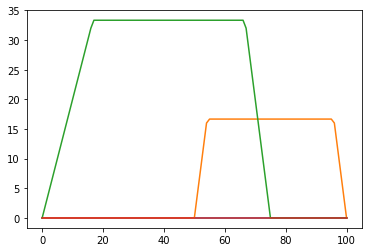

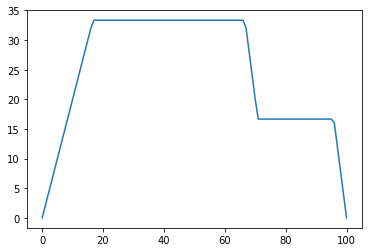

In [ ]:
import matplotlib.pyplot as plt 

#Przesłanki
Fordewind = [150, 180]
Baksztag = [105, 135, 165]
Polwiatr = [60, 90, 120]
Bajdewind = [45, 75]

#Konkluzje
Wyluzowane = [100, 100];
Wybrane = [50, 75, 100]
MocnoWybrane =[0, 50, 75]
MaksymalnieWybrane = [0, 0]

def FordewindMF(WindDirection):
    return sMF(WindDirection, Fordewind)

def BaksztagMF(WindDirection):
    return triMF(WindDirection, Baksztag)

def PolwiatrMF(WindDirection):
    return triMF(WindDirection, Polwiatr)

def BajdewindMF(WindDirection):
    return zMF(WindDirection, Bajdewind)

def FuzzyRules(WindDirection):
    outputrange = 101
    numberofrules = 4
    rules = [[0]*outputrange]*numberofrules
    # RULE 1
    fuzzyvalue = FordewindMF(WindDirection)
    rules[0] = getsMFConclusion(outputrange,Wyluzowane,fuzzyvalue)

    # RULE 2
    fuzzyvalue = BaksztagMF(WindDirection)
    rules[1] =gettriMFConclusion(outputrange,Wybrane,fuzzyvalue)

    # RULE 3
    fuzzyvalue = PolwiatrMF(WindDirection)
    rules[2] =gettriMFConclusion(outputrange,MocnoWybrane,fuzzyvalue)

    # RULE 4
    fuzzyvalue = BajdewindMF(WindDirection)
    rules[3] = getzMFConclusion(outputrange,MaksymalnieWybrane,fuzzyvalue)
    return rules

def deffuzyfication(rule):
    #Aggregacja reguł
    fuzzyoutput = AggregateConclusions(rule)
    #Wyostrzanie
    sail = defuzzificationCentroid(fuzzyoutput)
    return sail

WindDirection = 110
rule = FuzzyRules(WindDirection)
sail = deffuzyfication(rule)
print("Dla kierunku",WindDirection , "kąt żagla wynosi: ", sail)

print("Wyostrzona wartość wyjściowa:")
print(sail)

print("Wykres konkluzji:")
plt.figure(0)
plt.plot(rule[0]) 
plt.plot(rule[1]) 
plt.plot(rule[2]) 
plt.plot(rule[3]) 

print("Wykres konkluzji po agregacji reguł:")
plt.figure(1)
fuzzyoutput = AggregateConclusions(rule)
plt.plot(fuzzyoutput) 

Wyostrzona wartość wyjściowa:
60.83387270765912
Wykres konkluzji:
Wykres konkluzji po agregacji reguł:
Przesłanka:


Text(0, 0.5, 'stopeń spełnienia')

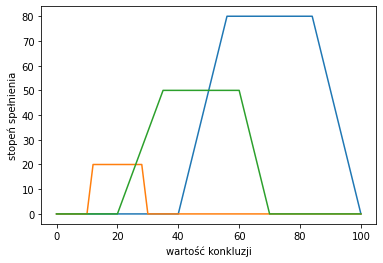

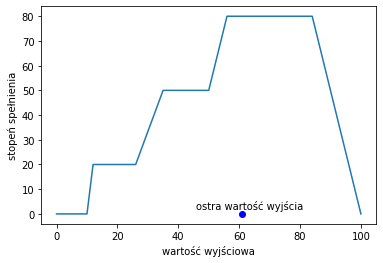

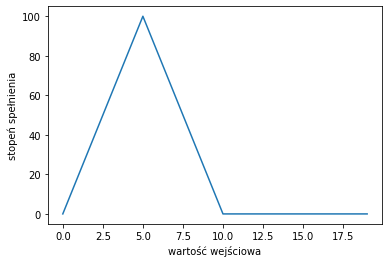

In [ ]:
#Przykładowy kod regulatora rozmytego

import matplotlib.pyplot as plt 

A = [5,10,10]
B = [0,5,10]
D = [8,10,12,16]
x = 9
outputrange = 101
numberofrules = 3
C1 = [40, 60, 80, 100]
C2 = [10, 20, 30]
C3 = [20, 50, 70]

rule = [[0]*outputrange]*numberofrules

#Reguła 1, if x = A, then y = C1
fuzzyvalue = triMF(x,A)
rule[0] = gettrapMFConclusion(outputrange,C1,fuzzyvalue)

#Reguła 2, if x = B, then y = C2
fuzzyvalue = triMF(x,B)
rule[1] = gettriMFConclusion(outputrange,C2,fuzzyvalue)

#Reguła 3, if x = D, then y = C3
fuzzyvalue = trapMF(x,D)
rule[2] = gettriMFConclusion(outputrange,C3,fuzzyvalue)

#Aggregacja reguł
fuzzyoutput = AggregateConclusions(rule)
#Wyostrzanie
u = defuzzificationCentroid(fuzzyoutput)

print("Wyostrzona wartość wyjściowa:")
print(u)

print("Wykres konkluzji:")
plt.figure(0)
plt.plot(rule[0]) 
plt.plot(rule[1]) 
plt.plot(rule[2]) 
plt.xlabel('wartość konkluzji')
plt.ylabel('stopeń spełnienia')

print("Wykres konkluzji po agregacji reguł:")
plt.figure(1)
plt.plot(fuzzyoutput) 
plt.xlabel('wartość wyjściowa')
plt.ylabel('stopeń spełnienia')
plt.plot(u,0,'bo')
plt.text(u-15,2,'ostra wartość wyjścia')

print("Przesłanka:")
xd = [0] * 20
for x in range(20):
  xd[x] = triMF(x,B)

plt.figure(2)
plt.plot(xd) 
plt.xlabel('wartość wejściowa')
plt.ylabel('stopeń spełnienia')

Algorytm doboru żagli

In [ ]:
# Rozmyty układ ustawienia żagla
# 0 - max wybrany
# 100 - max zluzowany

import matplotlib.pyplot as plt 

#Przesłanki
Fordewind = [150, 180]
Baksztag = [105, 135, 165]
Polwiatr = [60, 90, 120]
Bajdewind = [45, 60 ,85]
Martwy = [20,60]

#Konkluzje
Wyluzowane = [75, 115];
Wybrane = [50, 75, 100]
MocnoWybrane =[25, 50, 75]
BardzoMocnoWybrane =[0, 15, 30]
MaksymalnieWybrane = [0, 20]

def FordewindMF(WindDirection):
    return sMF(WindDirection, Fordewind)

def BaksztagMF(WindDirection):
    return triMF(WindDirection, Baksztag)

def PolwiatrMF(WindDirection):
    return triMF(WindDirection, Polwiatr)

def BajdewindMF(WindDirection):
    return triMF(WindDirection, Bajdewind)

def MartwyMF(WindDirection):
    return zMF(WindDirection, Martwy)

def FuzzyRules(WindDirection):
    outputrange = 113
    numberofrules = 5
    rules = [[0]*outputrange]*numberofrules
    # RULE 1
    fuzzyvalue = FordewindMF(WindDirection)
    rules[0] = getsMFConclusion(outputrange,Wyluzowane,fuzzyvalue)

    # RULE 2
    fuzzyvalue = BaksztagMF(WindDirection)
    rules[1] =gettriMFConclusion(outputrange,Wybrane,fuzzyvalue)

    # RULE 3
    fuzzyvalue = PolwiatrMF(WindDirection)
    rules[2] =gettriMFConclusion(outputrange,MocnoWybrane,fuzzyvalue)

    # RULE 4
    fuzzyvalue = BajdewindMF(WindDirection)
    rules[3] = gettriMFConclusion(outputrange,BardzoMocnoWybrane,fuzzyvalue)

    # RULE 5
    fuzzyvalue = MartwyMF(WindDirection)
    rules[4] = getzMFConclusion(outputrange,MaksymalnieWybrane,fuzzyvalue)
    return rules

def deffuzyfication(rule):
    #Aggregacja reguł
    fuzzyoutput = AggregateConclusions(rule)
    #plt.figure(1)
    #plt.plot(fuzzyoutput) 
    #Wyostrzanie
    sail = defuzzificationCentroid(fuzzyoutput)
    return sail

Test zakresu przesłanek-konkluzji algorytmu

In [ ]:
for WindDirection in range(181):
  rule = FuzzyRules(WindDirection)
  sail = deffuzyfication(rule)
  if WindDirection <39:
    sail = sail - 2  
  if WindDirection <42:
    sail = sail - 2  
  if WindDirection <45:
    sail = sail - 2 
  print("Dla kierunku", WindDirection, "kąt żagla wynosi: ", int(sail))

Algorytm Utrzymywania Kursu - Podstawowa wersja

In [ ]:
#0 to maksymalne wychylenie na bakburtę, 100 to maksymalne wychylenie na sterburtę.
# e to błąd kursu
# de to pochodna błędu kursu * 10

#Przesłanki
eNL = [-40, -15]
eNS = [-20, -10, -3]
eZ = [-5, 0, 5]
ePS = [3, 10, 20]
ePL = [15, 40]

deNL = [-40, -15]
deNS = [-20, -10, -3]
deZ = [-5, 0, 5]
dePS = [3, 10, 20]
dePL = [15, 40]

#Konkluzje
MaxBakburta = [1, 2]
MocnoBakburta = [0,15,30]
LekkoBakburta = [25,35,45]
SterZero = [40,50,60]
LekkoSterburta = [55,65,75]
MocnoSterburta = [70,85,100]
MaxSterburta = [98, 99]

#Zdefiniowanie aktualnej wartości przesłanki
#Uchyb
def eNLMF(value):
    return zMF(value, eNL)

def eNSMF(value):
    return triMF(value, eNS)

def eZMF(value):
    return triMF(value, eZ)

def ePSMF(value):
    return triMF(value, ePS)

def ePLMF(value):
    return sMF(value, ePL)

#Pochodna uchybu
def deNLMF(value):
    return zMF(value, deNL)

def deNSMF(value):
    return triMF(value, deNS)

def deZMF(value):
    return triMF(value, deZ)

def dePSMF(value):
    return triMF(value, dePS)

def dePLMF(value):
    return sMF(value, dePL)

def FuzzyRules(error,errorDerivative):
    outputrange = 101
    numberofrules = 19
    rules = [[0]*outputrange]*numberofrules
    # RULE 1
    fuzzyvalue = fuzzyAnd( eNLMF(error) , deNLMF(errorDerivative) )
    rules[0] = getsMFConclusion(outputrange,MaxSterburta,fuzzyvalue)
    # RULE 2
    fuzzyvalue = fuzzyAnd( eNLMF(error) , deNSMF(errorDerivative) )
    rules[1] = gettriMFConclusion(outputrange,MocnoSterburta,fuzzyvalue)
    # RULE 3
    fuzzyvalue = fuzzyAnd( eNLMF(error) , fuzzyOr( deZMF(errorDerivative) , dePSMF(errorDerivative) ) )
    rules[2] = gettriMFConclusion(outputrange,LekkoSterburta,fuzzyvalue)
    # RULE 4
    fuzzyvalue = fuzzyAnd( eNLMF(error) , dePLMF(errorDerivative) )
    rules[3] = gettriMFConclusion(outputrange,SterZero,fuzzyvalue)

    # RULE 5
    fuzzyvalue = fuzzyAnd( eNSMF(error) , deNLMF(errorDerivative) )
    rules[4] = gettriMFConclusion(outputrange,MocnoSterburta,fuzzyvalue)
    # RULE 6
    fuzzyvalue = fuzzyAnd( eNSMF(error) , fuzzyOr( deNSMF(errorDerivative) , deZMF(errorDerivative) ) )
    rules[5] = gettriMFConclusion(outputrange,LekkoSterburta,fuzzyvalue)
    # RULE 7
    fuzzyvalue = fuzzyAnd( eNSMF(error) , dePSMF(errorDerivative) )
    rules[6] = gettriMFConclusion(outputrange,SterZero,fuzzyvalue)
    # RULE 8
    fuzzyvalue = fuzzyAnd( eNSMF(error) , dePLMF(errorDerivative) )
    rules[7] = gettriMFConclusion(outputrange,LekkoBakburta,fuzzyvalue)

    # RULE 9
    fuzzyvalue = fuzzyAnd( eZMF(error) , fuzzyOr( deNLMF(errorDerivative) , deNSMF(errorDerivative) ) )
    rules[8] = gettriMFConclusion(outputrange,LekkoSterburta,fuzzyvalue)
    # RULE 10
    fuzzyvalue = fuzzyAnd( eZMF(error) , deZMF(errorDerivative) )
    rules[9] = gettriMFConclusion(outputrange,SterZero,fuzzyvalue)
    # RULE 11
    fuzzyvalue = fuzzyAnd( eZMF(error) , fuzzyOr( dePSMF(errorDerivative) , dePLMF(errorDerivative) ) )
    rules[10] = gettriMFConclusion(outputrange,LekkoBakburta,fuzzyvalue)

    # RULE 12
    fuzzyvalue = fuzzyAnd( ePSMF(error) , deNLMF(errorDerivative) )
    rules[11] = gettriMFConclusion(outputrange,LekkoSterburta,fuzzyvalue)
    # RULE 13
    fuzzyvalue = fuzzyAnd( ePSMF(error) , deNSMF(errorDerivative) )
    rules[12] = gettriMFConclusion(outputrange,SterZero,fuzzyvalue)
    # RULE 14
    fuzzyvalue = fuzzyAnd( ePSMF(error) , fuzzyOr( deZMF(errorDerivative) , dePSMF(errorDerivative) ) )
    rules[13] = gettriMFConclusion(outputrange,LekkoBakburta,fuzzyvalue)
    # RULE 15
    fuzzyvalue = fuzzyAnd( ePSMF(error) , dePLMF(errorDerivative) )
    rules[14] = gettriMFConclusion(outputrange,MocnoBakburta,fuzzyvalue)

    # RULE 16
    fuzzyvalue = fuzzyAnd( ePLMF(error) , deNLMF(errorDerivative) )
    rules[15] = gettriMFConclusion(outputrange,SterZero,fuzzyvalue)
    # RULE 17
    fuzzyvalue = fuzzyAnd( ePLMF(error) , fuzzyOr( deNSMF(errorDerivative) , deZMF(errorDerivative) ) )
    rules[16] = gettriMFConclusion(outputrange,LekkoBakburta,fuzzyvalue)
    # RULE 18
    fuzzyvalue = fuzzyAnd( ePLMF(error) , dePSMF(errorDerivative) )
    rules[17] = gettriMFConclusion(outputrange,MocnoBakburta,fuzzyvalue)
    # RULE 19
    fuzzyvalue = fuzzyAnd( ePLMF(error) , dePLMF(errorDerivative) )
    rules[18] = getzMFConclusion(outputrange,MaxBakburta,fuzzyvalue)

    return rules

def deffuzyfication(rule):
    #Aggregacja reguł
    fuzzyoutput = AggregateConclusions(rule)
    #Wyostrzanie
    rudder = defuzzificationCentroid(fuzzyoutput)
    return rudder

Test zakresu zmiennych algorutmu

In [ ]:
for error in range(-50,50):
  for errorDerivative in range(-50,50):
    rule = FuzzyRules(error,errorDerivative)
    rudder = deffuzyfication(rule)
    print("Błędu ",error, " i pochodnej błędu ", errorDerivative,  "ustawienie steru wynosi: ", rudder)

Model 

In [ ]:
pip install snoop

In [ ]:
# interpreted Matlab function "f.m" for the Simulink file "SailingYachtModel.slx"
# This function describes the dynamics of a 4DOF sailing yacht model
# and gives the derivative of the state X and the sail angle delta_s.
# The input vector V_in contains the system state and the control input vector. 
#
# For the model description, notations, equations and parameters,
# see Xiao and Jouffroy, "Modeling and nonlinear heading control of sailing
# yachts", IEEE Journal of Oceanic Engineering, vol. 39, no. 2., pp. 256-268, 2014.
# 
# Jerome Jouffroy, Jiaxi He and Lin Xiao, 2014.
# University of Southern Denmark.
# rewrited to python KA

from scipy.interpolate import PchipInterpolator
from scipy.integrate import ode
import numpy as np
from numpy import sin, cos, log, arctan2, sqrt, add
import matplotlib.pyplot as plt
import snoop
from tqdm import tqdm
from numpy.random import normal
import pandas as pd
import json
import os


par = {}


par['m'] = 25900                         # (kg),mass of the vehicle
par['Ixx'] = 133690
par['Izz'] = 24760
par['Ixz'] = 2180                        # moment of inertia
par['a11'] = 970
par['a22'] = 17430
par['a44'] = 106500
par['a66'] = 101650
par['a24'] = -13160
par['a26'] = -6190
par['a46'] = 4730                        # (kg),added mass coef.

par['vt'] = 10                           # the norm of wind velocity
par['alpha_w'] = np.pi                   # the direction of wind (coming from the north, ie going south)

par['rho_a'] = 1.2                       # (kg/m^3), air density
par['As'] = 170                          # (m^2), sail area
par['h0'] = 0.0005                       # (m), roughness height
par['h1'] = 11.58                        # (m), reference height
par['z_s'] = -11.58                      # (m), (x,y,z) is the CoE
par['xs'] = 0
par['ys'] = 0
par['zs'] = -11.58                       # (m), (x,y,z) is the CoE
par['Xce'] = 0.6                         # (m), distance along the mast to the CoE
par['Xm'] = 0.3                          # (m), x-coordinate of the mast 

par['rho_w'] = 1025                      # (kg/m^3), water density
par['Ar'] = 1.17                         # (m^2), rudder area
par['d_r'] = 1.9                         # rudder draft
par['zeta_r'] = 0.8                      # rudder efficiency
par['x_r'] = -8.2
par['z_r'] = -0.78                       # (m), (x,y,z) is the CoE
par['xr'] = -8.2
par['yr'] = 0
par['zr'] = -0.78                        # (m), (x,y,z) is the CoE

par['Ak'] = 8.7                          # (m^2), keel area
par['d_k'] = 2.49                        # keel draft
par['zeta_k'] = 0.7                      # keel efficiency
par['x_k'] = 0
par['z_k'] = -0.58                       # (m), (x,y,z) is the CoE
par['xk'] = 0
par['yk'] = 0
par['zk'] = -0.58                        # (m), (x,y,z) is the CoE

par['x_h'] = 0
par['z_h'] = -1.18                       # (m), (x,y,z) is the CoE
par['xh'] = 0
par['yh'] = 0
par['zh'] = -1.18                        # (m), (x,y,z) is the CoE

par['w_c'] = 60000                       # (N), crew weight 20000
par['x_c'] = -8                          # (m), crew position
par['y_bm'] = 3.6                        # (m), yacht beam

par['a'] = -5.89
par['b'] = 8160
par['c'] = 120000
par['d'] = 50000



# ------------------------------------------------------------------------------------------------------------------------------
# function [Cls,Cds] = sailcoef(attack)
# @snoop
def sailcoef(attack):
    # generate a lookup table for the lift/drag coefficients for the sail
    # and compute Cls/Cds from the lookup table using interpolation.
    # lookup table
    xdata = np.linspace(-np.pi, np.pi, 73)  # every 5 degrees
    xdata = xdata / np.pi * 180
    # lift curve
    p1 = [0, 0.15, 0.32, 0.48, 0.7, 0.94, 1.15, 1.3, 1.28, 1.15, 1.1, 1.05, 1,
          0.9, 0.82, 0.72, 0.68, 0.56, 0.48, 0.32, 0.21, 0.08, -0.06, -0.18,
          -0.3, -0.4, -0.53, -0.64, -0.72, -0.84, -0.95, -1.04, -1.1, -1.14,
          -1.08, -0.76, 0]
    p1.reverse()
    p1 = list(-1 * np.array(p1))
    p2 = [0.15, 0.32, 0.48, 0.7, 0.94, 1.15, 1.3, 1.28, 1.15, 1.1, 1.05, 1,
          0.9, 0.82, 0.72, 0.68, 0.56, 0.48, 0.32, 0.21, 0.08, -0.06, -0.18,
          -0.3, -0.4, -0.53, -0.64, -0.72, -0.84, -0.95, -1.04, -1.1, -1.14,
          -1.08, -0.76, 0]
    yldata = p1 + p2
    # drag curve
    p1 = [0.1, 0.12, 0.14, 0.16, 0.19, 0.26, 0.35, 0.46, 0.54, 0.62, 0.7, 0.78,
          0.9, 0.98, 1.04, 1.08, 1.16, 1.2, 1.24, 1.26, 1.28, 1.34, 1.36, 1.37,
          1.33, 1.31, 1.28, 1.26, 1.25, 1.2, 1.1, 1.04, 0.88, 0.8, 0.64, 0.38,
          0.1]
    p1.reverse()
    p2 = [0.12, 0.14, 0.16, 0.19, 0.26, 0.35, 0.46, 0.54, 0.62, 0.7, 0.78, 0.9,
          0.98, 1.04, 1.08, 1.16, 1.2, 1.24, 1.26, 1.28, 1.34, 1.36, 1.37,
          1.33, 1.31, 1.28, 1.26, 1.25, 1.2, 1.1, 1.04, 0.88, 0.8, 0.64,
          0.38, 0.1]
    yddata = p1 + p2
    # fit the input angle of attack into the interval [-pi,pi]
    if attack > np.pi:
        attack = np.mod(attack + np.pi, 2 * np.pi) - np.pi
    else:
        if attack < -np.pi:
            attack = np.mod(attack - np.pi, -2 * np.pi) + np.pi
    # # interpolation
    attack = attack / np.pi * 180
    Cls = PchipInterpolator(xdata, yldata)(attack)
    Cds = PchipInterpolator(xdata, yddata)(attack)
    return Cls, Cds
    # Cls = interp1(xdata,yldata,attack,'pchip');
    # Cds = interp1(xdata,yddata,attack,'pchip');
# #------------------------------------------------------------------------------------------------------------------------------
# function [Clr,Cdr] = ruddercoef(attack)
def ruddercoef(attack):
    # generate a lookup table for the lift/drag coefficients for the sail
    # and compute Cls/Cds from the lookup table using interpolation.
    # lookup table
    xdata = np.linspace(-np.pi, np.pi, 73)  # every 5 degrees
    xdata = xdata / np.pi * 180
    # lift curve
    p1 = [0, 0.42, 0.73, 0.95, 1.1, 1.165, 1.18, 1.155, 1.12,
          1.065, 1, 0.92, 0.83, 0.72, 0.62, 0.48, 0.33, 0.16]
    p1.reverse()
    yl = list(-1 * np.array(p1))
    # yl = fliplr(p1) * (-1);
    p2 = [0, 0.42, 0.73, 0.95, 1.1, 1.165, 1.18, 1.155, 1.12,
          1.065, 1, 0.92, 0.83, 0.72, 0.62, 0.48, 0.33, 0.16, 0] + yl
    p2.reverse()
    p2 = list(-1 * np.array(p2))
    p3 = [0.42, 0.73, 0.95, 1.1, 1.165, 1.18, 1.155, 1.12, 1.065,
          1, 0.92, 0.83, 0.72, 0.62, 0.48, 0.33, 0.16, 0] + yl
    yldata = p2 + p3
    # drag curve
    yd = [0, 0.03, 0.06, 0.1, 0.17, 0.3, 0.48, 0.74, 0.98, 1.18,
          1.34, 1.5, 1.65, 1.76, 1.89, 1.97, 2.01, 2.05]
    yd.reverse()
    p1 = [0, 0.03, 0.06, 0.1, 0.17, 0.3, 0.48, 0.74, 0.98, 1.18,
          1.34, 1.5, 1.65, 1.76, 1.89, 1.97, 2.01, 2.05, 2.08]
    p1 = p1 + yd
    p1.reverse()
    p2 = [0.03, 0.06, 0.1, 0.17, 0.3, 0.48, 0.74, 0.98, 1.18,
          1.34, 1.5, 1.65, 1.76, 1.89, 1.97, 2.01, 2.05, 2.08]
    p2 = p2 + yd
    yddata = p1 + p2
    # yddata = [fliplr([0 0.03 0.06 ...
    #     0.1 0.17 0.3 0.48 0.74 0.98 1.18 1.34 1.5 1.65 1.76 1.89 1.97 2.01 2.05 2.08 yd])...
    #     [0.03 0.06 ...
    #     0.1 0.17 0.3 0.48 0.74 0.98 1.18 1.34 1.5 1.65 1.76 1.89 1.97 2.01 2.05 2.08 yd]];
    # fit the input angle of attack into the interval [-pi,pi]
    if attack > np.pi:
        attack = np.mod(attack + np.pi, 2 * np.pi) - np.pi
    else:
        if attack < -np.pi:
            attack = np.mod(attack - np.pi, -2 * np.pi) + np.pi
    # interpolation
    attack = attack / np.pi * 180
    # Clr = interp1(xdata,yldata,attack,'pchip');
    # Cdr = interp1(xdata,yddata,attack,'pchip');
    Clr = PchipInterpolator(xdata, yldata)(attack)
    Cdr = PchipInterpolator(xdata, yddata)(attack)
    return Clr, Cdr
#------------------------------------------------------------------------------------------------------------------------------
# function [Clk,Cdk] = keelcoef(attack)
def keelcoef(attack):
    # generate a lookup table for the lift/drag coefficients for the sail
    # and compute Cls/Cds from the lookup table using interpolation.
    # lookup table
    xdata = np.linspace(-np.pi, np.pi, 73)  # every 5 degrees
    xdata = xdata / np.pi * 180
    # lift curve
    p1 = [0, 0.425, 0.74, 0.94, 1.1, 1.17, 1.19, 1.16, 1.12, 1.07, 0.99, 0.92,
          0.84, 0.74, 0.63, 0.49, 0.345, 0.185]
    p1.reverse()
    yl = list(-1 * np.array(p1))
    # yl = fliplr([0 0.425 0.74 ...
    #     0.94 1.1 1.17 1.19 1.16 1.12 1.07 0.99 0.92 0.84 0.74 0.63 0.49 0.345 0.185])*(-1);
    p1 = [0, 0.425, 0.74, 0.94, 1.1, 1.17, 1.19, 1.16, 1.12, 1.07, 0.99, 0.92,
          0.84, 0.74, 0.63, 0.49, 0.345, 0.185, 0]
    p1 = p1 + yl
    p1.reverse()
    p1 = list(-1 * np.array(p1))
    p2 = [0.425, 0.74, 0.94, 1.1, 1.17, 1.19, 1.16, 1.12, 1.07, 0.99, 0.92,
          0.84, 0.74, 0.63, 0.49, 0.345, 0.185, 0]
    p2 = p2 + yl
    # yldata = [fliplr([0 0.425 0.74 ...
    #     0.94 1.1 1.17 1.19 1.16 1.12 1.07 0.99 0.92 0.84 0.74 0.63 0.49 0.345 0.185 0 yl])*(-1) ...
    #     [0.425 0.74 ...
    #     0.94 1.1 1.17 1.19 1.16 1.12 1.07 0.99 0.92 0.84 0.74 0.63 0.49 0.345 0.185 0 yl]];
    yldata = p1 + p2
    # drag curve
    yd = [0, 0.04, 0.07, 0.1, 0.17, 0.3, 0.49, 0.76, 0.98, 1.19, 1.34,
          1.5, 1.65, 1.77, 1.88, 1.96, 2.01, 2.05]
    yd.reverse()
    # yd = fliplr([0 0.04 0.07 ...
    #     0.1 0.17 0.3 0.49 0.76 0.98 1.19 1.34 1.5 1.65 1.77 1.88 1.96 2.01 2.05]);
    p1 = [0, 0.04, 0.07, 0.1, 0.17, 0.3, 0.49, 0.76, 0.98, 1.19, 1.34,
          1.5, 1.65, 1.77, 1.88, 1.96, 2.01, 2.05, 2.09]
    p1 = p1 + yd
    p1.reverse()
    p2 = [0.04, 0.07, 0.1, 0.17, 0.3, 0.49, 0.76, 0.98, 1.19, 1.34, 1.5, 1.65,
          1.77, 1.88, 1.96, 2.01, 2.05, 2.09]
    p2 = p2 + yd
    yddata = p1 + p2
    # yddata = [fliplr([0 0.04 0.07 ...
    #     0.1 0.17 0.3 0.49 0.76 0.98 1.19 1.34 1.5 1.65 1.77 1.88 1.96 2.01 2.05 2.09 yd])...
    #     [0.04 0.07 ...
    #     0.1 0.17 0.3 0.49 0.76 0.98 1.19 1.34 1.5 1.65 1.77 1.88 1.96 2.01 2.05 2.09 yd]];
    # fit the input angle of attack into the interval [-pi,pi]
    if attack > np.pi:
        attack = np.mod(attack + np.pi, 2 * np.pi) - np.pi
    else:
        if attack < -np.pi:
            attack = np.mod(attack - np.pi, -2 * np.pi) + np.pi
    # interpolation
    attack = attack / np.pi * 180
    # Clk = interp1(xdata,yldata,attack,'pchip');
    # Cdk = interp1(xdata,yddata,attack,'pchip');
    Clk = PchipInterpolator(xdata, yldata)(attack)
    Cdk = PchipInterpolator(xdata, yddata)(attack)
    return Clk, Cdk
    #------------------------------------------------------------------------------------------------------------------------------
    # function F = resistancehull(alpha_a)


def resistancehull(alpha_a):
    xdata = np.linspace(0, 6, 13)  # every 0.5m/s
    ydata = np.array([0, 0.15, 0.35, 0.5, 0.675, 0.825, 1.175, 1.4, 2,
                      4.85, 9.85, 18.46, 27.5]) * 1000
    # interpolation
    if alpha_a <= 6:
        # F = interp1(xdata,ydata,alpha_a,'pchip');
        F = PchipInterpolator(xdata, ydata)(alpha_a)
    else:
        # F = interp1(xdata,ydata,alpha_a,'pchip','extrap');
        F = PchipInterpolator(xdata, ydata, extrapolate=True)(alpha_a)
    return F


# @snoop
def X_dot_ext(V_in):
    #  use the system parameters
    # retrieve the system state from the field input vector "V_in"
    # print(V_in)
    x = V_in[3] # 0
    y = V_in[4] # 1
    phi = V_in[5] # 2
    psi = V_in[6] # 3
    u = V_in[7] # 4
    v = V_in[8] # 5
    p = V_in[9] # 6
    r = V_in[10] # 7
    # nu = [u, v, p, r]
    nu = np.array([[u], [v], [p], [r]])
    # retrieve the input signals from the vector "V_in"
    delta_r = V_in[0]
    delta_sbar = V_in[1]
    y_w = V_in[2]
    # evaluate the matrix M and C in the model
    M_RB = [[par['m'], 0, 0, 0],
            [0, par['m'], 0, 0],
            [0, 0, par['Ixx'], -par['Ixz']],
            [0, 0, -par['Ixz'], par['Izz']]]
    M_RB = np.array(M_RB)
    C_RB = [[0, -par['m'] * r, 0, 0],
            [par['m'] * r, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0]]
    C_RB = np.array(C_RB)
    M_A = [[par['a11'], 0, 0, 0],
           [0, par['a22'], par['a24'], par['a26']],
           [0, par['a24'], par['a44'], par['a46']],
           [0, par['a26'], par['a46'], par['a66']]]
    M_A = np.array(M_A)
    C_A = [[0, 0, 0, -par['a22'] * nu.item(1) - par['a24'] * nu.item(2) - par['a26'] * nu.item(3)],
           [0, 0, 0, par['a11'] * nu.item(0)],
           [0, 0, 0, 0],
           [par['a22'] * nu.item(1) + par['a24'] * nu.item(2) + par['a26'] * nu.item(3),
            -par['a11'] * nu.item(0), 0, 0]]
    # print("C_A:")
    # print(C_A)
    C_A = np.array(C_A)
    # print("C_A:")
    # print(C_A)
    M = M_RB + M_A
    # calculate the tau vector, ie forces and moments generated from:
    # the sail
    v_t = [[par['vt'] * cos(par['alpha_w'])],
           [par['vt'] * sin(par['alpha_w'])],
           [0]]
    v_t = np.array(v_t)
    v_tw = log(abs(par['z_s']) * cos(phi) / par['h0']) / log(par['h1'] / par['h0']) * v_t
    v_tw = np.array(v_tw)
    R1 = [[cos(-psi), -sin(-psi), 0],
          [sin(-psi), cos(-psi), 0],
          [0, 0, 1]]
    R1 = np.array(R1)
    R2 = [[1, 0, 0],
          [0, cos(-phi), -sin(-phi)],
          [0, sin(-phi), cos(-phi)]]
    R2 = np.array(R2)
    v_tb = R2.dot(R1).dot(v_tw)   # wind expressed in the body frame
    V_in = [[u], [v], [0]]
    V_in = np.array(V_in)
    temp1 = np.array([p, 0, r])
    temp2 = np.array([par['xs'], par['ys'], par['zs']])
    temp3 = np.array([np.cross(temp1, temp2)]).T
    V_awb = v_tb - V_in - temp3
    V_awu = V_awb[0]
    V_awv = V_awb[1]
    # print(V_awv.real)
    # print(V_awu.real)
    alpha_aw = arctan2(V_awv.real, -V_awu.real)
    # (sail luffing or not)
    if alpha_aw > delta_sbar:
        delta_s = delta_sbar
    elif alpha_aw < -delta_sbar:
        delta_s = -delta_sbar
    else:
        delta_s = alpha_aw
    alpha_as = alpha_aw - delta_s
    [Cls, Cds] = sailcoef(alpha_as)
    Ls = 0.5 * par['rho_a'] * par['As'] * (V_awu ** 2 + V_awv ** 2) * Cls
    Ds = 0.5 * par['rho_a'] * par['As'] * (V_awu ** 2 + V_awv ** 2) * Cds
    # print([Ls * sin(alpha_aw) - Ds * cos(alpha_aw)])
    tau_sail = [Ls * sin(alpha_aw) - Ds * cos(alpha_aw),
                Ls * cos(alpha_aw) + Ds * sin(alpha_aw),
                -(Ls * cos(alpha_aw) + Ds * sin(alpha_aw)) * par['zs'],
                - (Ls * sin(alpha_aw) - Ds * cos(alpha_aw)) * par['Xce'] * sin(delta_s) + (Ls * cos(alpha_aw) + Ds * sin(alpha_aw)) * (par['Xm'] - par['Xce'] * cos(delta_s))]
    tau_sail = np.array(tau_sail)
    Mzs = tau_sail[3]
    # the rudder
    v_aru = -u + r * par['yr']
    v_arv = -v - r * par['xr'] + p * par['zr']
    alpha_ar = arctan2(v_arv.real, -v_aru.real)
    alpha_a = alpha_ar - delta_r
    [Clr, Cdr] = ruddercoef(alpha_a)
    Cdr = Cdr + Clr ** 2 * par['Ar'] / (np.pi * 2 * par['zeta_r'] * par['d_r'] ** 2)
    Lr = 0.5 * par['rho_w'] * par['Ar'] * (v_aru ** 2 + v_arv ** 2) * Clr
    Dr = 0.5 * par['rho_w'] * par['Ar'] * (v_aru ** 2 + v_arv ** 2) * Cdr
    tau_rudder = [[Lr * sin(alpha_ar) - Dr * cos(alpha_ar)],
                  [Lr * cos(alpha_ar) + Dr * sin(alpha_ar)],
                  [-(Lr * cos(alpha_ar) + Dr * sin(alpha_ar)) * par['zr']],
                  [(Lr * cos(alpha_ar) + Dr * sin(alpha_ar)) * par['xr']]]
    tau_rudder = np.array(tau_rudder)
    Mzr = tau_rudder[3]
    # the tau vector is finally given by:
    # print(tau_sail)
    # print(tau_rudder)
    # print("zzzzzzzzzzzzzzzzzz")
    tau = tau_sail + tau_rudder
    # print(tau)
    # calculate the damping forces and moments:
    # from the keel
    v_aku = -u + r * par['yk']
    v_akv = -v - r * par['xk'] + p * par['zk']
    alpha_ak = arctan2(v_akv.real, -v_aku.real)
    alpha_e = alpha_ak
    [Clk, Cdk] = keelcoef(alpha_e)
    Cdk = Cdk + Clk ** 2 * par['Ak'] / (np.pi * 2 * par['zeta_k'] * par['d_k'] ** 2)
    Lk = 0.5 * par['rho_w'] * par['Ak'] * (v_aku ** 2 + v_akv ** 2) * Clk
    Dk = 0.5 * par['rho_w'] * par['Ak'] * (v_aku ** 2 + v_akv ** 2) * Cdk
    D_keel = [[-Lk * sin(alpha_ak) + Dk * cos(alpha_ak)],
              [-Lk * cos(alpha_ak) - Dk * sin(alpha_ak)],
              [-(-Lk * cos(alpha_ak) - Dk * sin(alpha_ak)) * par['zk']],
              [-(Lk * cos(alpha_ak) + Dk * sin(alpha_ak)) * par['xk']]]
    D_keel = np.array(D_keel)
    # from the hull
    v_ahu = -u + r * par['yh']
    v_ahv = (-v - r * par['xh'] + p * par['zh']) / cos(phi)
    v_ah = sqrt(v_aku ** 2 + v_akv ** 2)
    alpha_ah = arctan2(v_ahv.real, -v_ahu.real)
    Frh = resistancehull(v_ah)
    D_hull = [[Frh * cos(alpha_ah)],
              [-Frh * sin(alpha_ah) * cos(phi)],
              [Frh * sin(alpha_ah) * cos(phi) * par['zh']],
              [-Frh * sin(alpha_ah) * cos(phi) * par['xh']]]
    D_hull = np.array(D_hull)
    # from heel and yaw
    # (compute first eta_dot and thereby phi_dot and psi_dot)
    J = [[cos(psi), -sin(psi) * cos(phi), 0, 0],
         [sin(psi), cos(psi) * cos(phi), 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, cos(phi)]]
    J = np.array(J)
    eta_dot = J.dot(nu)
    # print(eta_dot)
    phi_dot = eta_dot.item(2)
    psi_dot = eta_dot.item(3)
    D_heelandyaw = [[0],
                    [0],
                    [par['c'] * phi_dot * abs(phi_dot)],
                    [par['d'] * psi_dot * abs(psi_dot) * cos(phi)]]
    D_heelandyaw = np.array(D_heelandyaw)
    # compute total damping vector D
    # print('ddd:')
    # print(D_keel)
    # print(D_hull)
    # print(D_heelandyaw)
    D = D_keel + D_hull + D_heelandyaw
    # righting moment plus internal moving mass system (ie transversal weight)
    phi_deg = phi * 180 / np.pi
    M_xw = -y_w * par['w_c'] * par['y_bm'] * cos(phi)
    M_zw = -y_w * par['w_c'] * par['x_c'] * sin(abs(phi))
    G = [[0],
         [0],
         [par['a'] * phi_deg ** 2 + par['b'] * phi_deg + M_xw],
         [M_zw]]
    G = np.array(G)
    # computation of nu_dot
    # nu_dot = -M\(C_RB*nu+C_A*nu)-M\D-M\G+M\tau
    # print(M)
    # print(tau)
    temp3 = np.linalg.solve(M, tau)
    # print("temp3")
    # print(temp3)
    temp2 = np.linalg.solve(M, G)
    # print("temp2")
    # print(temp2)
    # print("qqqqqqqqqqq")
    # print(C_RB.dot(nu))
    # print(C_A.dot(nu))
    temp0 = np.linalg.solve(M, (add(C_RB.dot(nu), C_A.dot(nu))))
    # print("temp0")
    # print(temp0)
    # print(M)
    # print(D)
    temp1 = np.linalg.solve(M, D)
    # print("temp1:")
    # print(temp1)
    nu_dot = add(add(-temp0, -temp1), add(-temp2, temp3))
    # print("----------------")
    # print(nu_dot)
    # print("++++++++++++++++")
    # output the derivative of the state extended with the sail angle
    X_dot_ext = eta_dot.tolist() + nu_dot.tolist() #+ [delta_s.tolist()]
    # print(type(X_dot_ext[0]))
    # if X_dot_ext[0] is not float:
    X_dot_ext = [e[0] for e in X_dot_ext]
    return X_dot_ext

def model(t, x):
    rudder = 1; #from topic sail
    sail = 1; #from topic rudder
    u = np.array([rudder, sail, 0])
    temp = np.concatenate((u, x))
    dotx = X_dot_ext(temp)
    return dotx


def main():
    r = ode(model).set_integrator('dopri5', atol=1e-5, rtol=1e-5)
    y0 = [0, 0, 0, 0, 3, 0, 0, 0]
    t0 = 0
    r.set_initial_value(y0, t0)
    t1 = 0.3
    dt = 0.1
    odp = []
    while r.successful() and r.t < t1:
        odp.append(r.integrate(r.t + dt))

    x = [e[0] for e in odp]
    y = [e[1] for e in odp]
    kat_przechylu = [e[2] for e in odp]
    kat_kursu = [e[3] for e in odp]
    predkosc_liniowa_x = [e[4] for e in odp]
    predkosc_liniowa_y = [e[5] for e in odp]
    predkosc_przechylu = [e[6] for e in odp]
    predkosc_zmiany_kursu = [e[7] for e in odp]

if __name__ == "__main__":
    main()


Damian xD

In [ ]:
import matplotlib.pyplot as plt 


DesiredDirection = 120
SetDirection = 0

if DesiredDirection<=30 and DesiredDirection>=-30:
  if DesiredDirection<=0:
    SetDirection = -30
  else:
    SetDirection = 30
elif DesiredDirection<=200 and DesiredDirection>=160:
  if DesiredDirection<=180:
    SetDirection = 160
  else:
    SetDirection = 200
else:
  SetDirection = DesiredDirection

print(SetDirection)

120


Zawracanie

In [ ]:
def Jibe(kierunek): #zwrot przez rufę (wiatr od tyłu)
  print('zwrot przez rufę w ' + kierunek)
  return kierunek

def Tacking(kierunek): #zwrot przez sztag (wiatr od przodu)
  print('zwrot przez sztag w ' + kierunek)  
  return kierunek

SetDirection = 30
SetDirectionPrevious =-30

if SetDirectionPrevious >= 30 and SetDirectionPrevious < 90 and SetDirection <=-30 and SetDirection >-90:
  Tacking('lewo')
elif SetDirectionPrevious <= -30 and SetDirectionPrevious > -90 and SetDirection >=30 and SetDirection <90:
  Tacking('prawo')
elif SetDirectionPrevious >= 200 and SetDirectionPrevious < 270 and SetDirection <=160 and SetDirection >90:
  Jibe('prawo')
elif SetDirectionPrevious <= 160 and SetDirectionPrevious > 90 and SetDirection >=200 and SetDirection <270:
  Jibe('lewo')

SetDirectionPrevious = SetDirection

zwrot przez sztag w prawo


# Planowanie trasy - potencjały


45.0


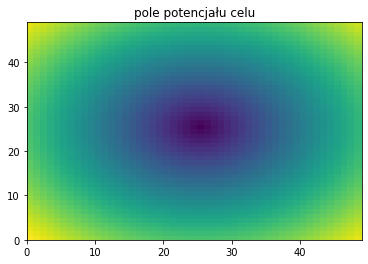

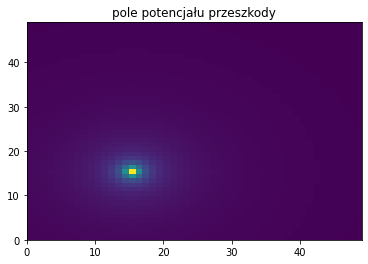

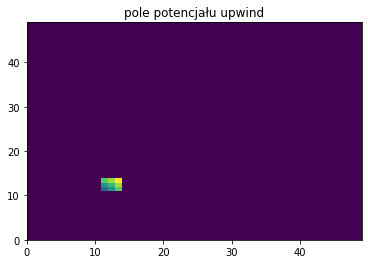

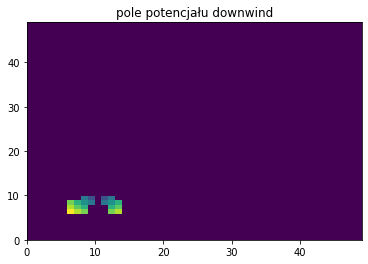

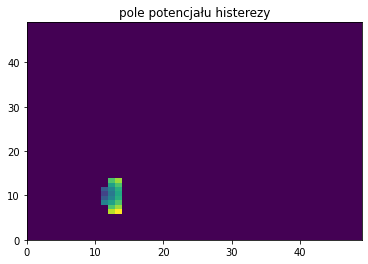

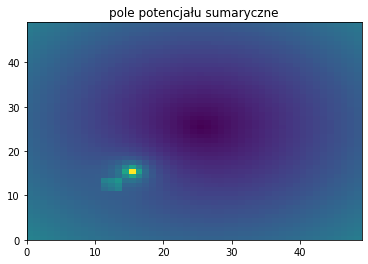

Start zejścia
0
-0.7132974083816706
-0.7132974083816706
10.71329740838167 10.71329740838167
Start zejścia
1
-0.7132974083816706
-0.7132974083816706
11.426594816763341 11.426594816763341
Start zejścia
2
0.07134487435910586
0.07134487435910586
11.355249942404235 11.355249942404235
Start zejścia
3
0.07134487435910586
0.07134487435910586
11.28390506804513 11.28390506804513
Start zejścia
4
0.07134487435910586
0.07134487435910586
11.212560193686024 11.212560193686024
Start zejścia
5
0.07134487435910586
0.07134487435910586
11.141215319326918 11.141215319326918
Start zejścia
6
0.07134487435910586
0.07134487435910586
11.069870444967812 11.069870444967812
Start zejścia
7
0.07134487435910586
0.07134487435910586
10.998525570608706 10.998525570608706
Start zejścia
8
-0.7132974083816706
-0.7132974083816706
11.711822978990376 11.711822978990376
Start zejścia
9
0.07134487435910586
0.07134487435910586
11.64047810463127 11.64047810463127
Start zejścia
10
0.07134487435910586
0.07134487435910586
11.569133

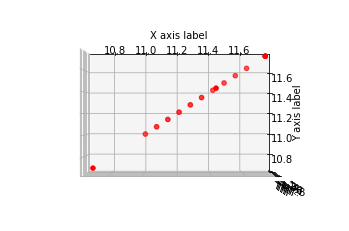

In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys

class Punkt:
  def __init__(self, x, y):
        self.x = x
        self.y = y

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

def rotUP(aktualnyKierunekWiatru):
  if aktualnyKierunekWiatru - 30 < -180:
    a = 360 + aktualnyKierunekWiatru - 30
    flaga = -1
  else: 
    a = aktualnyKierunekWiatru - 30
    flaga = 1
    
  if aktualnyKierunekWiatru + 30 > 180:
    b = -360 + aktualnyKierunekWiatru + 30
    flaga2 = -1
  else: 
    b = aktualnyKierunekWiatru + 30
    flaga2 = 1

  return a, b, flaga, flaga2

def rotDOWN(aktualnyKierunekWiatru):
  if aktualnyKierunekWiatru -160 < -180:
    a = 360 + aktualnyKierunekWiatru -160
    flaga1 = 1
    flaga3 = -1
  else: 
    a = aktualnyKierunekWiatru -160
    flaga1 = -1
    flaga3 = 1
    
  if aktualnyKierunekWiatru + 160 > 180:
    b = -360 + aktualnyKierunekWiatru + 160
    flaga2 = -1
    flaga4 = 1
  else: 
    b = aktualnyKierunekWiatru + 160
    flaga2 = 1
    flaga4 = -1

  return a, b, flaga1, flaga2, flaga3, flaga4


start = Punkt(1, 1)
koniec = Punkt(25, 25)
przeszkoda = Punkt(15, 15)
wynik = dist(start, koniec)
Statek = Punkt(10,10)
dx = 1
X = np.arange(0, 50, dx)
Y = np.arange(0, 50, dx)
X, Y = np.meshgrid(X, Y)
Wiater = 45

print(math.degrees(math.atan(20/20)))
#Potencjał względem celu
def GoalP(Gg, koniec, X, Y):
  ZPg = []
  for i in range(len(X)):
    ZPg.append(np.zeros(len(X[i])))
  ZPg = np.array(ZPg)

  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      Pg = Gg * dist(p, koniec)
      ZPg[x, y] = Pg
  return ZPg



#Potencjał względem przeszkody
def ObstacleP(k, przeszkoda, X, Y):
  ZPo = []
  for i in range(len(X)):
    ZPo.append(np.zeros(len(X[i])))
  ZPo = np.array(ZPo)
  #przeszkoda = Punkt(25, 25)
  k = 100
  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      if dist(p, przeszkoda) != 0:
        Po = k/dist(p, przeszkoda)
      else:
        Po = 200
      ZPo[x, y] = Po
  return ZPo


#Potencjał pod wiatr
def UpwindP(Gup, Statek, X, Y):
  ZPup = []
  for i in range(len(X)):
    ZPup.append(np.zeros(len(X[i])))
  ZPup = np.array(ZPup)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      fi = math.degrees(math.atan2(y - Statek.y, x - Statek.x)) #kierunek wektora PPw
  

      a, b, flaga, flaga2 = rotUP(aktualnyKierunekWiatru)

      if flaga*fi >= a and flaga2*fi <= b:
        Pup = Gup*dist(Statek, p)
        #print(X[0][x])
        #print(Y[y][0])
      else:
        Pup = 0
      #ZPup.append(Pup)
      ZPup[x, y] = Pup
  #ZPup = np.array(ZPup)
  return ZPup



#Potencjał z wiatrem
def DownwindP(Gdown, Statek, X, Y):
  ZPdown = []
  for i in range(len(X)):
    ZPdown.append(np.zeros(len(X[i])))
  ZPdown = np.array(ZPdown)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      fi = math.degrees(math.atan2(y - Statek.y, x - Statek.x))

      a, b, flaga1, flaga2, flaga3, flaga4 = rotDOWN(aktualnyKierunekWiatru)

      if flaga1 * fi <= a and flaga2 * fi >= b:
        Pdown = Gdown*dist(Statek, p)
      elif flaga3 * fi <= a and flaga4 * fi >= b:
        Pdown = Gdown*dist(Statek, p)
      else:
        Pdown = 0

      ZPdown[x, y] = Pdown
  return ZPdown


#Potencjał histerezy
def HysteresisP(Gh, Statek, X, Y):
  ZPh = []
  for i in range(len(X)):
    ZPh.append(np.zeros(len(X[i])))
  ZPh = np.array(ZPh)
  aktualnyKierunekWiatru = Wiater
  
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      fi = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      #print(fi)
      if fi >= 30 and fi <= 180-20:
        Ph = Gh*dist(Statek, p)
      else:
        Ph = 0
      ZPh[x, y] = Ph
  return ZPh


# Potencjał całkowity
def Potential(Gg, Gh, Gup, Gdown, k, koniec, przeszkoda, Statek, X, Y):
  ZPg = GoalP(3, koniec, X, Y)
  ZPh = HysteresisP(2, Statek, X, Y)
  ZPup = UpwindP(10, Statek, X, Y)
  ZPdown = DownwindP(5, Statek, X, Y)
  #for przeszkoda in tablicaPrzeszkod:
  # ZPo = ZPo + ObstacleP(100, przeszkoda, X, Y)
  ZPo = ObstacleP(100, przeszkoda, X, Y)
  #PotentialT = ZPg + ZPdown + ZPup + ZPo + ZPh
  PotentialT = ZPg + ZPup + ZPo
  return PotentialT

def plotZPg(X,Y,ZPg):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPg)
  ax.set_title("pole potencjału celu")  
  plt.show()

def plotanimate(X,Y,Z):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,Z)
  ax.set_title("Plot")  
  plt.show()


ZPg = GoalP(3, koniec, X, Y)
plotZPg(X,Y,ZPg)

ZPo = ObstacleP(100, przeszkoda, X, Y)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot_wireframe(X, Y, ZPo)
ax.pcolor(X,Y,ZPo)
ax.set_title("pole potencjału przeszkody")
plt.show()

fig = plt.figure()
ZPup = UpwindP(10, Statek, X, Y)
np.set_printoptions(threshold=sys.maxsize)
#print(ZPup)
ax = fig.add_subplot(111)
#ax.view_init(30, 30)
ax.pcolor(X,Y,ZPup)
ax.set_title("pole potencjału upwind")
#ax.plot_wireframe(X, Y, ZPup)
plt.show()

fig = plt.figure()
ZPdown = DownwindP(5, Statek, X, Y)
ax = fig.add_subplot(111)
#ax.view_init(30, 210)
ax.pcolor(X,Y,ZPdown)
ax.set_title("pole potencjału downwind")
#ax.plot_wireframe(X, Y, ZPdown)
plt.show()

fig = plt.figure()
ZPh = HysteresisP(2, Statek, X, Y)
ax = fig.add_subplot(111)
#ax.view_init(30, 210)
#ax.plot_wireframe(X, Y, ZPh)
ax.pcolor(X,Y,ZPh)
ax.set_title("pole potencjału histerezy")
plt.show()

Zsuper = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.view_init(60, 0)
#ax.plot_wireframe(X, Y, Zsuper)
ax.pcolor(X,Y,Zsuper)
ax.set_title("pole potencjału sumaryczne")
plt.show()

PotentialT = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
gradient = np.gradient(PotentialT)

# for 1D: f'(x) is approximated by (f(x+e)-f(x))/e for a small e

DaneX=[]
DaneY=[]
#Z = list(range(0, 30))
Z = []
def grad_descent(StatekInit, alpha):
    EPS = 1e-5
    StatekPrev = Punkt(StatekInit.x-10*EPS, StatekInit.y-10*EPS)
    Statek = StatekInit
    
    max_iter = 40
    iter = 0
    #print(LA.norm(np.array([Statek.x, Statek.y]) - np.array([StatekPrev.x, StatekPrev.y])))
    while iter < max_iter and (abs(koniec.x - Statek.x) > 3 or abs(koniec.y - Statek.y) > 3): #zmienić na euclides - okrąg o promieniu <3
        StatekPrev = Statek
        PotentialT = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
        #Z[iter] = PotentialT[int(Statek.x)][int(Statek.y)]
        Z.append(PotentialT[int(Statek.x)][int(Statek.y)])
        print('Start zejścia')
        print(iter)
        gradient = np.gradient(PotentialT)
        temp = Statek.x
        gradientx = alpha*gradient[0][int(Statek.x)][int(Statek.y)]
        gradienty = alpha*gradient[1][int(temp)][int(Statek.y)]
        print(gradientx)
        print(gradienty)
        if abs(gradientx) > 2:
          if gradientx < 0:
            gradientx = -2
          else:
            gradientx = 2
        if abs(gradienty) > 2:
          if gradienty < 0:
            gradienty = -2
          else:
            gradienty = 2
        Statek.x -= gradientx
        Statek.y -= gradienty
        if Statek.x > 50:
          Statek.x = 50
        if Statek.x < 0:
          Statek.x = 0
        if Statek.y > 50:
          Statek.y = 50
        if Statek.y < 0:
          Statek.y = 0
        DaneX.append(Statek.x)
        DaneY.append(Statek.y)
        print(Statek.x, Statek.y), Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y), gradient
        iter += 1
    
    return Statek, DaneX, DaneY

wynik, DaneX, DaneY = grad_descent(Statek, 1)

print('Wynik:', wynik.x, wynik.y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.azim = 270
ax.dist = 10
ax.elev = 90
#plt.xlim([0, 50])
#plt.ylim([0, 50])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
ax.scatter(DaneX, DaneY, Z, c='red')
plt.show()


In [ ]:
ZPup = []
for i in range(5):
  ZPup.append(5*np.ones(5))
print(ZPup)
ZPup = np.array(ZPup)
print(ZPup)
ZPup[2, 2] = 2
print(ZPup)
ZPup[3][3] = 3
print(ZPup)

In [ ]:
x1 = 10
y1 = 10

x2 = 10
y2 = 12 #nad

x3 = 12
y3 = 10 #prawo

x4 = 10
y4 = 8 #pod

x5 = 8
y5 = 10 #lewo

x6 = 12
y6 = 8 #prawy dół


print('nad')
fi = math.degrees(math.atan2(y2 -y1, x2 - x1))
radiany = math.atan2(y2 -y1, x2 - x1)
stopnie = radiany * 180 / math.pi
#if radiany < 0:
#  stopnie = stopnie + 360
print(radiany)
print(stopnie)

print('prawo')
fi = math.degrees(math.atan2(y3 -y1, x3 - x1))
radiany = math.atan2(y3 -y1, x3 - x1)
stopnie = radiany * 180 / math.pi
#if radiany < 0:
#  stopnie = stopnie + 360
print(radiany)
print(stopnie)

print('pod')
fi = math.degrees(math.atan2(y4 -y1, x4 - x1))
radiany = math.atan2(y4 -y1, x4 - x1)
stopnie = radiany * 180 / math.pi
#if radiany < 0:
#  stopnie = stopnie + 360
print(radiany)
print(stopnie)

print('lewo')
fi = math.degrees(math.atan2(y5 -y1, x5 - x1))
radiany = math.atan2(y5 -y1, x5 - x1)
stopnie = radiany * 180 / math.pi
#if radiany < 0:
#  stopnie = stopnie + 360
print(radiany)
print(stopnie)

print('prawy dół')
fi = math.degrees(math.atan2(y6 -y1, x6 - x1))
radiany = math.atan2(y6 -y1, x6 - x1)
stopnie = radiany * 180 / math.pi
#if radiany < 0:
#  stopnie = stopnie + 360
print(radiany)
print(stopnie)



nad
1.5707963267948966
90.0
prawo
0.0
0.0
pod
-1.5707963267948966
-90.0
lewo
3.141592653589793
180.0
prawy dół
-0.7853981633974483
-45.0


In [ ]:
Statek = Punkt(10,10)
Wiater = 135
#Potencjał pod wiatr
def UpwindP(Gup, Statek, X, Y):
  ZPup = []
  for i in range(len(X)):
    ZPup.append(np.zeros(len(X[i])))
  ZPup = np.array(ZPup)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw
      if 0 <= abs(fi)< 30:
        Pup = Gup*dist(Statek, p)
      else:
        Pup = 0
      ZPup[x, y] = Pup
  return ZPup


#Potencjał z wiatrem
def DownwindP(Gdown, Statek, X, Y):
  ZPdown = []
  for i in range(len(X)):
    ZPdown.append(np.zeros(len(X[i])))
  ZPdown = np.array(ZPdown)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw
      if 0<= abs(abs(fi)-180) < 20:
        Pdown = Gdown * dist(Statek, p)
      else:
        Pdown = 0

      ZPdown[x, y] = Pdown
  return ZPdown

#Potencjał histerezy
def HysteresisP(Gh, Statek, X, Y):
  ZPh = []
  for i in range(len(X)):
    ZPh.append(np.zeros(len(X[i])))
  ZPh = np.array(ZPh)
  aktualnyKierunekWiatru = Wiater
  
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw
      if 30 < fi < 180 - 20:
        Ph = Gh*dist(Statek, p)
      else:
        Ph = 0
      ZPh[x, y] = Ph
  return ZPh

  ZPg = GoalP(3, koniec, X, Y)
plotZPg(X,Y,ZPg)

ZPo = ObstacleP(100, przeszkoda, X, Y)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot_wireframe(X, Y, ZPo)
ax.pcolor(X,Y,ZPo)
ax.set_title("pole potencjału przeszkody")
plt.show()

fig = plt.figure()
ZPup = UpwindP(10, Statek, X, Y)
np.set_printoptions(threshold=sys.maxsize)
#print(ZPup)
ax = fig.add_subplot(111)
#ax.view_init(30, 30)
ax.pcolor(X,Y,ZPup)
ax.set_title("pole potencjału upwind")
#ax.plot_wireframe(X, Y, ZPup)
plt.show()

fig = plt.figure()
ZPdown = DownwindP(5, Statek, X, Y)
ax = fig.add_subplot(111)
#ax.view_init(30, 210)
ax.pcolor(X,Y,ZPdown)
ax.set_title("pole potencjału downwind")
#ax.plot_wireframe(X, Y, ZPdown)
plt.show()

fig = plt.figure()
ZPh = HysteresisP(2, Statek, X, Y)
ax = fig.add_subplot(111)
#ax.view_init(30, 210)
#ax.plot_wireframe(X, Y, ZPh)
ax.pcolor(X,Y,ZPh)
ax.set_title("pole potencjału histerezy")
plt.show()

In [ ]:
def rotDOWN(aktualnyKierunekWiatru):
  if aktualnyKierunekWiatru -160 < -180:
    a = 360 + aktualnyKierunekWiatru -160
    flaga1 = 1
    flaga3 = -1
  else: 
    a = aktualnyKierunekWiatru -160
    flaga1 = -1
    flaga3 = 1
    
  if aktualnyKierunekWiatru + 160 > 180:
    b = -360 + aktualnyKierunekWiatru + 160
    flaga2 = -1
    flaga4 = 1
  else: 
    b = aktualnyKierunekWiatru + 160
    flaga2 = 1
    flaga4 = -1

  return a, b, flaga1, flaga2, flaga3, flaga4


aktualnyKierunekWiatru = 100
fi = 100
a, b, flaga1, flaga2, flaga3, flaga4 = rotDOWN(aktualnyKierunekWiatru)

print(a, b, flaga1, flaga2, flaga3, flaga4)

print(flaga1 * fi <= a,flaga2 * fi >= b)
print(flaga3 * fi <= a,flaga4 * fi >= b)

if flaga1 * fi <= a and flaga2 * fi >= b:
  Pdown = 100
elif flaga3 * fi <= a and flaga4 * fi >= b:
  Pdown = 100
else:
  Pdown = 0


print(Pdown)


# Potencjały V2

45.0


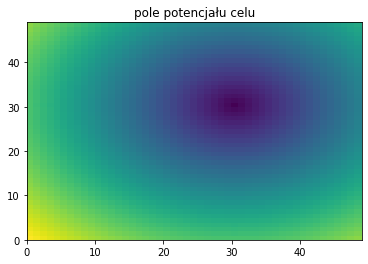

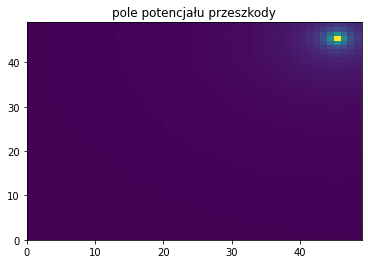

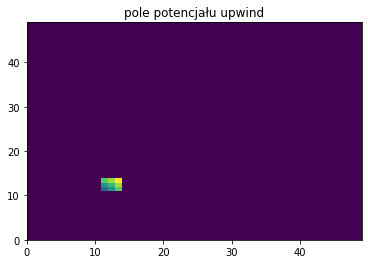

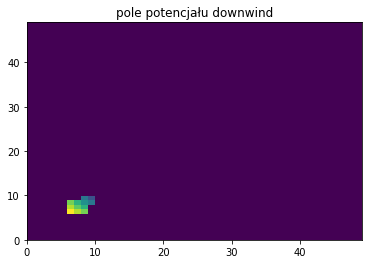

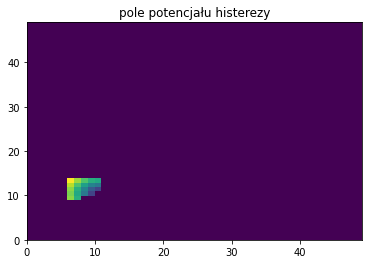

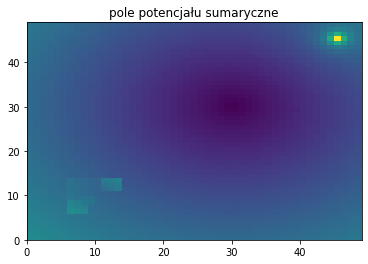

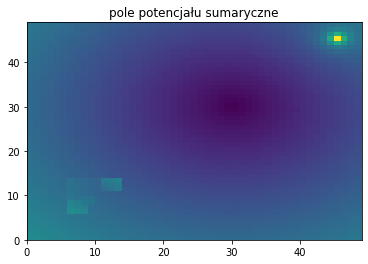

Start zejścia
Iteracja: 0
Gradient x: -1.091798773931096
Gradient y: -3.091798773931096
Nowa pozycja 11.091798773931096 12


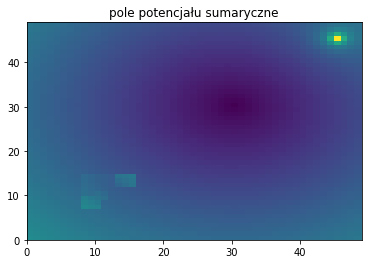

Start zejścia
Iteracja: 1
Gradient x: -1.2369442575975356
Gradient y: -3.03562541483349
Nowa pozycja 12.328743031528631 14


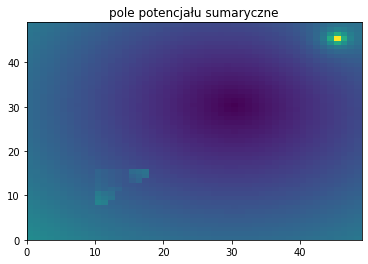

Start zejścia
Iteracja: 2
Gradient x: -1.5345669092177303
Gradient y: -3.0113881935606486
Nowa pozycja 13.863309940746362 16


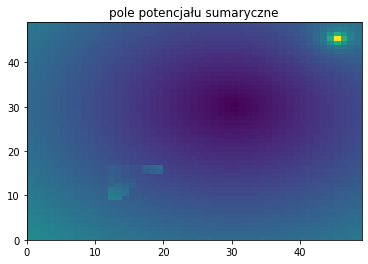

Start zejścia
Iteracja: 3
Gradient x: -2.138406770952642
Gradient y: -5.172700009721289
Nowa pozycja 15.863309940746362 18


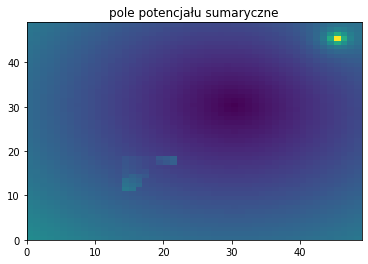

Start zejścia
Iteracja: 4
Gradient x: -2.1590510445813287
Gradient y: -5.134229553750195
Nowa pozycja 17.863309940746362 20


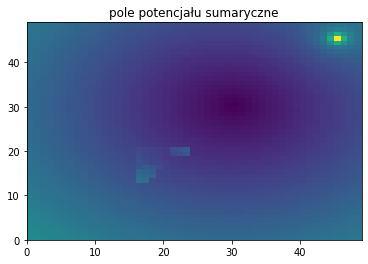

Start zejścia
Iteracja: 5
Gradient x: -2.1865998952965953
Gradient y: -5.08249044875274
Nowa pozycja 19.863309940746362 22


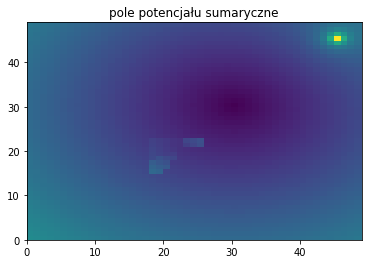

Start zejścia
Iteracja: 6
Gradient x: -2.2250925437945916
Gradient y: -5.009180294310735
Nowa pozycja 21.863309940746362 24


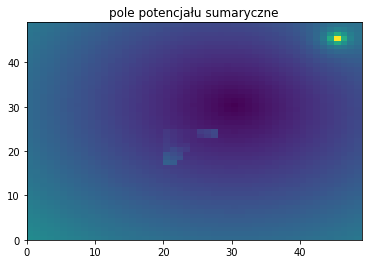

Start zejścia
Iteracja: 7
Gradient x: -2.282172107191652
Gradient y: -4.8972118639472875
Nowa pozycja 23.863309940746362 26


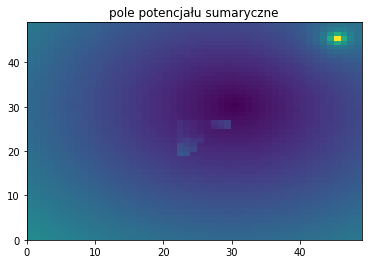

Start zejścia
Iteracja: 8
Gradient x: -2.3735064083719895
Gradient y: -4.705265270950175
Nowa pozycja 25.863309940746362 28


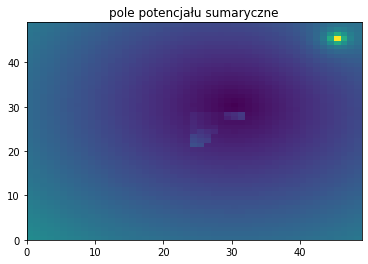

Start zejścia
Iteracja: 9
Gradient x: -2.5313606628643033
Gradient y: -4.30671081990616
Nowa pozycja 27.863309940746362 30
Wynik: 27.863309940746362 30


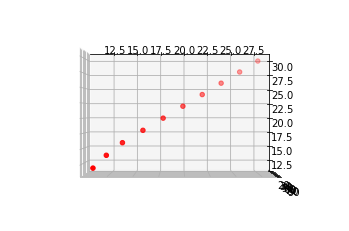

In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys

class Punkt:
  def __init__(self, x, y):
        self.x = x
        self.y = y

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

start = Punkt(1, 1)
koniec = Punkt(30, 30)
przeszkoda = Punkt(45, 45)
wynik = dist(start, koniec)
Statek = Punkt(10,10)
dx = 1
X = np.arange(0, 50, dx)
Y = np.arange(0, 50, dx)
X, Y = np.meshgrid(X, Y)
Wiater = 45

print(math.degrees(math.atan(20/20)))
#Potencjał względem celu
def GoalP(Gg, koniec, X, Y):
  ZPg = []
  for i in range(len(X)):
    ZPg.append(np.zeros(len(X[i])))
  ZPg = np.array(ZPg)

  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      Pg = Gg * dist(p, koniec)
      ZPg[x, y] = Pg
  return ZPg

#Potencjał względem przeszkody
def ObstacleP(k, przeszkoda, X, Y):
  ZPo = []
  for i in range(len(X)):
    ZPo.append(np.zeros(len(X[i])))
  ZPo = np.array(ZPo)
  #przeszkoda = Punkt(25, 25)
  k = 100
  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      if dist(p, przeszkoda) != 0:
        Po = k/dist(p, przeszkoda)
      else:
        Po = 200
      ZPo[x, y] = Po
  return ZPo


#Potencjał pod wiatr
def UpwindP(Gup, Statek, X, Y):
  ZPup = []
  for i in range(len(X)):
    ZPup.append(np.zeros(len(X[i])))
  ZPup = np.array(ZPup)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw
      if 0 <= abs(fi)< 30:
        Pup = Gup*dist(Statek, p)
      else:
        Pup = 0
      ZPup[x, y] = Pup
  return ZPup


#Potencjał z wiatrem
def DownwindP(Gdown, Statek, X, Y):
  ZPdown = []
  for i in range(len(X)):
    ZPdown.append(np.zeros(len(X[i])))
  ZPdown = np.array(ZPdown)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw
      if 0<= abs(abs(fi)-180) < 20:
        Pdown = Gdown * dist(Statek, p)
      else:
        Pdown = 0

      ZPdown[x, y] = Pdown
  return ZPdown

#Potencjał histerezy
def HysteresisP(Gh, Statek, X, Y):
  ZPh = []
  for i in range(len(X)):
    ZPh.append(np.zeros(len(X[i])))
  ZPh = np.array(ZPh)
  aktualnyKierunekWiatru = Wiater
  
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw
      if 30 < fi < 180 - 20:
        Ph = Gh*dist(Statek, p)
      else:
        Ph = 0
      ZPh[x, y] = Ph
  return ZPh


# Potencjał całkowity
def Potential(Gg, Gh, Gup, Gdown, k, koniec, przeszkoda, Statek, X, Y):
  ZPg = GoalP(Gg, koniec, X, Y)
  ZPh = HysteresisP(Gh, Statek, X, Y)
  ZPup = UpwindP(Gup, Statek, X, Y)
  ZPdown = DownwindP(Gdown, Statek, X, Y)
  #for przeszkoda in tablicaPrzeszkod:
  # ZPo = ZPo + ObstacleP(100, przeszkoda, X, Y)
  ZPo = ObstacleP(k, przeszkoda, X, Y)
  PotentialT = ZPg + ZPdown + ZPup + ZPo + ZPh
  return PotentialT

def plotZPg(X,Y,ZPg):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPg)
  ax.set_title("pole potencjału celu")  
  plt.show()

def plotZPo(X,Y,ZPo):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPo)
  ax.set_title("pole potencjału przeszkody") 
  plt.show()

def plotZPup(X,Y,ZPup):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPup)
  ax.set_title("pole potencjału upwind")
  plt.show()

def plotZPdown(X,Y,ZPdown):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPdown)
  ax.set_title("pole potencjału downwind")
  plt.show()

def plotZPh(X,Y,ZPh):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPh)
  ax.set_title("pole potencjału histerezy")
  plt.show()

def plotZsuper(X,Y,Zsuper):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,Zsuper)
  ax.set_title("pole potencjału sumaryczne")
  plt.show()

def plotAll(koniec, X, Y, przeszkoda, Statek):
  ZPg = GoalP(3, koniec, X, Y)
  plotZPg(X,Y,ZPg)

  ZPo = ObstacleP(100, przeszkoda, X, Y)
  plotZPo(X,Y,ZPo)

  ZPup = UpwindP(10, Statek, X, Y)
  plotZPup(X,Y,ZPup)

  ZPdown = DownwindP(5, Statek, X, Y)
  plotZPdown(X,Y,ZPdown)

  ZPh = HysteresisP(2, Statek, X, Y)
  plotZPh(X,Y,ZPh)

  Zsuper = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
  plotZsuper(X,Y,Zsuper)

def plotSum(X,Y,PotentialT):
  plotZsuper(X,Y,PotentialT)

plotAll(koniec, X, Y, przeszkoda, Statek)

#PotentialT = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
#gradient = np.gradient(PotentialT)
# for 1D: f'(x) is approximated by (f(x+e)-f(x))/e for a small e

DaneX=[]
DaneY=[]
Z = []

def grad_descent(StatekInit, alpha):
    EPS = 1e-5
    StatekPrev = Punkt(StatekInit.x-10*EPS, StatekInit.y-10*EPS)
    Statek = StatekInit
    
    max_iter = 20
    iter = 0
 
    while iter < max_iter and (abs(koniec.x - Statek.x) > 3 or abs(koniec.y - Statek.y) > 3): #zmienić na euclides - okrąg o promieniu <3
        StatekPrev = Statek

        PotentialT = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
        plotSum(X,Y,PotentialT)
                
        Z.append(PotentialT[int(Statek.x)][int(Statek.y)])
        print('Start zejścia')
        print('Iteracja:', iter)
        gradient = np.gradient(PotentialT)
        temp = Statek.x
        gradientx = alpha*gradient[0][int(Statek.x)][int(Statek.y)]
        gradienty = alpha*gradient[1][int(temp)][int(Statek.y)]
        print('Gradient x:',gradientx)
        print('Gradient y:',gradienty)
        if abs(gradientx) > 2:
          if gradientx < 0:
            gradientx = -2
          else:
            gradientx = 2
        if abs(gradienty) > 2:
          if gradienty < 0:
            gradienty = -2
          else:
            gradienty = 2
        Statek.x -= gradientx
        Statek.y -= gradienty
        if Statek.x > 50:
          Statek.x = 50
        if Statek.x < 0:
          Statek.x = 0
        if Statek.y > 50:
          Statek.y = 50
        if Statek.y < 0:
          Statek.y = 0
        DaneX.append(Statek.x)
        DaneY.append(Statek.y)
        print('Nowa pozycja', Statek.x, Statek.y)
        iter += 1
        
    return Statek, DaneX, DaneY

#grad_descent2(f, gradf, np.array([10.0, 8.0]), 0.01)
wynik, DaneX, DaneY = grad_descent(Statek, 1)
#DaneX, DaneY = np.meshgrid(DaneX, DaneY)
#Z = list(range(0, 10))
print('Wynik:', wynik.x, wynik.y)
Zsuper = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Zsuper = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
#ax.plot_wireframe(X, Y, Zsuper)
ax.view_init(90, 270)
#print(DaneX)
#print(DaneY)
#print(Z)
ax.scatter(DaneX, DaneY, Z, c='red')
plt.show()
#print(np.array([10.0, 8.0]))


# V3 tylko upwind 

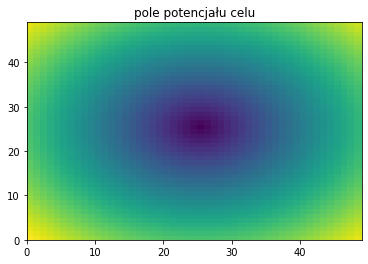

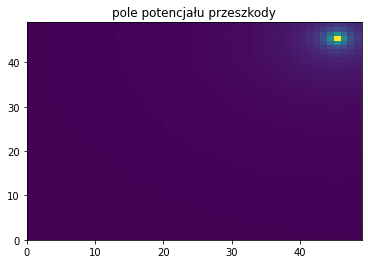

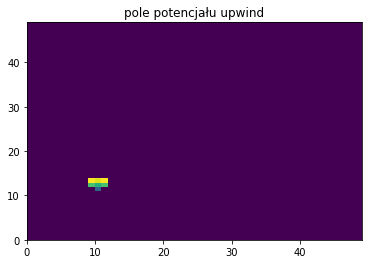

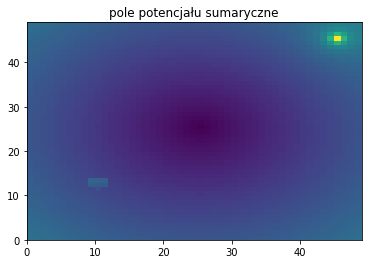

Start zejścia
Iteracja: 0
Gradient x: 2.9087170475005664
Gradient y: -2.09128295249943
Nowa pozycja 8 12


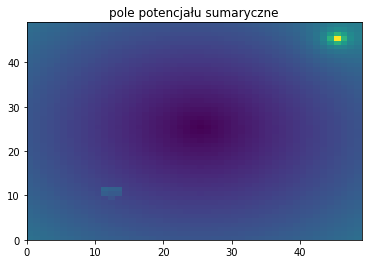

Start zejścia
Iteracja: 1
Gradient x: 2.6482477906299238
Gradient y: -1.7940200432950277
Nowa pozycja 6 13.794020043295028


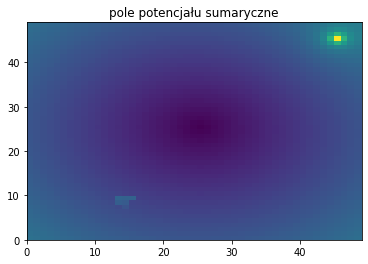

Start zejścia
Iteracja: 2
Gradient x: -2.5053737989141
Gradient y: -1.5759265079920084
Nowa pozycja 8 15.369946551287036


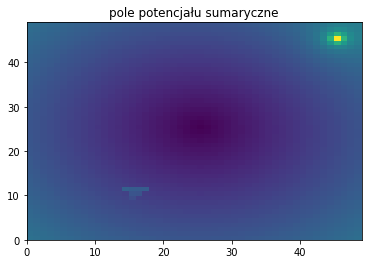

Start zejścia
Iteracja: 3
Gradient x: 2.7804694064070894
Gradient y: -1.4918584180203744
Nowa pozycja 6 16.86180496930741
Wynik: 6 16.86180496930741


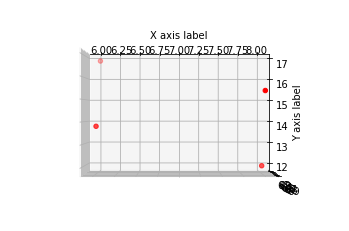

In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys

class Punkt:
  def __init__(self, x, y):
        self.x = x
        self.y = y

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

def rotUP(aktualnyKierunekWiatru):
  if aktualnyKierunekWiatru - 30 < -180:
    a = 360 + aktualnyKierunekWiatru - 30
    flaga = -1
  else: 
    a = aktualnyKierunekWiatru - 30
    flaga = 1
    
  if aktualnyKierunekWiatru + 30 > 180:
    b = -360 + aktualnyKierunekWiatru + 30
    flaga2 = -1
  else: 
    b = aktualnyKierunekWiatru + 30
    flaga2 = 1

  return a, b, flaga, flaga2

koniec = Punkt(25, 25)
przeszkoda = Punkt(45, 45)
Statek = Punkt(10,10)
dx = 1
X = np.arange(0, 50, dx)
Y = np.arange(0, 50, dx)
X, Y = np.meshgrid(X, Y)
Wiater = 0

#Potencjał względem celu
def GoalP(Gg, koniec, X, Y):
  ZPg = []
  for i in range(len(X)):
    ZPg.append(np.zeros(len(X[i])))
  ZPg = np.array(ZPg)

  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      Pg = Gg * dist(p, koniec)
      ZPg[x, y] = Pg
  return ZPg

#Potencjał względem przeszkody
def ObstacleP(k, przeszkoda, X, Y):
  ZPo = []
  for i in range(len(X)):
    ZPo.append(np.zeros(len(X[i])))
  ZPo = np.array(ZPo)
  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      if dist(p, przeszkoda) != 0:
        Po = k/dist(p, przeszkoda)
      else:
        Po = 200
      ZPo[x, y] = Po
  return ZPo

#Potencjał pod wiatr
def UpwindP(Gup, Statek, X, Y):
  ZPup = []
  for i in range(len(X)):
    ZPup.append(np.zeros(len(X[i])))
  ZPup = np.array(ZPup)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      fi = math.degrees(math.atan2(y - Statek.y, x - Statek.x)) #kierunek wektora PPw
      a, b, flaga, flaga2 = rotUP(aktualnyKierunekWiatru)

      if flaga*fi >= a and flaga2*fi <= b:
        Pup = Gup*dist(Statek, p)

      else:
        Pup = 0

      ZPup[x, y] = Pup

  return ZPup


# Potencjał całkowity
def Potential(Gg, Gh, Gup, Gdown, k, koniec, przeszkoda, Statek, X, Y):
  ZPg = GoalP(Gg, koniec, X, Y)
  ZPup = UpwindP(Gup, Statek, X, Y)
  ZPo = ObstacleP(k, przeszkoda, X, Y)
  PotentialT = ZPg + ZPup + ZPo
  return PotentialT

# Funkcje do tworzenia wykresów potencjałów
def plotZPg(X,Y,ZPg):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPg)
  ax.set_title("pole potencjału celu")  
  plt.show()

def plotZPo(X,Y,ZPo):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPo)
  ax.set_title("pole potencjału przeszkody") 
  plt.show()

def plotZPup(X,Y,ZPup):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPup)
  ax.set_title("pole potencjału upwind")
  plt.show()

def plotZsuper(X,Y,Zsuper):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,Zsuper)
  ax.set_title("pole potencjału sumaryczne")
  plt.show()

def plotAll(koniec, X, Y, przeszkoda, Statek):
  ZPg = GoalP(3, koniec, X, Y)
  plotZPg(X,Y,ZPg)

  ZPo = ObstacleP(100, przeszkoda, X, Y)
  plotZPo(X,Y,ZPo)

  ZPup = UpwindP(10, Statek, X, Y)
  plotZPup(X,Y,ZPup)

def plotSum(X,Y,PotentialT):
  plotZsuper(X,Y,PotentialT)



DaneX=[]
DaneY=[]
Z = []

plotAll(koniec, X, Y, przeszkoda, Statek)

#szukanie minimum metodą gradient descent
def grad_descent(StatekInit, alpha):
    EPS = 1e-5
    StatekPrev = Punkt(StatekInit.x-10*EPS, StatekInit.y-10*EPS)
    Statek = StatekInit
    
    max_iter = 4
    iter = 0
 
    while iter < max_iter and dist(Statek, koniec) > 3: 
        StatekPrev = Statek

        PotentialT = Potential(3, 1, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
        #tworzenie wykresu potencjału całkowitego w każdej iteracji
        #funkcje na plotowanie pojedynczych potencjałów są także zdefiniowane, więc można podejrzeć je oddzielnie
        plotSum(X,Y,PotentialT)
                
        Z.append(PotentialT[int(Statek.x)][int(Statek.y)])
        print('Start zejścia')
        print('Iteracja:', iter)
        gradient = np.gradient(PotentialT)
        temp = Statek.x
        gradientx = alpha*gradient[0][int(Statek.x)][int(Statek.y)]
        gradienty = alpha*gradient[1][int(temp)][int(Statek.y)]
        print('Gradient x:',gradientx)
        print('Gradient y:',gradienty)
        #ograniczenie zmian w kroku
        if abs(gradientx) > 2:
          if gradientx < 0:
            gradientx = -2
          else:
            gradientx = 2
        if abs(gradienty) > 2:
          if gradienty < 0:
            gradienty = -2
          else:
            gradienty = 2
        Statek.x -= gradientx
        Statek.y -= gradienty
        #ograniczenie przestrzeni
        if Statek.x > 50:
          Statek.x = 50
        if Statek.x < 0:
          Statek.x = 0
        if Statek.y > 50:
          Statek.y = 50
        if Statek.y < 0:
          Statek.y = 0
        DaneX.append(Statek.x)
        DaneY.append(Statek.y)
        print('Nowa pozycja', Statek.x, Statek.y)
        iter += 1
        
    return Statek, DaneX, DaneY

wynik, DaneX, DaneY = grad_descent(Statek, 1)

print('Wynik:', wynik.x, wynik.y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.azim = 270
ax.dist = 10
ax.elev = 90
#plt.xlim([0, 50])
#plt.ylim([0, 50])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
ax.scatter(DaneX, DaneY, Z, c='red')
plt.show()


# Potencjały V4


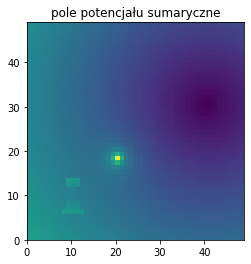

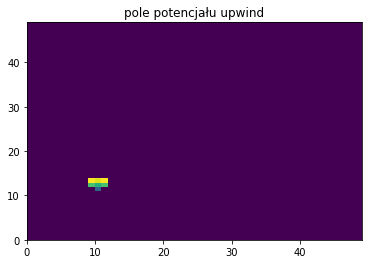

Start zejścia
Iteracja: 0
Gradient x: -2.0196544934465734
Gradient y: 1.2160313142518149
Nowa pozycja 12 8.783968685748185


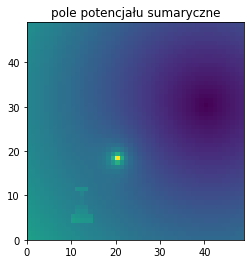

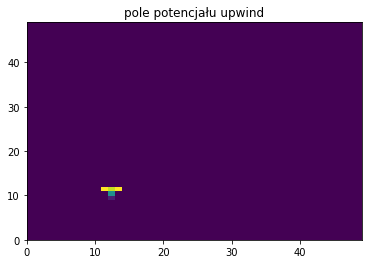

Start zejścia
Iteracja: 1
Gradient x: -1.9789109964405256
Gradient y: -4.756577056873738
Nowa pozycja 13.978910996440526 10.783968685748185


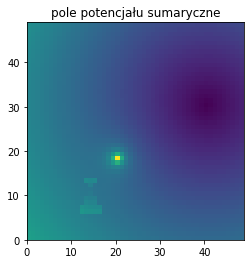

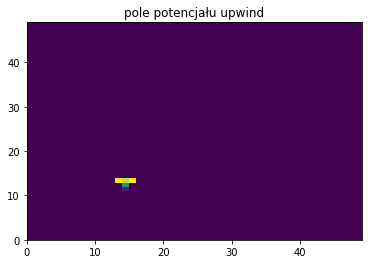

Start zejścia
Iteracja: 2
Gradient x: 0.130920128043293
Gradient y: -6.206945146029483
Nowa pozycja 13.847990868397233 12.783968685748185


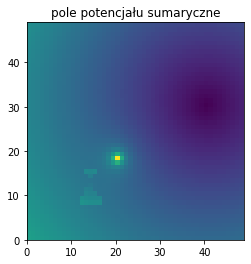

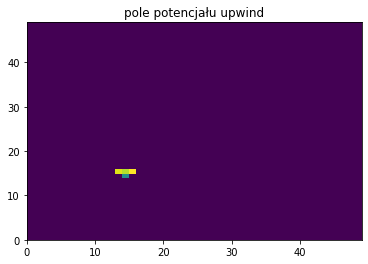

Start zejścia
Iteracja: 3
Gradient x: 0.3931949042030851
Gradient y: -5.8400722397667835
Nowa pozycja 13.454795964194147 14.783968685748185


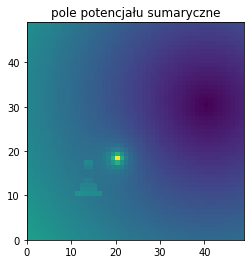

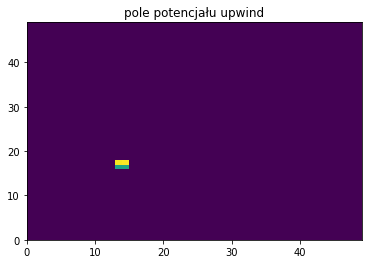

Start zejścia
Iteracja: 4
Gradient x: -1.236951413304162
Gradient y: -5.378462750780649
Nowa pozycja 14.69174737749831 16.783968685748185


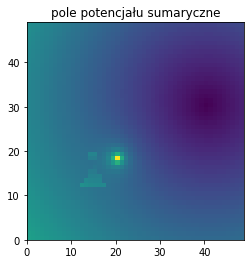

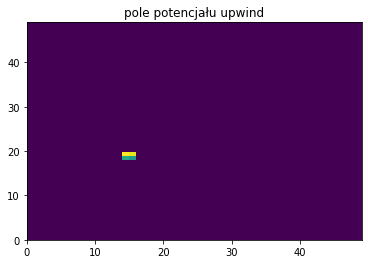

Start zejścia
Iteracja: 5
Gradient x: 1.8816494895704068
Gradient y: -5.438751368424761
Nowa pozycja 12.810097887927903 18.783968685748185


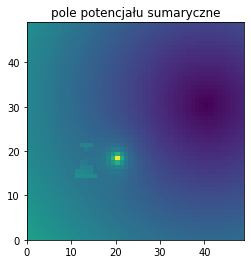

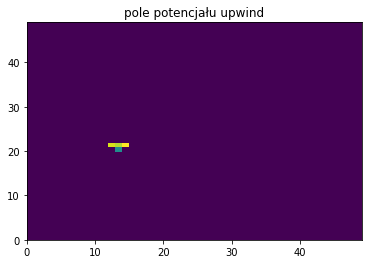

Start zejścia
Iteracja: 6
Gradient x: 0.8466997307143345
Gradient y: -6.079436036524065
Nowa pozycja 11.963398157213568 20.783968685748185


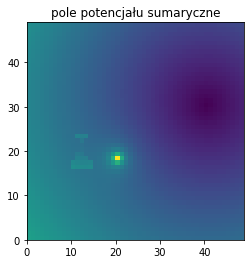

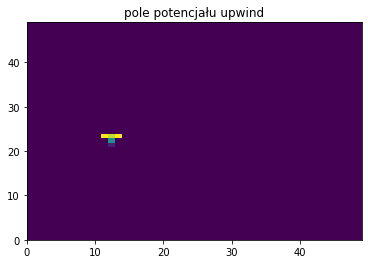

Start zejścia
Iteracja: 7
Gradient x: 0.286585216942143
Gradient y: -6.297324605735156
Nowa pozycja 11.676812940271425 22.783968685748185


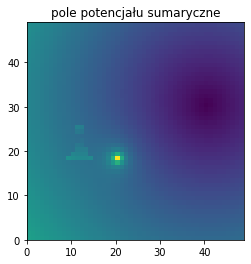

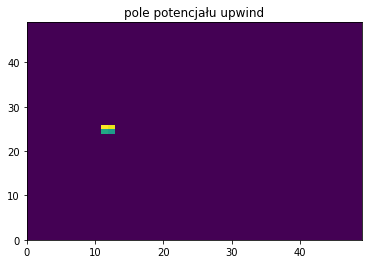

Start zejścia
Iteracja: 8
Gradient x: 0.17585212395380978
Gradient y: -5.981513355106493
Nowa pozycja 11.500960816317615 24.783968685748185


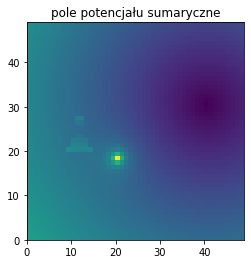

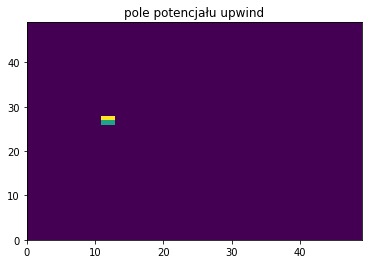

Start zejścia
Iteracja: 9
Gradient x: -2.2251770610687345
Gradient y: -5.711054502217337
Nowa pozycja 13.500960816317615 26.783968685748185


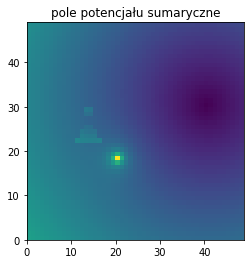

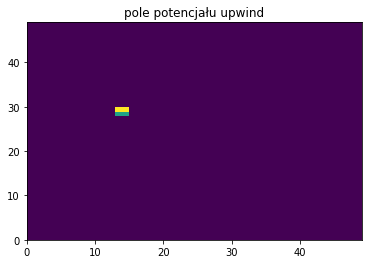

Start zejścia
Iteracja: 10
Gradient x: -2.3869849397110627
Gradient y: -5.737260682969222
Nowa pozycja 15.500960816317615 28.783968685748185


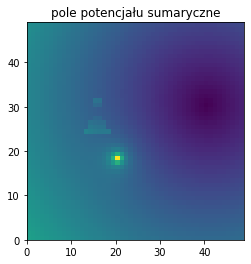

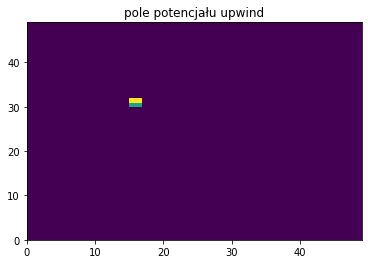

Start zejścia
Iteracja: 11
Gradient x: -2.635511868975442
Gradient y: -5.5898773203503325
Nowa pozycja 17.500960816317615 30.783968685748185


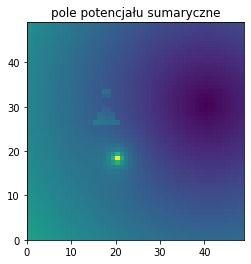

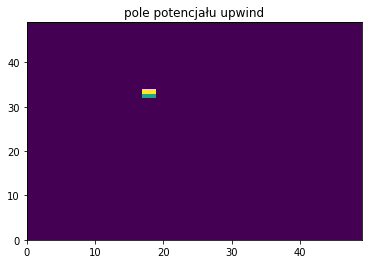

Start zejścia
Iteracja: 12
Gradient x: -2.8428723925765382
Gradient y: -5.2700621766795805
Nowa pozycja 19.500960816317615 32.783968685748185


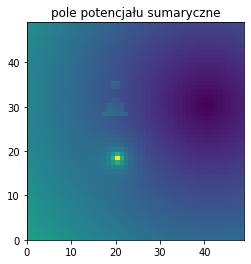

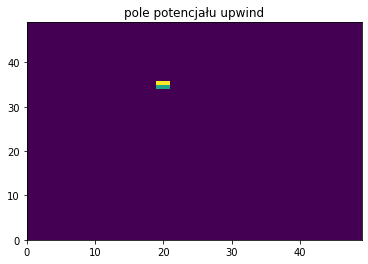

Start zejścia
Iteracja: 13
Gradient x: -2.950561522703282
Gradient y: -4.857193852220213
Nowa pozycja 21.500960816317615 34.783968685748185


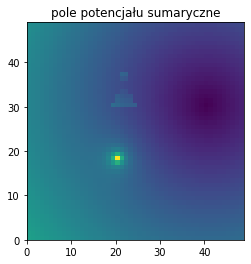

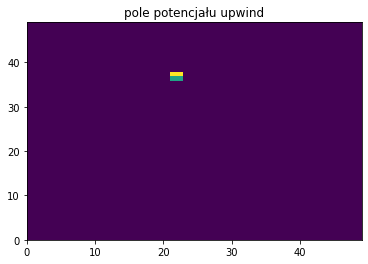

Start zejścia
Iteracja: 14
Gradient x: -2.9596153449478315
Gradient y: -4.405031989663193
Nowa pozycja 23.500960816317615 36.783968685748185


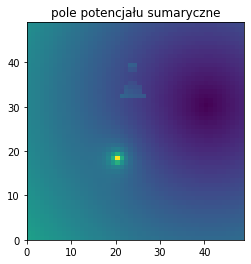

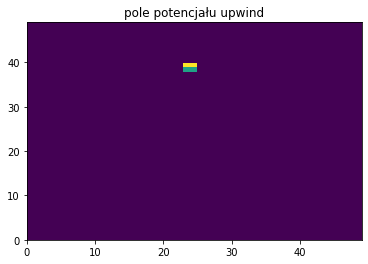

Start zejścia
Iteracja: 15
Gradient x: -2.8776451347007885
Gradient y: -3.9323797861196965
Nowa pozycja 25.500960816317615 38.783968685748185


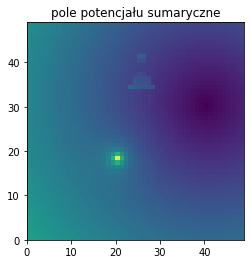

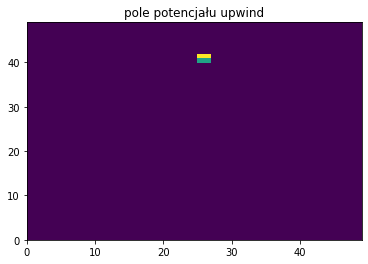

Start zejścia
Iteracja: 16
Gradient x: -2.7029284612762545
Gradient y: -3.4512927539262037
Nowa pozycja 27.500960816317615 40.783968685748185


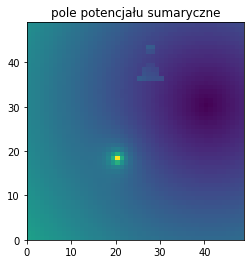

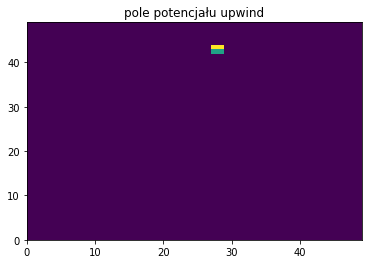

Start zejścia
Iteracja: 17
Gradient x: -2.4329776773835867
Gradient y: -2.984477357740854
Nowa pozycja 29.500960816317615 42.783968685748185


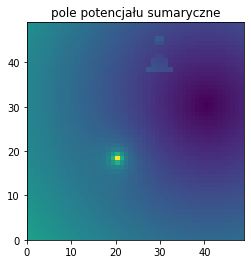

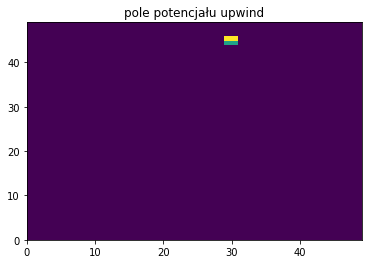

Start zejścia
Iteracja: 18
Gradient x: -2.0784417095240606
Gradient y: -2.5655407571000417
Nowa pozycja 31.500960816317615 44.783968685748185


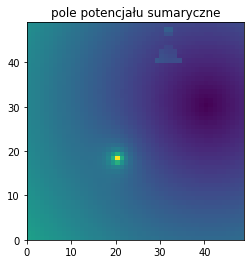

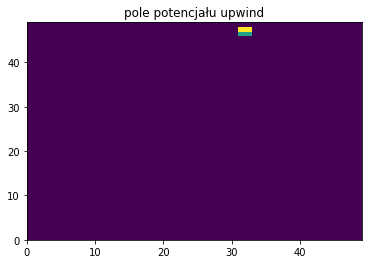

Start zejścia
Iteracja: 19
Gradient x: -1.6690222133526333
Gradient y: -2.2258736630031812
Nowa pozycja 33.16998302967025 46.783968685748185


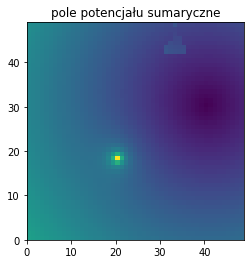

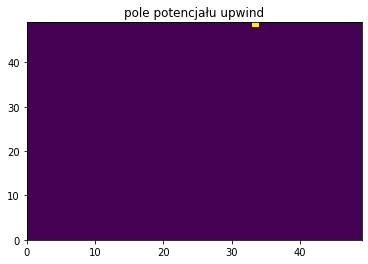

Start zejścia
Iteracja: 20
Gradient x: -1.244943492291572
Gradient y: -1.8276049627966557
Nowa pozycja 34.41492652196182 48.61157364854484


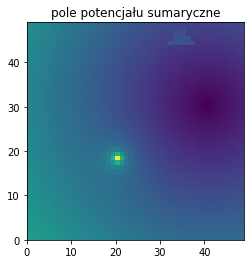

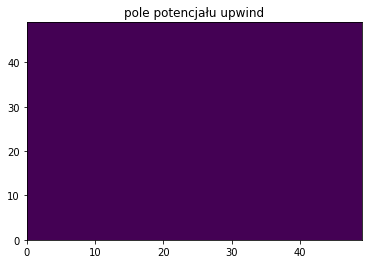

Start zejścia
Iteracja: 21
Gradient x: -0.9860467258545214
Gradient y: -1.3973976987472803
Nowa pozycja 35.40097324781634 50


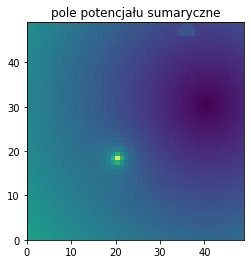

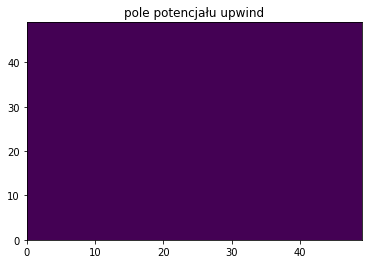

IndexError: ignored

In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys

class Punkt:
  def __init__(self, x, y):
        self.x = x
        self.y = y

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

koniec = Punkt(40, 30)           #Punkt docelowy
przeszkoda = Punkt(20, 18)       #Położenie przeszkody
Statek = Punkt(10,10)            #Pozycja startowa statku

#Generacja punktów w przestrzeni 50x50
dx = 1
X = np.arange(0, 50, dx)
Y = np.arange(0, 50, dx)
X, Y = np.meshgrid(X, Y)
#Kierunek wiatru
Wiater = 90

#print(math.degrees(math.atan(20/20)))
#Potencjał względem celu
def GoalP(Gg, koniec, X, Y):
  ZPg = []
  for i in range(len(X)):
    ZPg.append(np.zeros(len(X[i])))
  ZPg = np.array(ZPg)

  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      Pg = Gg * dist(p, koniec)
      ZPg[y, x] = Pg
  return ZPg

#Potencjał względem przeszkody
def ObstacleP(k, przeszkoda, X, Y):
  ZPo = []
  for i in range(len(X)):
    ZPo.append(np.zeros(len(X[i])))
  ZPo = np.array(ZPo)
  for x in range(len(X)):
    for y in range(len(Y)):
      p = Punkt(X[0][x], Y[y][0])
      if dist(p, przeszkoda) != 0:
        Po = k/dist(p, przeszkoda)
      else:
        Po = 200
      ZPo[y, x] = Po
  return ZPo

#Potencjał pod wiatr
def UpwindP(Gup, Statek, X, Y):
  ZPup = []
  for i in range(len(X)):
    ZPup.append(np.zeros(len(X[i])))
  ZPup = np.array(ZPup)
  aktualnyKierunekWiatru = Wiater
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      #print("Punkt x")
      #print(p.x)
      #print("Punkt y")
      #print(p.y)
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw

      if fi < -180:
        fi = 360 + fi

      if fi > 180:
        fi = 360 - fi

      if 0 <= abs(fi)< 30:
        Pup = Gup*dist(Statek, p)
      else:
        Pup = 0
        
      ZPup[y, x] = Pup
  return ZPup

#Potencjał z wiatrem
def DownwindP(Gdown, Statek, X, Y):
  ZPdown = []
  for i in range(len(X)):
    ZPdown.append(np.zeros(len(X[i])))
  ZPdown = np.array(ZPdown)
  aktualnyKierunekWiatru = Wiater

  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw

      if fi < -180:
        fi = 360 + fi

      if fi > 180:
        fi = 360 - fi

      if 0<= abs(abs(fi)-180) < 30:
        Pdown = Gdown * dist(Statek, p)
      else:
        Pdown = 0

      ZPdown[y, x] = Pdown
  return ZPdown

#Potencjał histerezy
def HysteresisP(Gh, Statek, X, Y):
  ZPh = []
  for i in range(len(X)):
    ZPh.append(np.zeros(len(X[i])))
  ZPh = np.array(ZPh)
  aktualnyKierunekWiatru = Wiater
  
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      p = Punkt(X[0][x], Y[y][0])
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw

      #Histereza dla wiatru z lewej, jeśli wiatr jest z prawej,
      #wydaje mi się że trzeba ją zmienić i dodać warunek na liczbach ujemnych
      #zależnie od tego czy aktualny kierunek - aktualny kurs jest dodatni/ujemny
      #generalnie ma wpływać na to, żeby statek za często nie zawracał
      if 45 < fi < 180 - 15:
        Ph = Gh*dist(Statek, p)
      else:
        Ph = 0
      ZPh[x, y] = Ph
  return ZPh


# Potencjał całkowity - suma pozostałych potencjałów
def Potential(Gg, Gh, Gup, Gdown, k, koniec, przeszkoda, Statek, X, Y):
  ZPg = GoalP(Gg, koniec, X, Y)
  ZPh = HysteresisP(Gh, Statek, X, Y)
  ZPup = UpwindP(Gup, Statek, X, Y)
  ZPdown = DownwindP(Gdown, Statek, X, Y)
  #for przeszkoda in tablicaPrzeszkod: #TODO: Tablica przeszkód
  # ZPo = ZPo + ObstacleP(100, przeszkoda, X, Y)
  ZPo = ObstacleP(k, przeszkoda, X, Y)
  PotentialT = ZPg + ZPdown + ZPo + ZPup # + ZPh   #Potencjal histerezy na razie nieuwzględniany

  return PotentialT

# Funkcje do tworzenia wykresów potencjałów
def plotZPg(X,Y,ZPg):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPg)
  ax.set_title("pole potencjału celu")  
  plt.show()

def plotZPo(X,Y,ZPo):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPo)
  ax.set_title("pole potencjału przeszkody") 
  plt.show()

def plotZPup(X,Y,ZPup):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPup)
  ax.set_title("pole potencjału upwind")
  plt.show()

def plotZPdown(X,Y,ZPdown):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPdown)
  ax.set_title("pole potencjału downwind")
  plt.show()

def plotZPh(X,Y,ZPh):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,ZPh)
  ax.set_title("pole potencjału histerezy")
  plt.show()

def plotZsuper(X,Y,Zsuper):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.pcolor(X,Y,Zsuper)
  ax.set_title("pole potencjału sumaryczne")
  ax.set_aspect('equal', adjustable='box')
  plt.show()

def plotAll(koniec, X, Y, przeszkoda, Statek):
  ZPg = GoalP(3, koniec, X, Y)
  plotZPg(X,Y,ZPg)

  ZPo = ObstacleP(100, przeszkoda, X, Y)
  plotZPo(X,Y,ZPo)

  ZPup = UpwindP(10, Statek, X, Y)
  plotZPup(X,Y,ZPup)

  ZPdown = DownwindP(5, Statek, X, Y)
  plotZPdown(X,Y,ZPdown)

  ZPh = HysteresisP(2, Statek, X, Y)
  plotZPh(X,Y,ZPh)

  Zsuper = Potential(3, 2, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
  plotZsuper(X,Y,Zsuper)

def plotSum(X,Y,PotentialT):
  plotZsuper(X,Y,PotentialT)

DaneX=[]
DaneY=[]
Z = []

#szukanie minimum metodą gradient descent
def grad_descent(StatekInit, alpha):
    EPS = 1e-5
    StatekPrev = Punkt(StatekInit.x-10*EPS, StatekInit.y-10*EPS)
    Statek = StatekInit
    
    max_iter = 30
    iter = 0
 
    while iter < max_iter and dist(Statek, koniec) > 3: 
        StatekPrev = Statek

        PotentialT = Potential(3, 1, 10, 5, 100, koniec, przeszkoda, Statek, X, Y)
        ZPup = UpwindP(10, Statek, X, Y)
        #tworzenie wykresu potencjału całkowitego w każdej iteracji
        #funkcje na plotowanie pojedynczych potencjałów są także zdefiniowane, więc można podejrzeć je oddzielnie
        plotSum(X,Y,PotentialT)
        plotZPup(X, Y, ZPup)
                
        Z.append(PotentialT[int(Statek.y)][int(Statek.x)])
        print('Start zejścia')
        print('Iteracja:', iter)
        gradient = np.gradient(PotentialT)
        temp = Statek.y
        gradientx = alpha*gradient[1][int(Statek.y)][int(Statek.x)]
        gradienty = alpha*gradient[0][int(temp)][int(Statek.x)]
        print('Gradient x:',gradientx)
        print('Gradient y:',gradienty)
        #ograniczenie zmian w kroku
        if abs(gradientx) > 2:
          if gradientx < 0:
            gradientx = -2
          else:
            gradientx = 2
        if abs(gradienty) > 2:
          if gradienty < 0:
            gradienty = -2
          else:
            gradienty = 2
        Statek.x -= gradientx
        Statek.y -= gradienty
        #ograniczenie przestrzeni
        if Statek.x > 50:
          Statek.x = 50
        if Statek.x < 0:
          Statek.x = 0
        if Statek.y > 50:
          Statek.y = 50
        if Statek.y < 0:
          Statek.y = 0
        DaneX.append(Statek.x)
        DaneY.append(Statek.y)
        print('Nowa pozycja', Statek.x, Statek.y)
        iter += 1
        
    return Statek, DaneX, DaneY

wynik, DaneX, DaneY = grad_descent(Statek, 1)

print('Wynik:', wynik.x, wynik.y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.azim = 270
ax.dist = 10
ax.elev = 90
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
ax.scatter(DaneX, DaneY, Z, c='red')
plt.show()


# TEST UPwind



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


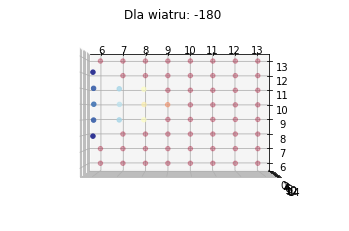

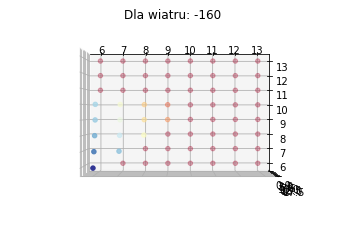

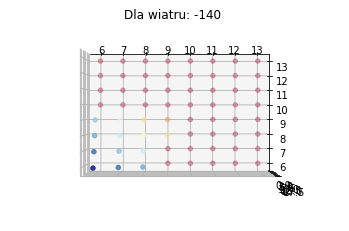

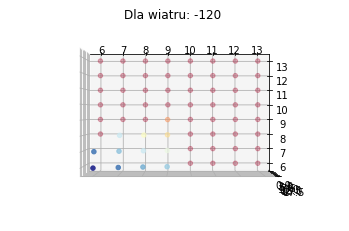

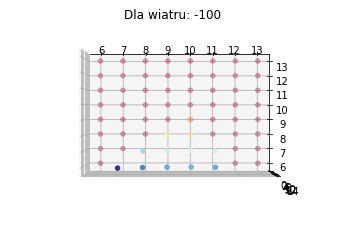

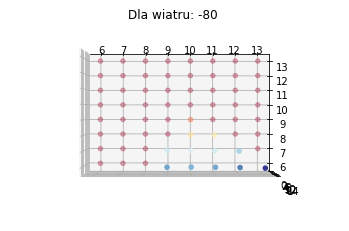

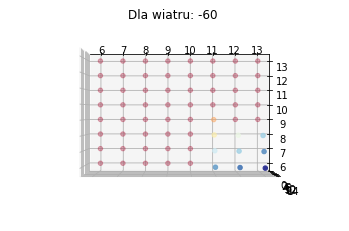

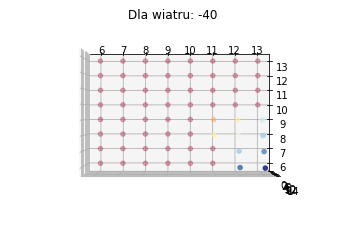

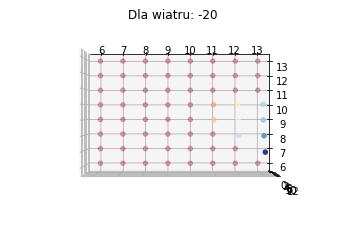

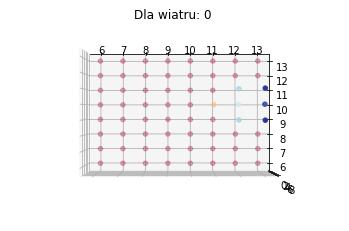

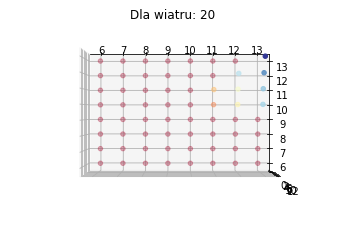

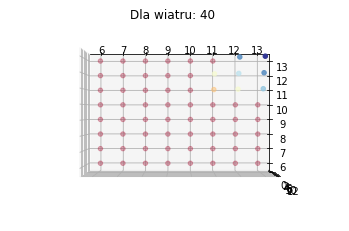

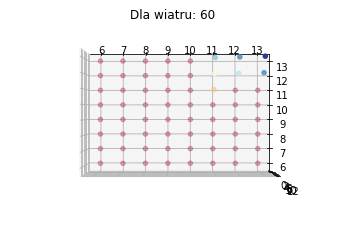

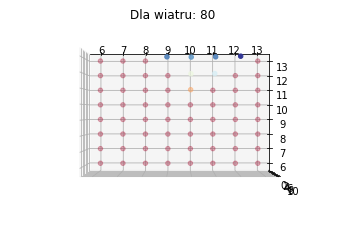

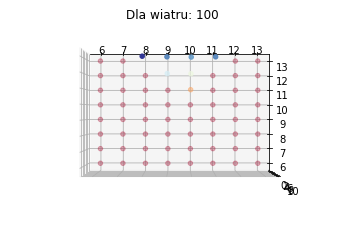

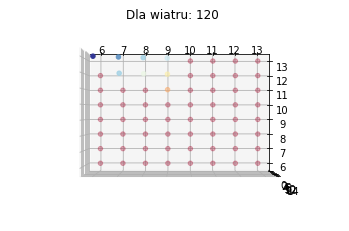

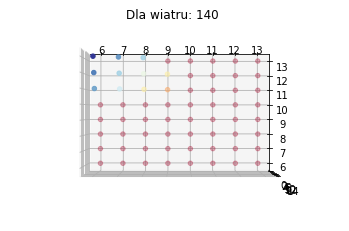

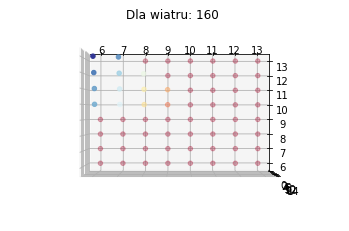

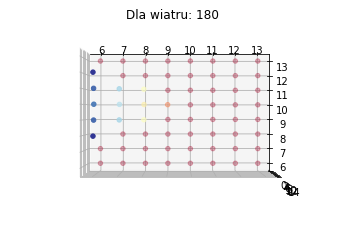

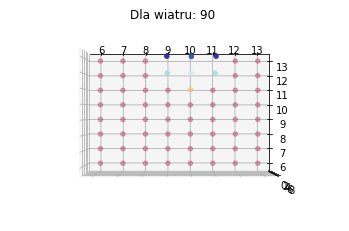

In [ ]:
def petla(aktualnyKierunekWiatru):
  Statek = Punkt(10,10)
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  X = []
  Y = []
  Z = []
  Pup = []
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw

      if fi < -180:
        fi = 360 + fi

      if fi > 180:
        fi = 360 - fi

      if 0 <= abs(fi)< 30:
        test = 3*dist(Statek, Punkt(x,y))
      else:
        test = 0

      X.append(x)
      Y.append(y)
      Z.append(fi)
      Pup.append(test)
      #print(x,y,fi,test)

  # Data for three-dimensional scattered points
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax = plt.axes(projection='3d')
  zdata = Pup
  xdata = X
  ydata = Y
  ax.azim = 270
  ax.dist = 10
  ax.elev = 90
  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='RdYlBu');
  ax.set_title('Dla wiatru: %i ' %aktualnyKierunekWiatru)
  plt.show()

for wiatr in range(-180,181,20):
  petla(wiatr) 
petla(90)

# TEST DOWNwind

In [ ]:
def petla(aktualnyKierunekWiatru):
  Statek = Punkt(10,10)
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna)

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna)

  X = []
  Y = []
  Z = []
  Pup = []
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw

      if fi < -180:
        fi = 360 + fi

      if fi > 180:
        fi = 360 - fi

      if 0<= abs(abs(fi)-180) < 30:
        test = 3*dist(Statek, Punkt(x,y))
      else:
        test = 0

      X.append(x)
      Y.append(y)
      Z.append(fi)
      Pup.append(test)
      #print(x,y,fi,test)

  # Data for three-dimensional scattered points
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax = plt.axes(projection='3d')
  zdata = Pup
  xdata = X
  ydata = Y
  ax.azim = 270
  ax.dist = 10
  ax.elev = 90
  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='RdYlBu');
  ax.set_title('Dla wiatru: %i ' %aktualnyKierunekWiatru)
  plt.show()

for wiatr in range(-180,181,20):
  petla(wiatr) 

# TEST wspólny



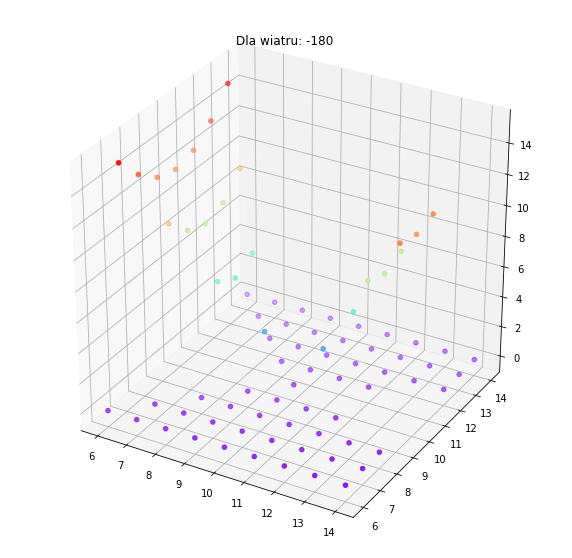

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


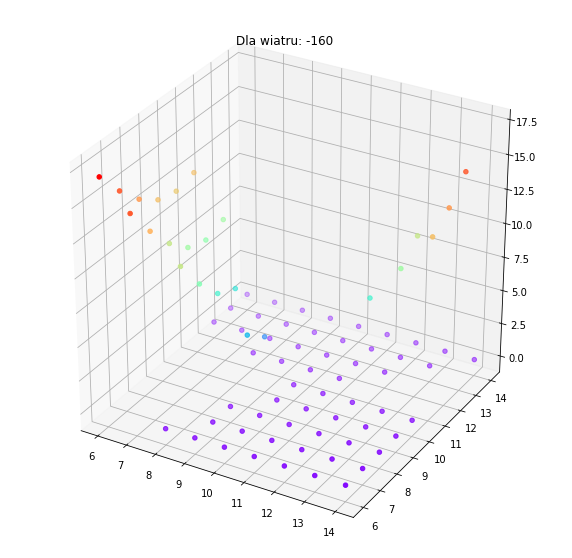

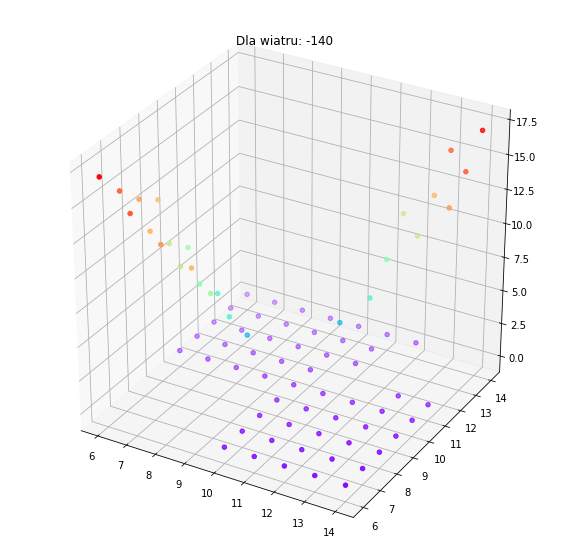

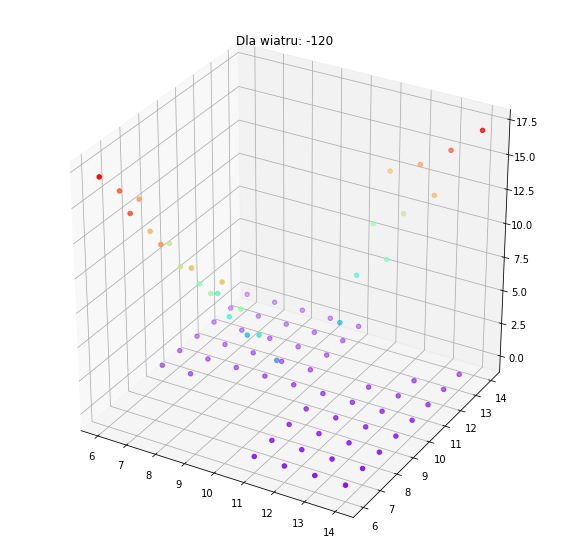

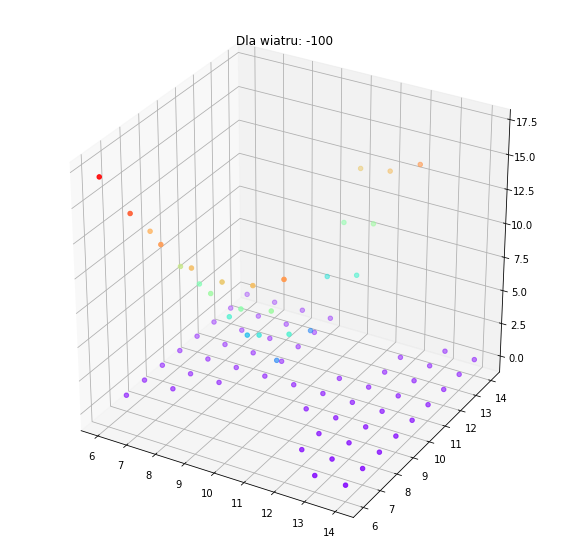

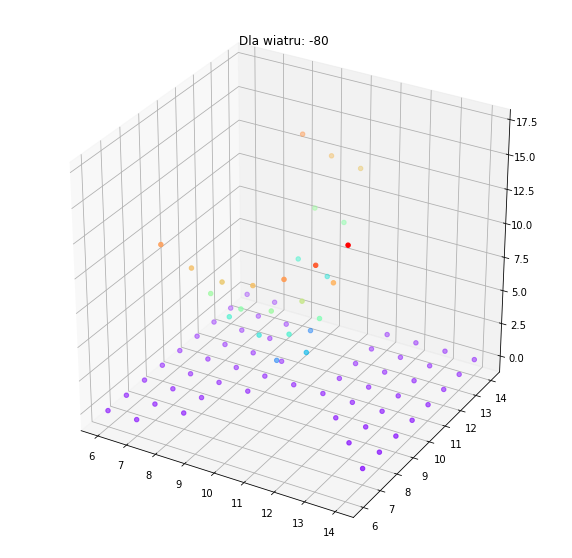

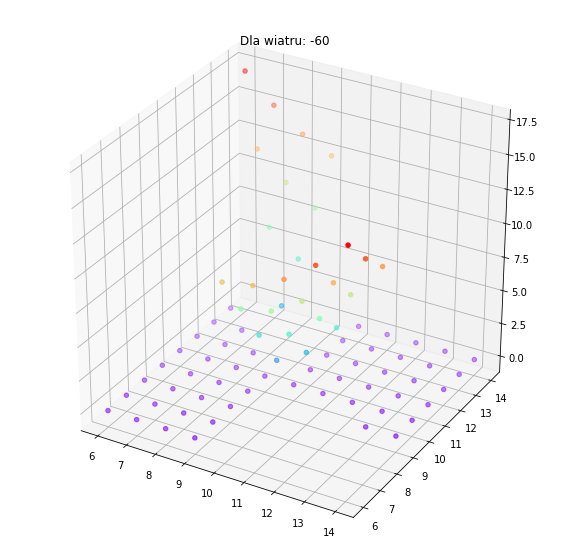

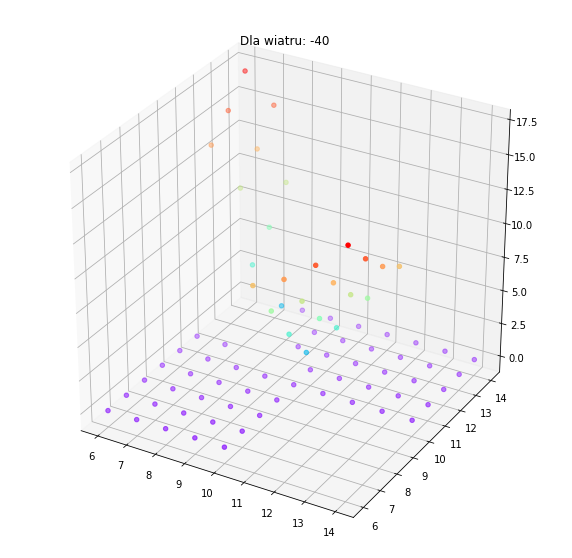

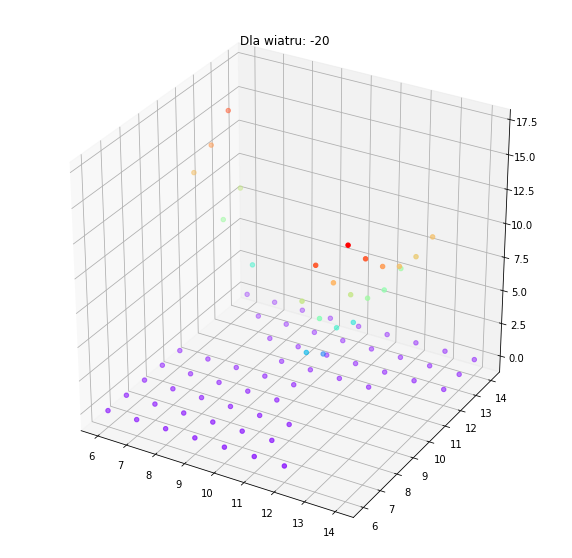

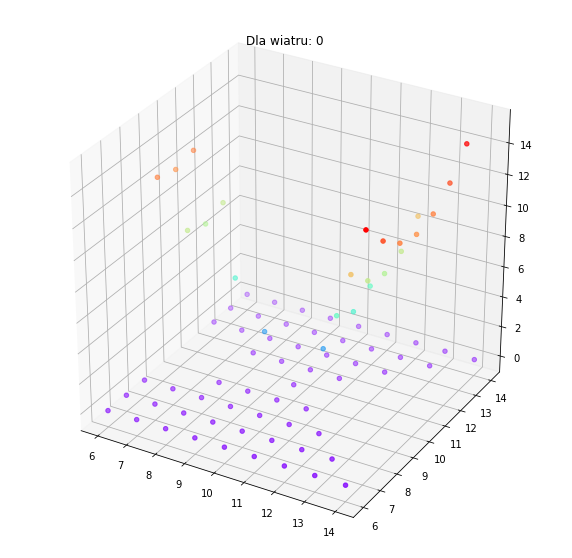

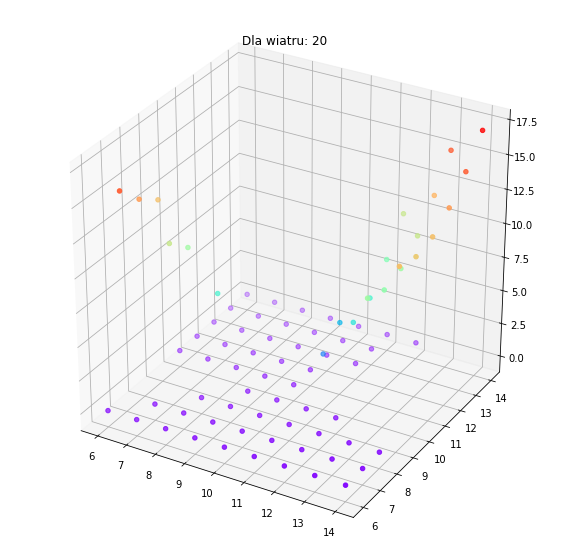

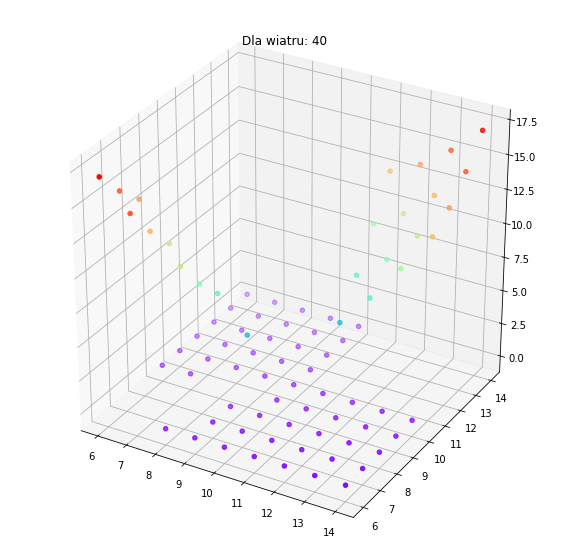

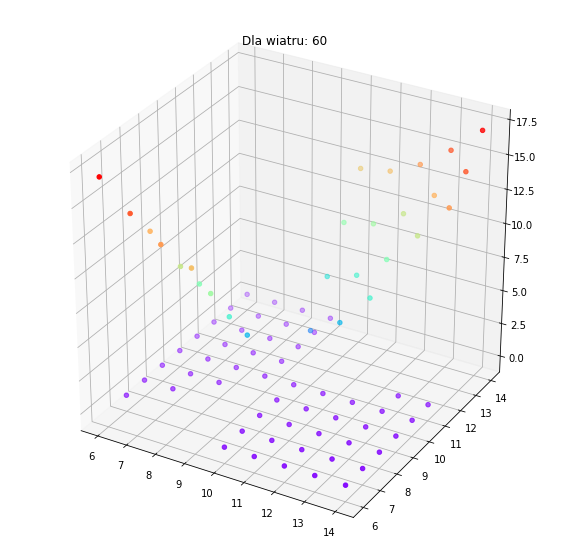

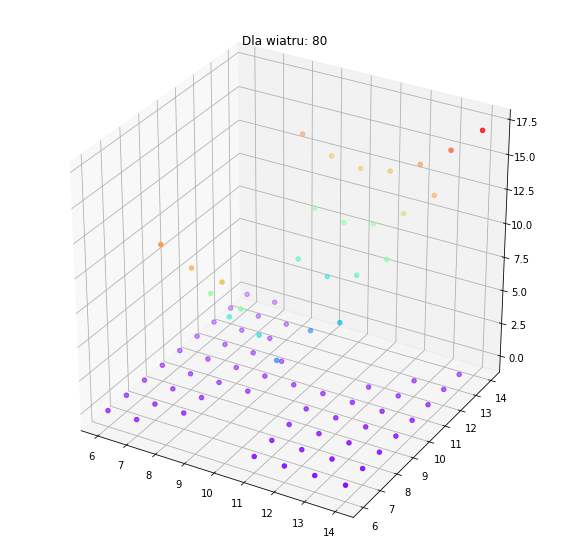

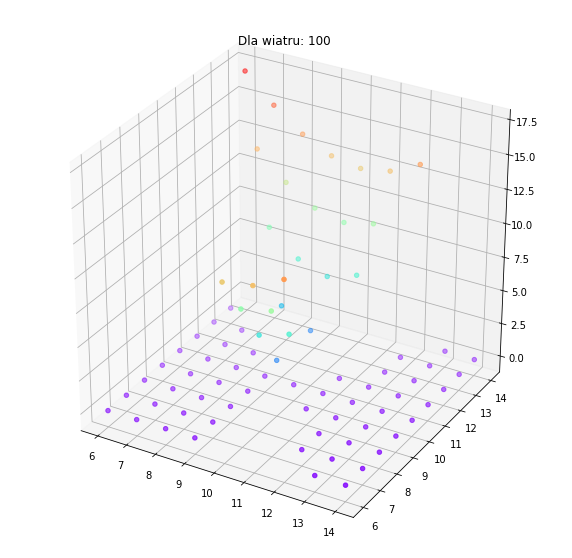

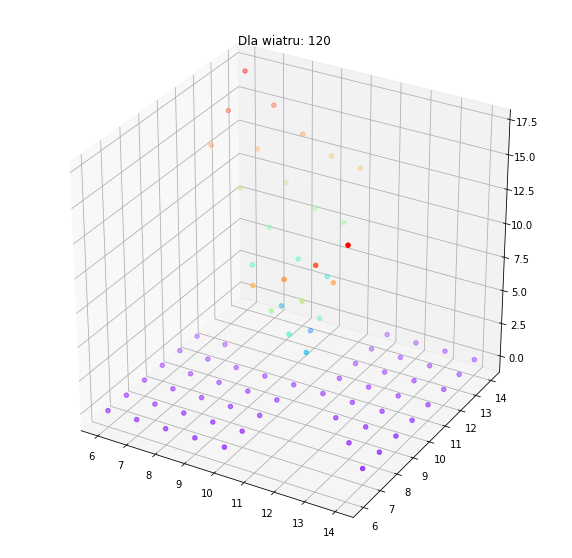

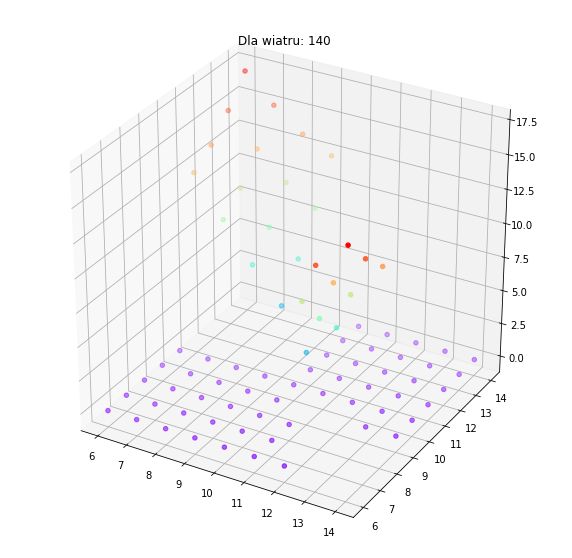

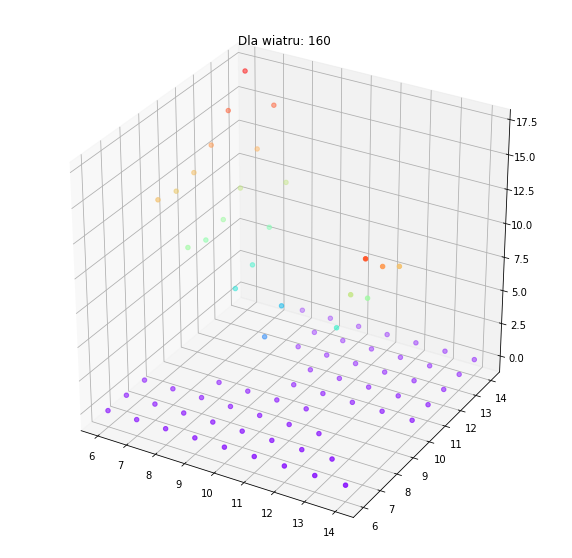

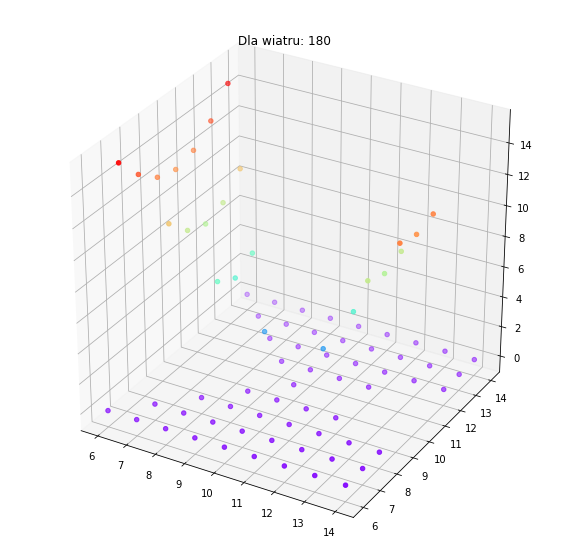

In [ ]:
def petla(aktualnyKierunekWiatru):
  Statek = Punkt(10,10)
  szerokoscOkna = 4
  if int(Statek.x + szerokoscOkna) >=50:
    c = 49
  else:
    c = int(Statek.x + szerokoscOkna) + 1

  if int(Statek.y + szerokoscOkna) >=50:
    d = 49
  else:
    d = int(Statek.y + szerokoscOkna) + 1

  X = []
  Y = []
  Z = []
  Pup = []
  for x in range(int(Statek.x - szerokoscOkna), c):
    for y in range(int(Statek.y - szerokoscOkna), d):
      aPPw = math.degrees(math.atan2(y - Statek.y, x - Statek.x))
      fi = aktualnyKierunekWiatru - aPPw

      if fi < -180:
        fi = 360 + fi

      if fi > 180:
        fi = 360 - fi

      if 0 <= abs(fi)< 40:
        test = 3*dist(Statek, Punkt(x,y))
      elif 0<= abs(abs(fi)-180) < 20:
        test = 3*dist(Statek, Punkt(x,y))
      else:
        test = 0

      X.append(x)
      Y.append(y)
      Z.append(fi)
      Pup.append(test)

  # Data for three-dimensional scattered points

  plt.subplots(figsize=(10,10))
  ax = fig.add_subplot(111)
  ax = plt.axes(projection='3d')

  zdata = Pup
  xdata = X
  ydata = Y
  #ax.azim = 270
  #ax.dist = 10
  #ax.elev = 90
  ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='rainbow')
  #ax.pcolor(xdata, ydata, zdata);
  ax.set_title('Dla wiatru: %i ' %aktualnyKierunekWiatru)
  plt.show()
  #print(ydata)

for wiatr in range(-180,181,20):
  petla(wiatr)


# Kappa i od nowa

In [ ]:
import math 
#position.y - boat.y, position.x - boat.x
angle = math.degrees(math.atan2(10 - 10, 9 - 10))
print(angle)

# 0 to prawo
# 90 to góra
# -90 to dół
# 180/-180 to lewo

180.0


Wynik: 39.300986983648684 41.6488779845066


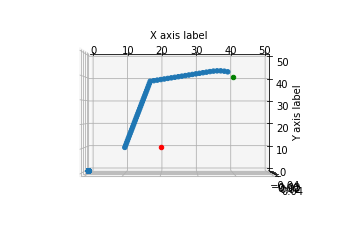

In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys

class Point:
  def __init__(self, x, y):
        self.x = x
        self.y = y

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist


#Potencjał względem celu
class Goal:
  Gg = 3
  def Potential(self, position, goal):
    Pg = self.Gg * dist(position, goal)
    return Pg

#Potencjał względem przeszkody
class Obstacle:
  k = 100
  def Potential(self, position, obstacle):
    if dist(position, obstacle) != 0:
      Po = self.k/dist(position, obstacle)
    else:
      Po = 200
    return Po

#Potencjał pod wiatr
class Upwind:
  Gup = 10
  def Potential(self, boat, position, windDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    fi = windDirection - angle

    if fi < -180:
      fi = 360 + fi
    if fi > 180:
      fi = 360 - fi

    if 0 <= abs(fi)< 30:
      Pup = self.Gup*dist(boat, position)
    else:
      Pup = 0
    return Pup

#Potencjał z wiatrem
class Downwind:
  Gdown = 10
  def Potential(self, boat, position, windDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    fi = windDirection - angle

    if fi < -180:
      fi = 360 + fi
    if fi > 180:
      fi = 360 - fi

    if 0<= abs(abs(fi)-180) < 30:
      Pdown = self.Gdown * dist(boat, position)
    else:
      Pdown = 0
    return Pdown

#Potencjał - kara za zmianę kierunku
class AngleChange:
  Gh = 0.03
  def Potential(self, boat, position, windDirection, previousDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    Ph = self.Gh * abs(previousDirection - angle)
    return Ph


DaneX=np.zeros(180)     #tablica na kolejne położenia łodzi x
DaneY=np.zeros(180)     #tablica na kolejne położenia łodzi y
window = np.zeros(180)  #tablica na wartość potencjału na okręgu wokół łodzi
X = np.zeros(180)       #tablica na x na okręgu wokół łodzi
Y = np.zeros(180)       #tablica na y na okręgu wokół łodzi

#szukanie minimum w pętli
def find_min(boat, missionGoal, obstacle, windDirection):
  max_iter = 70
  iter = 0
  GoalObject = Goal()
  ObstacleObject = Obstacle()  
  UpwindObject = Upwind() 
  DownwindObject = Downwind() 
  AngleChangeObject = AngleChange()
  previousDirection = 45
  while iter < max_iter and dist(boat, missionGoal) > 2: 
    radius = 1  #rozmiar okręgu na którym szukamy punktów
    index = 0
    DaneX[iter] = boat.x
    DaneY[iter] = boat.y
    #liczenie potencjału na okręgu dla punktów co 2 stopnie
    for angle in range(0, 360, 2):
      x = boat.x + radius*math.cos(math.radians(angle))
      y = boat.y + radius*math.sin(math.radians(angle))
      position = Point(x, y)
      GoalP = GoalObject.Potential(position, missionGoal)
      ObstacleP = ObstacleObject.Potential(position, obstacle)
      UpwindP = UpwindObject.Potential(boat, position, windDirection)
      DownwindP = DownwindObject.Potential(boat, position, windDirection)
      AngleChangeP = AngleChangeObject.Potential(boat, position, windDirection, previousDirection)
      Potential = GoalP + ObstacleP + UpwindP + DownwindP + AngleChangeP
      window[index] = Potential
      X[index] = x
      Y[index] = y
      index = index + 1

    minIndex = np.argmin(window) #indeks dla minimum na okręgu
    previousDirection = math.degrees(math.atan2(Y[minIndex] - boat.y, X[minIndex] - boat.x))
    boat.x = X[minIndex]    #zmiana pozycji statku na wyznaczone minimum
    boat.y = Y[minIndex]    #zmiana pozycji statku na wyznaczone minimum
    iter = iter + 1
  return boat


missionGoal = Point(40, 40)    #Punkt docelowy
obstacle = Point(20, 10)       #Położenie przeszkody
boat = Point(10,10)            #Pozycja startowa statku

#Kierunek wiatru
windDirection = 45

#wywołanie pętli
wynik = find_min(boat, missionGoal, obstacle, windDirection)

print('Wynik:', wynik.x, wynik.y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.azim = 270
ax.dist = 10
ax.elev = 90
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
ax.scatter(DaneX, DaneY)
ax.scatter(obstacle.x, obstacle.y, c='red')
ax.scatter(missionGoal.x, missionGoal.y, c='green')
plt.show()

In [ ]:
x = 25
y = 25
distance = 5
fi = 180
xNowe = x + distance*math.cos(math.radians(fi))
yNowe = y + distance*math.sin(math.radians(fi))

print(xNowe)
print(yNowe)
C = np.zeros(180)
i = 0
for x in range(0, 360, 2):
  C[i] = x
  i = i+1

np.argmax(C)
print(C[179])

20.0
25.0
358.0


# Poprawki Armina?

42.520220404746965
paczaj nad
Wynik: 17.954456 54.220035646071736
      Latitude  Longitude                   geometry
0    54.215056  17.954481  POINT (17.95448 54.21506)
1    54.215099  17.954456  POINT (17.95446 54.21510)
2    54.215143  17.954431  POINT (17.95443 54.21514)
3    54.215186  17.954406  POINT (17.95441 54.21519)
4    54.215229  17.954381  POINT (17.95438 54.21523)
..         ...        ...                        ...
110  54.219819  17.954431  POINT (17.95443 54.21982)
111  54.219862  17.954456  POINT (17.95446 54.21986)
112  54.219906  17.954481  POINT (17.95448 54.21991)
113  54.219949  17.954506  POINT (17.95451 54.21995)
114  54.219992  17.954481  POINT (17.95448 54.21999)

[115 rows x 3 columns]


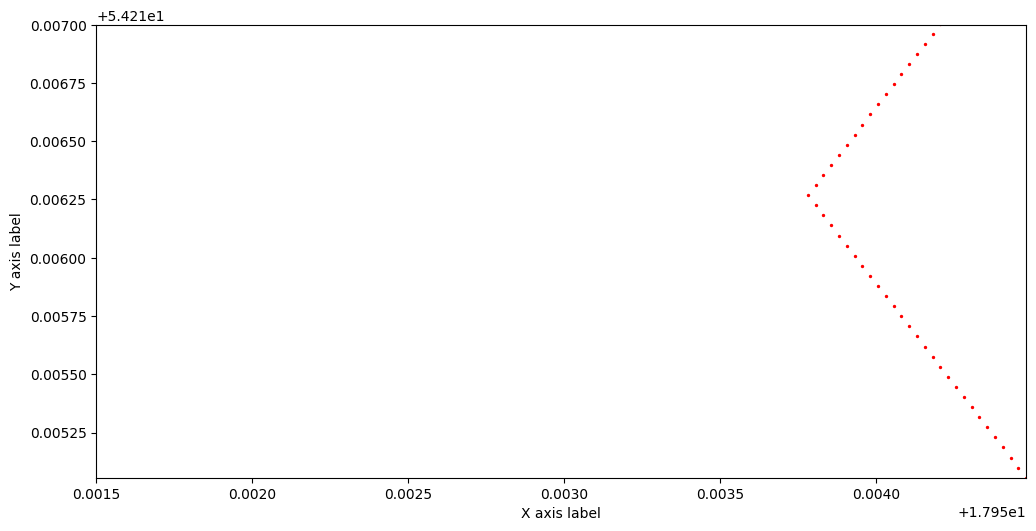

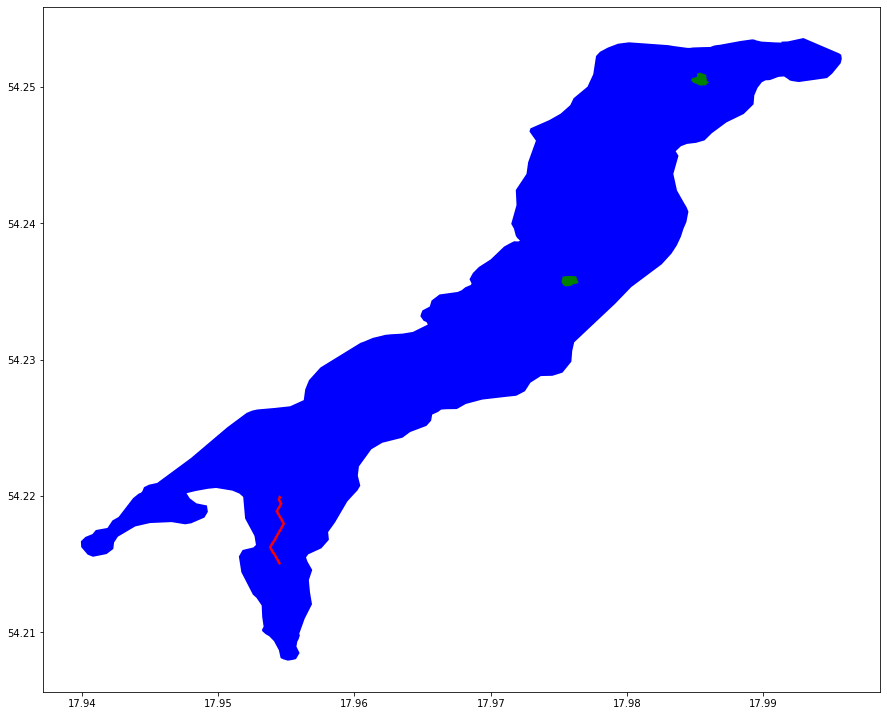

23.74


In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import pandas as pd

#class Point:
  #def __init__(self, x, y):
        #self.x = x
        #self.y = y

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

def getDistanceInMeters(pointA, pointB):
  earthRadius = 6371000
  latA = pointA.y * math.pi/180
  latB = pointB.y * math.pi/180
  diffLat = (pointA.y - pointB.y) * math.pi/180
  diffLng = (pointA.x - pointB.x) * math.pi/180
  a = math.sin(diffLat / 2) * math.sin(diffLat / 2) + math.cos(latB) * math.cos(latA) * math.sin(diffLng / 2) * math.sin(diffLng / 2)
  #b = 2 * math.asin(math.sqrt(a))
  b = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) )
  distance = round((earthRadius * b), 2)
  return distance

#Potencjały
class Potentials:
  def __init__(self, Gg=3, k=100, Gup=10, Gdown=5, Gac=0.0000004):
    self.Gg = Gg
    self.k = k
    self.Gup = Gup
    self.Gdown = Gdown
    self.Gac = Gac

  #Potencjał względem celu
  def PotentialGoal(self, position, goal):
      Pg = self.Gg * dist(position, goal)
      return Pg
  
  #Potencjał względem przeszkody
  def PotentialObstacle(self, position, obstacle):
    if dist(position, obstacle) != 0:
      Po = self.k/dist(position, obstacle)
    else:
      Po = 200
    return Po

  #Potencjał pod wiatr
  def PotentialUpwind(self, boat, position, windDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    fi = windDirection - angle

    if fi < -180:
      fi = 360 + fi
    if fi > 180:
      fi = 360 - fi

    if 0 <= abs(fi)< 30:
      Pup = self.Gup*dist(boat, position)
    else:
      Pup = 0
    return Pup

  #Potencjał z wiatrem
  def PotentialDownwind(self, boat, position, windDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    fi = windDirection - angle

    if fi < -180:
      fi = 360 + fi
    if fi > 180:
      fi = 360 - fi

    if 0<= abs(abs(fi)-180) < 30:
      Pdown = self.Gdown * dist(boat, position)
    else:
      Pdown = 0
    return Pdown    

  #Potencjał - kara za zmianę kierunku
  def PotentialAngleChange(self, boat, position, windDirection, previousDirection):
      angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
      if abs(previousDirection - angle) > 180:
        Pac = self.Gac * (360-abs(previousDirection - angle))
      else:
        Pac = self.Gac * abs(previousDirection - angle)
      return Pac

  #Suma Potencjałów 
  def PotentialSum(self, boat, position, goal, obstacle, windDirection, previousDirection):
      GoalP = Potentials.PotentialGoal(position, goal)
      ObstacleP = Potentials.PotentialObstacle(position, obstacle)
      UpwindP = Potentials.PotentialUpwind(boat, position, windDirection)
      DownwindP = Potentials.PotentialDownwind(boat, position, windDirection)
      AngleChangeP = Potentials.PotentialAngleChange(boat, position, windDirection, previousDirection)
      Psum = GoalP + ObstacleP + UpwindP + DownwindP + AngleChangeP
      return Psum

DaneX=np.zeros(1800)       #tablica na kolejne położenia łodzi x
DaneY=np.zeros(1800)       #tablica na kolejne położenia łodzi y
window = np.zeros(180)    #tablica na wartość potencjału na okręgu wokół łodzi
X = np.zeros(180)         #tablica na x na okręgu wokół łodzi
Y = np.zeros(180)         #tablica na y na okręgu wokół łodzi
Potentials = Potentials() #można podać parametry w kontruktorze


#szukanie minimum w pętli
def find_min(boat, goal, obstacle, windDirection):
  max_iter = 300
  iter = 0
  previousDirection = 135
  radius = 0.00005  #rozmiar okręgu na którym szukamy punktów 3,96m
  radius2 = 0.0003
  shape_number = geoTransform.geometry.size
  xD = geoTransform.geometry.boundary.buffer(radius2)


  while iter < max_iter and getDistanceInMeters(boat, goal) > 5: 
    radius = 0.00005
    for c in range(0, shape_number):
      if xD.loc[c].contains(boat):
        radius = 0.0009
    index = 0
    #print(radius)
    DaneX[iter] = boat.x
    DaneY[iter] = boat.y
    #liczenie potencjału na okręgu dla punktów co 2 stopnie
    for angle in range(0, 360, 2):
      x = boat.x + radius*math.cos(math.radians(angle))
      y = boat.y + radius*math.sin(math.radians(angle))
      position = Point(x, y)
      check_land = 0
      for b in range(0, shape_number):
        #if geoTransform.boundary.distance(position)[x] < radius2:
        #if geoTransform.loc[b].geometry.boundary.buffer(radius2).contains(position):
        if xD.loc[b].contains(position):

          check_land = 1
      if geoTransform.distance(position)[0] > 0:
        check_land = 1
      if check_land == 1:
        Potential = 100000
      else:
        Potential = Potentials.PotentialSum(boat, position, goal, obstacle, windDirection, previousDirection)
      window[index] = Potential
      X[index] = x
      Y[index] = y
      index = index + 1
    minIndex = np.argmin(window) #indeks dla minimum na okręgu
    #print("index min")
    #print(minIndex)
    #print("wartość dla min")
    #print(window[minIndex])
    previousDirection = math.degrees(math.atan2(Y[minIndex] - boat.y, X[minIndex] - boat.x))
    boat = Point(X[minIndex], Y[minIndex])
    #print("dystans dla min")
    #print(geoTransform.distance(boat)[0])
    #boat.x = X[minIndex]    #zmiana pozycji statku na wyznaczone minimum
    #boat.y = Y[minIndex]    #zmiana pozycji statku na wyznaczone minimum
    iter = iter + 1
    #hah = getDistanceInMeters(boat, goal)
    #print(hah)
  return boat


#goal = Point(17.949000,54.223725)           #Punkt docelowy

goal = Point(17.954481,54.220056) 
obstacle = Point(60.959218,60.220071)       #Położenie przeszkody
boat = Point(17.954481,54.215056)           #Pozycja startowa statku
anglexD = math.degrees(math.atan2(54.238807 - 54.231992, 17.978563 - 17.971131))
print(anglexD)
print("paczaj nad")
#Kierunek wiatru
windDirection = 90

#wywołanie pętli
wynik = find_min(boat, goal, obstacle, windDirection)

print('Wynik:', wynik.x, wynik.y)

fig = plt.figure(figsize=(12,6), dpi=100)
ax = fig.add_subplot(111)
ax.azim = 270
ax.dist = 10
ax.elev = 90
plt.xlim([17.951500, 17.954481])
plt.ylim([54.215056, 54.217000])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
ax.scatter(DaneX, DaneY, s=2, c='red')
#ax.scatter(obstacle.x, obstacle.y, c='red')
#ax.scatter(goal.x, goal.y, c='green')
#circleGoal = plt.Circle((goal.x, goal.y), 0.00005, color='green', fill=False)
#ax.add_patch(circleGoal)
#plt.show()
SD = Point(18.767241,54.206447)
def printPoly(data):
  gdf = data
  gdf['color'] = ['b', 'g', 'g']
  gdf.plot(color=gdf['color'], figsize=(10, 10))
kappa_licznik = 0
for x in range(0, 1800):
  if DaneX[x] != 0:
    kappa_licznik = kappa_licznik + 1
df = pd.DataFrame(
    {'Latitude': DaneY[0:kappa_licznik],
     'Longitude': DaneX[0:kappa_licznik]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
# We restrict to South America.
gdf1 = geoTransform
gdf1['color'] = ['b', 'g', 'g']
base = gdf1.plot(color=gdf1['color'], figsize=(15, 15))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=base, color='red', markersize=1)
print(gdf.head(1800))

plt.show()
radius = 0.0003 
angle = 30  
nx = 18.767241+radius*math.cos(math.radians(angle))
ny = 54.206447+radius*math.sin(math.radians(angle))       
GZ = Point(nx, ny) 
hah = getDistanceInMeters(SD, GZ)
print(hah)



# Hals po prostokącie

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Point:
  def __init__(self, x, y):
        self.x = x
        self.y = y

def Tacking(Wind, Distanse, zwroty):
    #Obliczenie kątów halsu
    alfa = 45 + Wind
    beta = 45 - Wind
    sum = 0
    heuristic = 1 #bazowa heurystyka dla 45 stopni

    while abs(sum - Distanse) > 1: #pętla aktualizacji heurystyki
      BaseLength = heuristic * 0.2 * Distanse #Obliczenie podstawy prostokąta

      FirstTack = 1/2 * BaseLength / math.cos(math.radians(90-alfa)) #Obliczenie długości trasy halsem
      StarboartTack =  BaseLength / math.cos(math.radians(90-beta))
      PortTack = BaseLength / math.cos(math.radians(90-alfa))
      LastTack = 1/2 * BaseLength / math.cos(math.radians(90-beta))

      PlannedDistanceFirst = FirstTack * math.sin(math.radians(90-alfa)) #Obliczenie przebytego dystansu do celu
      PlannedDistance2 = StarboartTack * math.sin(math.radians(90-beta))
      PlannedDistance3 = PortTack * math.sin(math.radians(90-alfa))
      PlannedDistanceLast = LastTack * math.sin(math.radians(90-beta))
      Tack = [PlannedDistance2, PlannedDistance3]

      sum = PlannedDistanceFirst + zwroty/2 * Tack[0] + zwroty/2 * Tack[1] + PlannedDistanceLast #Suma przebytego dystansu
      heuristic = Distanse / sum  #Aktualizacja heurystyki

    # Wyznaczenie punktów zwrotu
    list = [] 
    list.append(Point(0,0))
    list.append(Point(BaseLength, PlannedDistanceFirst))

    znak = -1
    Distance = PlannedDistanceFirst
    for i in range(1,zwroty+1):
      m = (i+1)%2
      Distance = Distance + Tack[m]
      list.append(Point (znak * BaseLength, Distance))
      znak = znak * -1

    list.append(Point(0, sum))

    return list

Wind = 0 # Wiatr zadawany jako względem kursu w zakresie od -40 do 40
Distanse = 100 # Odległość w metrach od punktu docelowego
zwroty = 4  # Ilość zmian halsu (musi byc parzysta)

if zwroty%2 == 1:
  zwroty = zwroty +1
  
Points = Tacking(Wind, Distanse,zwroty)

DaneX = np.zeros(3+zwroty)     
DaneY = np.zeros(3+zwroty)   
iter = 0

for element in Points:
  DaneX[iter] = element.x
  DaneY[iter] = element.y
  iter = iter +1

fig = plt.figure()
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
plt.plot(DaneX, DaneY)
plt.show()
print(Points[0].x)
for i in range(zwroty+3):
  print(Points[i].x)
  print(Points[i].y)  

# Algorytm Warunkowy + Stanley Controller


Kat zadany =  63.434948822922074 1.1071487177940915
Kat aktualny =  10
0.9326157925946585
Ustawienie steru =  0


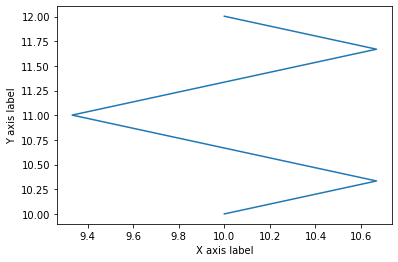

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

class Point:
  def __init__(self, x, y):
        self.x = x
        self.y = y

#Odleglosc Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

#Algorytm halsu
def tackingAlgorithm(Wind, Distanse, zwroty, windType):
    #Obliczenie katow halsu
    alfa = windType + Wind
    beta = windType - Wind
    sum = 0
    heuristic = 1 #bazowa heurystyka dla 45 stopni

    while abs(sum - Distanse) > 1: #petla aktualizacji heurystyki
      BaseLength = heuristic * 0.2 * Distanse #Obliczenie podstawy prostokata

      FirstTack = 1/2 * BaseLength / math.cos(math.radians(90-alfa)) #Obliczenie dlugosci trasy halsem
      StarboartTack =  BaseLength / math.cos(math.radians(90-beta))
      PortTack = BaseLength / math.cos(math.radians(90-alfa))
      LastTack = 1/2 * BaseLength / math.cos(math.radians(90-beta))

      PlannedDistanceFirst = FirstTack * math.sin(math.radians(90-alfa)) #Obliczenie przebytego dystansu do celu
      PlannedDistance2 = StarboartTack * math.sin(math.radians(90-beta))
      PlannedDistance3 = PortTack * math.sin(math.radians(90-alfa))
      PlannedDistanceLast = LastTack * math.sin(math.radians(90-beta))
      Tack = [PlannedDistance2, PlannedDistance3]

      sum = PlannedDistanceFirst + zwroty/2 * Tack[0] + zwroty/2 * Tack[1] + PlannedDistanceLast #Suma przebytego dystansu
      heuristic = Distanse / sum  #Aktualizacja heurystyki

    # Wyznaczenie punktów zwrotu
    list = [] 
    list.append(Point(0,0))
    list.append(Point(BaseLength, PlannedDistanceFirst))

    znak = -1
    Distance = PlannedDistanceFirst
    for i in range(1,zwroty+1):
      m = (i+1)%2
      Distance = Distance + Tack[m]
      list.append(Point (znak * BaseLength, Distance))
      znak = znak * -1

    list.append(Point(0, sum))

    return list

#Limity wiatru
def windLimit(wind):
  if wind < -180:
    wind = 360 + wind
  if wind > 180:
    wind = - 360 + wind
  return wind

#limity kursu
def yawLimit(alfa):
  if alfa < -math.pi:
    alfa = 2 * math.pi + alfa
  if alfa > math.pi:
    alfa = - 2 * math.pi + alfa
  return alfa

#Lista dla dwoch punktow
def directPoints(position, goal):
  list = [] 
  list.append(position)
  list.append(goal)

  return list

#Obliczenie kursu bezposredniego radiany
def directCourseRad(position, goal):
  K = math.pi/2 - math.atan2(goal.y - position.y, goal.x - position.x) 
  return K

#Obliczenie kursu bezposredniego stopnie
def directCourseDeg(position, goal):
  K = math.pi/2 - math.atan2(goal.y - position.y, goal.x - position.x) 
  K = math.degrees(K)
  return K 

#Obliczenie dystansu w metrach na podstawie dwoch punktow geografcznych
def getDistanceInMeters(pointA, pointB):
  earthRadius = 6371000
  latA = pointA.y * math.pi/180
  latB = pointB.y * math.pi/180
  diffLat = (pointA.y - pointB.y) * math.pi/180
  diffLng = (pointA.x - pointB.x) * math.pi/180
  a = math.sin(diffLat / 2) * math.sin(diffLat / 2) + math.cos(latB) * math.cos(latA) * math.sin(diffLng / 2) * math.sin(diffLng / 2)
  b = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) )
  distance = round((earthRadius * b), 2)
  return distance

#Obliczenie wspolrzednych geograficznych dla odleglosci w metrach
def getGeoPoint(point, distance):
  Xnew = distance.x * 0.00001 / 1.11 #Przesuniecie na ułamki sekund i skala
  Ynew = distance.y * 0.00001 / 1.11
  newPoint = Point(point.x + Xnew, point.y + Ynew)

  return newPoint

#Transformacje przestrzeni punktow w metrach na punkty geolokacyjne
def getGeoTransform(Points,position):
  list = [] 
  first = Points.pop(0)
  firstGeo = Point(first.x + position.x, first.y + position.y)
  list.append(firstGeo)

  while Points:
    next = Points.pop(0)
    nextGeo = getGeoPoint(firstGeo, next)
    list.append(nextGeo)

  return list

#Rotacja uzyskanego halsu dla zadanego kursu
def getPointsRotation(points, yaw):
  list = [] 
  alfa = math.radians(-yaw)
  rotationMatrix = np.array( [[ math.cos(alfa), -math.sin(alfa) ],[ math.sin(alfa), math.cos(alfa)]] )

  for point in points:
    xNew = math.cos(alfa) * point.x - math.sin(alfa) * point.y
    yNew = math.sin(alfa) * point.x + math.cos(alfa) * point.y
    newPoint = Point(xNew,yNew)
    list.append(newPoint)
  return list

def stanleyController(startPoint,goal,yaw):
  #Obliczenie kąta pożądanego
  yaw_ref = math.pi/2 - math.atan2(goal.y - startPoint.y, goal.x - startPoint.x) 
  yaw_ref = yawLimit(yaw_ref)
  print('Kat zadany = ', math.degrees(yaw_ref), yaw_ref)
  print('Kat aktualny = ', yaw)
  #Różnica między kątem pożądanym, a rzeczywistym
  yaw_diff = ( yaw_ref - math.radians(yaw) ) 
  print(yaw_diff)

  if yaw_diff > math.pi:
      yaw_diff = yaw_diff - 2 * math.pi
  elif yaw_diff < - math.pi:
      yaw_diff = yaw_diff + 2 * math.pi

  theta_deg = - math.degrees(yaw_diff) * 5 #Mozliwe ze trzeba odwrocic
  theta_deg = 50 + theta_deg #przeniesienie środka na 50 z 0

  if theta_deg <= 0:
      theta_deg = 0

  if theta_deg >= 100:
      theta_deg = 100  

  return theta_deg

def debugPoint(Points):
  print('Wyswietlam punkty')
  for element in Points:
    print(element.x)
    print(element.y)

def debugStanley(Points,boat,yaw):
  #Wywolywany cyklicznie
  #Pierwsze wykonanie
  StanleyPoints = copy.copy(Points)
  start = []
  if not start:
    start = StanleyPoints.pop(0)
    goal = StanleyPoints.pop(0)

  if getDistanceInMeters(boat, goal) < 5: #Osiagniecie punktu docelowego
    if not StanleyPoints: #Przerwanie, dotarliśmy do celu
      print('Osiagnieto CEL')
    else: #Nowy cel
      print('Obrano nowy CEL')
      start = goal
      goal = StanleyPoints.pop(0) 

  theta = stanleyController(start,goal,yaw)
  print('Ustawienie steru = ', theta)

################################################################################

#Inicjalizacja algorytmu
boat = Point(10.00000, 10.00000) #from GPS
goal = Point(10.00000, 12.00000) #from Node-RED

#Parametry
upWind = 44
downWind = 20
zwroty = 2
windDirection = -10 #from MCS
yaw = 10 #from MCS

#ALGORYTM
#Obliczenie parametrów punktu docelowego
distanse = getDistanceInMeters(boat,goal)
directCourse = directCourseDeg(boat,goal)

#Obliczenie kąta wiatru dla kursu bezpośredniego do celu
globalWindDirection = yaw + windDirection #zmienic
globalWindDirection = windLimit(globalWindDirection)
windDirectionForDirectCourse = globalWindDirection - directCourse 
windDirectionForDirectCourse = windLimit(windDirectionForDirectCourse)

if abs(windDirectionForDirectCourse) < upWind: #Sprawdzenie warunkow pod wiatr
  Points = tackingAlgorithm(windDirectionForDirectCourse, distanse, zwroty, 45)
  Points = getPointsRotation(Points,directCourse) 
  Points = getGeoTransform(Points,boat)

  DaneX = np.zeros(3+zwroty)      #na potrzeby wizualizacji  
  DaneY = np.zeros(3+zwroty)   #na potrzeby wizualizacji  
elif abs(abs(windDirectionForDirectCourse)-180) < downWind:  
  Points = tackingAlgorithm(windDirectionForDirectCourse, distanse, zwroty, 20)
  Points = getPointsRotation(Points,directCourse)
  Points = getGeoTransform(Points,boat)

  DaneX = np.zeros(3+zwroty)   #na potrzeby wizualizacji  
  DaneY = np.zeros(3+zwroty)   #na potrzeby wizualizacji  
else: #Kurs bezposredni
  Points = directPoints(boat, goal)

  DaneX = np.zeros(2)    #na potrzeby wizualizacji    
  DaneY = np.zeros(2)   #na potrzeby wizualizacji  

#STANLEY
debugStanley(Points,boat,yaw)

#WIZUALIZACJA
iter = 0

for element in Points:
  DaneX[iter] = element.x
  DaneY[iter] = element.y
  iter = iter +1

fig = plt.figure()
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
plt.plot(DaneX, DaneY)
plt.show()  


# Algorytm Rozmyty kontroli przechylu

rudderChange -17.88461538461539
sailChange -11.176470588235293
Wykres konkluzji:
Wykres konkluzji:
0    0.003902
1    0.005392
2    0.011415
dtype: float64


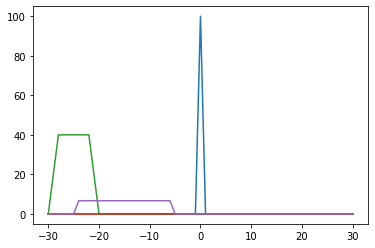

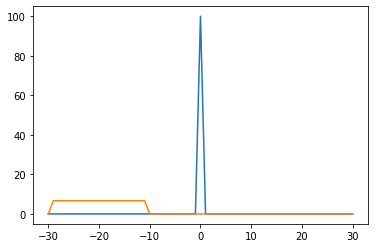

In [ ]:
#Algorytm Rozmyty kontroli przechylu

# S-ksztaltna funkcja przynaleznosci
def sMF(x,points):
  leftpoint = points[0]
  rightpoint = points[1]

  if x <= leftpoint:
    xfuzzy = 0
  elif x < rightpoint:
    xfuzzy = ((x - leftpoint)*100) / (rightpoint - leftpoint)
  elif x >= rightpoint:
    xfuzzy = 100
  return xfuzzy

# Z-ksztaltna funkcja przynaleznosci
def zMF(x,points):  
  leftpoint = points[0]
  rightpoint = points[1]

  if x <= leftpoint:
    xfuzzy = 100
  elif x < rightpoint:
    xfuzzy = ((rightpoint - x)*100) / (rightpoint - leftpoint)
  elif x >= rightpoint:
    xfuzzy = 0
  return xfuzzy

# Trojkatna funkcja przynaleznocci
def triMF(x, points):
  leftpoint = points[0]
  centerpoint = points[1]
  rightpoint = points[2]

  if x <= leftpoint or x >= rightpoint:
    xfuzzy = 0
  elif x <= centerpoint:
    xfuzzy = ((x - leftpoint)*100) / (centerpoint - leftpoint)
  elif x < rightpoint:
    xfuzzy = ((rightpoint - x)*100) / (rightpoint - centerpoint)
  return xfuzzy

#Trojkatna funkcja konkluzji
def gettriMFConclusion(outputrange,points,fuzzyvalue):
  conclusionPlot = [0] * len(outputrange)
  iter = 0
  for i in outputrange:
    iter = iter + 1
    conclusionPlot[i]= min(triMF(i,points),fuzzyvalue)
  return conclusionPlot

#Singletonowa funkcja konkluzji
def getSingleMFConclusion(outputrange):
  conclusionPlot = [0] * len(outputrange)
  iter = 0
  for i in outputrange:
    if i == 0:
      conclusionPlot[iter]= 100
    else:
      conclusionPlot[iter]= 0
    iter = iter + 1
    
  return conclusionPlot

#Wyostrzanie metodą Centroid
def defuzzificationCentroid(fuzzyoutput):
  num = 0
  den = 0
  for i in range(len(fuzzyoutput)):
    num += i * fuzzyoutput[i]
  for i in range(len(fuzzyoutput)):
    den += fuzzyoutput[i]
  result = num / den
  return result

#Agregacja koknluzji
def AggregateConclusions(conclusions):
  outputrange = len(conclusions[0])
  fuzzyoutput = [0] * outputrange
  numberofconclusions= len(conclusions)
  comparearray = [0] * numberofconclusions

  for i in range(outputrange):
    for j in range(numberofconclusions):
      comparearray[j] = conclusions[j][i]
    fuzzyoutput[i]=max(comparearray)

  return fuzzyoutput

#Operator and - min
def fuzzyAnd(ruleA,ruleB):
  result = min(ruleA,ruleB)
  return result

#Operator or - max
def fuzzyOr(ruleA,ruleB):
  result = max(ruleA,ruleB)
  return result

#Przeslanki
Safe = [0, 30]
Dangerous = [20, 30, 40]
Risky  = [35,50]

WindPort = [0,10]
WindStarboard = [-10,0]


#Konkluzje
RudderZero = 0
SailZero = 0
CounterRudderPortLight = [0,5,10] 
CounterRudderPortHard = [5,15,25] 
CounterRudderStarboardLight = [-10,-5,0] 
CounterRudderStarboardHard = [-25,-15,-5] 
CounterSail = [0,10,20]

def SafeMF(Roll):
    return zMF(Roll, Safe)

def DangerousMF(Roll):
    return triMF(Roll, Dangerous)

def RiskyMF(Roll):
    return sMF(Roll, Risky)

def WindPortMF(wind):
    return sMF(wind, WindPort)

def WindStarboardMF(wind):
    return zMF(wind, WindStarboard)


def FuzzyRulesSail(roll,wind):
    outputrange = range(-30,31)
    numberofrules = 2
    rules = [[0]*len(outputrange)]*numberofrules
    # RULE 1
    fuzzyvalue = SafeMF(roll)
    rules[0] = getSingleMFConclusion(outputrange)

    # RULE 2
    fuzzyvalue = RiskyMF(roll)
    rules[1] = gettriMFConclusion(outputrange, CounterSail, fuzzyvalue)

    return rules

def FuzzyRulesRudder(roll, wind):
  outputrange = range(-30,31)
  numberofrules = 5
  rules = [[0]*len(outputrange)]*numberofrules

  # RULE 1
  fuzzyvalue = SafeMF(roll)
  rules[0] = getSingleMFConclusion(outputrange)

  # RULE 2
  fuzzyvalue = fuzzyAnd(DangerousMF(roll), WindPortMF(wind))
  rules[1] = gettriMFConclusion(outputrange, CounterRudderStarboardLight, fuzzyvalue)

  # RULE 3
  fuzzyvalue = fuzzyAnd(DangerousMF(roll), WindStarboardMF(wind))
  rules[2] = gettriMFConclusion(outputrange,  CounterRudderPortLight, fuzzyvalue)

  # RULE 4
  fuzzyvalue = fuzzyAnd(RiskyMF(roll), WindPortMF(wind))
  rules[3] = gettriMFConclusion(outputrange, CounterRudderStarboardHard, fuzzyvalue)

  # RULE 5
  fuzzyvalue = fuzzyAnd(RiskyMF(roll), WindStarboardMF(wind))
  rules[4] = gettriMFConclusion(outputrange,  CounterRudderPortHard, fuzzyvalue)

  return rules
  

def deffuzyfication(rule):
  #Aggregacja regul
  fuzzyoutput = AggregateConclusions(rule) 
  #Wyostrzanie
  value = defuzzificationCentroid(fuzzyoutput) - 30
  return value

roll = 36
wind = -10
outputrange = range(-30,31)

ruleRudder = FuzzyRulesRudder(roll, wind)
ruleSail = FuzzyRulesSail(roll, wind)
rudderChange = deffuzyfication(ruleRudder)
sailChange = deffuzyfication(ruleSail)

print('rudderChange',rudderChange)
print('sailChange',sailChange)

print("Wykres konkluzji:")
plt.figure(0)
plt.plot(outputrange,ruleRudder[0]) 
plt.plot(outputrange,ruleRudder[1]) 
plt.plot(outputrange,ruleRudder[2]) 
plt.plot(outputrange,ruleRudder[3]) 
plt.plot(outputrange,ruleRudder[4]) 

print("Wykres konkluzji:")
plt.figure(2)
plt.plot(outputrange,ruleSail[0]) 
plt.plot(outputrange,ruleSail[1]) 



# Przygody z Mapą

Mapa dostępna na dysku: https://drive.google.com/file/d/1pmYyOTvJ9ytdvQEyNQwJE4doawcUF-_X/view?usp=sharing

In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 15.3 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.6 MB 15.4 MB/s 


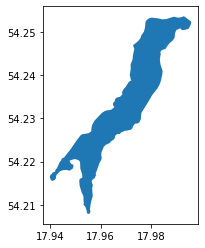

In [ ]:
import geopandas as gpd

data = gpd.read_file("JezioroRadunskieGorne.gpkg")
geo = data.geometry
geo.plot()

0.003902374383964047
3
23.74
[17.9399173 54.2079125 17.9957633 54.2536084]
0       POLYGON ((17.93936 54.20791, 17.93936 54.20847...
1       POLYGON ((17.93936 54.20847, 17.93936 54.20903...
2       POLYGON ((17.93936 54.20903, 17.93936 54.20959...
3       POLYGON ((17.93936 54.20959, 17.93936 54.21015...
4       POLYGON ((17.93936 54.21015, 17.93936 54.21070...
                              ...                        
8461    POLYGON ((17.99576 54.25147, 17.99576 54.25203...
8462    POLYGON ((17.99576 54.25203, 17.99576 54.25259...
8463    POLYGON ((17.99576 54.25259, 17.99576 54.25315...
8464    POLYGON ((17.99576 54.25315, 17.99576 54.25371...
8465    POLYGON ((17.99576 54.25371, 17.99576 54.25426...
Name: geometry, Length: 8466, dtype: geometry
8466
[8465, 8464, 8463, 8462, 8461, 8460, 8459, 8458, 8457, 8456, 8455, 8454, 8453, 8452, 8451, 8450, 8449, 8448, 8447, 8446, 8445, 8444, 8443, 8442, 8441, 8440, 8439, 8438, 8437, 8436, 8435, 8434, 8433, 8432, 8431, 8430, 8429, 8428, 8427, 8

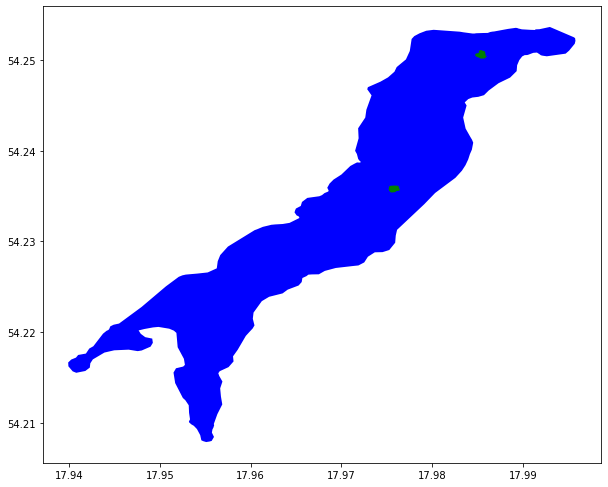

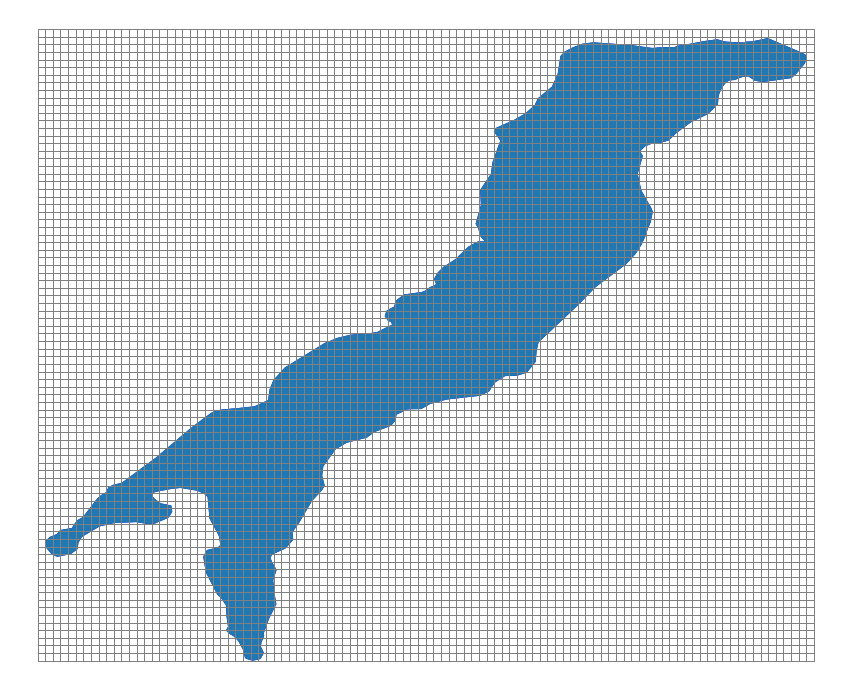

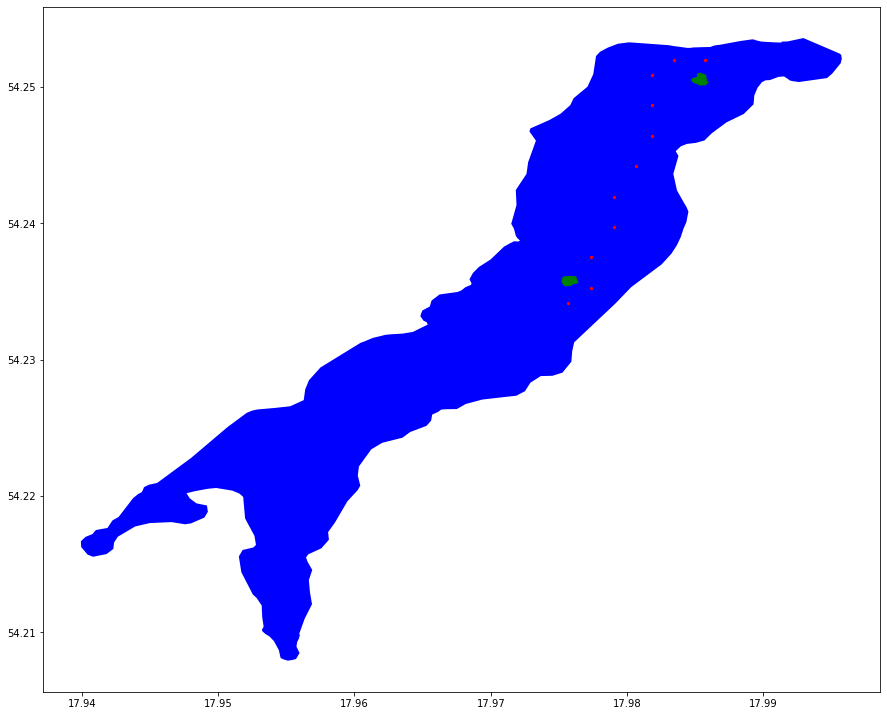

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.geometry

def explode(data):
#Explode MultiPolygon geometry into individual Polygon geometries in a shapefile using GeoPandas and Shapely 
#by mhweber <script src="https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26.js"></script>

    indf = gpd.GeoDataFrame.from_file(data)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

def printPoly(data):
  gdf = data
  gdf['color'] = ['b', 'g', 'g']
  gdf.plot(color=gdf['color'], figsize=(10, 10))

#Sprawdza czy punk jest jeziorem: Zwraca True jeśli tak
def isWater(geoMap,point):
  x = geoMap.loc[0].geometry.contains(point)
  #print('Status przynaleznosci punktu:',x)
  return x

geoTransform = explode("JezioroRadunskieGorne.gpkg")
point = Point(17.98, 54.24)
point2 = Point(16.96, 54.24)
point3 = Point(17.951318, 54.215673)
print(geoTransform.boundary.distance(point)[0])
isWater(geoTransform, point)
isWater(geoTransform, point2)
printPoly(geoTransform)
print(geoTransform.geometry.size)
radius = 0.0003 
angle = 30  
nx = 18.767241+radius*math.cos(math.radians(angle))
ny = 54.206447+radius*math.sin(math.radians(angle))       
GZ = Point(nx, ny) 
SD = Point(18.767241,54.206447)
hah = getDistanceInMeters(SD, GZ)
print(hah)
print(geoTransform.total_bounds)
xmin, ymin, xmax, ymax = geoTransform.total_bounds
n_cells=100
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
grid_points = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        grid_points.append([x0, y0])
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

gdf1 = geoTransform
gdf1['color'] = ['b', 'g', 'g']
base = gdf1.plot(color=gdf1['color'], figsize=(15, 15))
gdf.plot(ax=base, color='red', markersize=5)

ax = geoTransform.plot(ax=base, markersize=.1, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")
print(cell.geometry)
print(len(grid_points))


class Node:
    # Initialize the class
    def __init__(self, position:(), parent:()):
        self.position = position
        self.parent = parent
        self.g = 0 # Distance to start node
        self.h = 0 # Distance to goal node
        self.f = 0 # Total cost
    # Compare nodes
    def __eq__(self, other):
        return self.position == other.position
    # Sort nodes
    def __lt__(self, other):
         return self.f < other.f
    # Print node
    def __repr__(self):
        return ('({0},{1})'.format(self.position, self.f))


def astar_search(start, end, geodata):
    xmin, ymin, xmax, ymax = geodata.total_bounds
    n_cells=100
    cell_size = (xmax-xmin)/n_cells
    buffer_radius = 0.0003
    shape_number = geodata.geometry.size
    buffer = geodata.geometry.boundary.buffer(buffer_radius)
    # Create lists for open nodes and closed nodes
    open = []
    closed = []
    # Create a start node and an goal node
    start_node = Node(start, None)
    goal_node = Node(end, None)
    # Add the start node
    open.append(start_node)
    max_iter = 0
    # Loop until the open list is empty
    while len(open) > 0 or max_iter == 100:
        max_iter = max_iter + 1
        check_land = 0
        # Sort the open list to get the node with the lowest cost first
        open.sort()
        # Get the node with the lowest cost
        current_node = open.pop(0)
        # Add the current node to the closed list
        closed.append(current_node)
        
        # Check if we have reached the goal, return the path
        if current_node == goal_node:
            path = []
            while current_node != start_node:
                path.append(current_node.position)
                current_node = current_node.parent
            #path.append(start) 
            # Return reversed path
            return path[::-1]
        # Unzip the current node position
        (x, y) = current_node.position
        # Get neighbors
        diag = cell_size*math.sqrt(2)/2
        #neighbors = [(x-cell_size, y), (x+cell_size, y), (x, y-cell_size), (x, y+cell_size)]
        neighbors = [(x-cell_size, y), (x+cell_size, y), (x, y-cell_size), (x, y+cell_size), (x - (cell_size), y+(cell_size)), (x - (cell_size), y-(cell_size)), (x + (cell_size), y+(cell_size)), (x + (cell_size), y-(cell_size))]
        # Loop neighbors
        for next in neighbors:
            # Get value from map
            position = Point(next[0], next[1])
            # Check if the node is a wall
            for b in range(0, shape_number):
                if buffer.loc[b].contains(position):
                    check_land = 1
                    
            if geodata.distance(position)[0] > 0:
                check_land = 1

            if(check_land == 1):
                continue
            # Create a neighbor node
            neighbor = Node(next, current_node)
            # Check if the neighbor is in the closed list
            if(neighbor in closed):
                continue
            # Generate heuristics (Manhattan distance)
            #neighbor.g = abs(neighbor.position[0] - start_node.position[0]) + abs(neighbor.position[1] - start_node.position[1])
            #neighbor.h = abs(neighbor.position[0] - goal_node.position[0]) + abs(neighbor.position[1] - goal_node.position[1])
            neighbor.g = math.sqrt(abs(neighbor.position[0] - start_node.position[0]))**2 + math.sqrt(abs(neighbor.position[1] - start_node.position[1]))**2
            neighbor.h = math.sqrt(abs(neighbor.position[0] - goal_node.position[0]))**2 + math.sqrt(abs(neighbor.position[1] - goal_node.position[1]))**2
            neighbor.f = neighbor.g + neighbor.h
            # Check if neighbor is in open list and if it has a lower f value
            if(add_to_open(open, neighbor) == True):
                # Everything is green, add neighbor to open list
                open.append(neighbor)
    # Return None, no path is found
    return None
# Check if a neighbor should be added to open list
def add_to_open(open, neighbor):
    for node in open:
        if (neighbor == node and neighbor.f >= node.f):
            return False
    return True




start = None
end = None
data = grid_points.copy()
indeks_delete = []
for k in range(0,len(data),1):
  check_land = 0
  start = (data[k][0], data[k][1])
  position = Point(start)
              # Check if the node is a wall
  for b in range(0, shape_number):
    if buffer.loc[b].contains(position):
      check_land = 1
                      
  if geoTransform.distance(position)[0] > 0:
    check_land = 1
  #print("iteracja")
  #print(k)
  #print("check_land")
  #print(check_land)
  if check_land == 1:
    indeks_delete.append(k)

indeks_delete.sort(reverse=True)
print(indeks_delete)
data_pop = data.copy()
for v in range(len(indeks_delete)):
  data_pop.pop(indeks_delete[v])

#ustawienie startu i końca na siatce
start_n = (17.954248, 54.214303)       #start    
end_n = (17.945373, 54.219224)         #koniec
start_n = (17.975240, 54.231898)       #start    
end_n = (17.975240, 54.237537)         #koniec
start_n = (17.974556, 54.234057)       #start    
end_n = (17.986122, 54.251899)         #koniec
bliskosc_gridS = []
for u in range(len(data_pop)):
  bliskosc_gridS.append(abs(start_n[0] - data_pop[u][0])+abs(start_n[1] - data_pop[u][1]))
minimum_gridS = np.argmin(bliskosc_gridS)

bliskosc_gridE = []
for t in range(len(data_pop)):
  bliskosc_gridE.append(abs(end_n[0] - data_pop[t][0])+abs(end_n[1] - data_pop[t][1]))
minimum_gridE = np.argmin(bliskosc_gridE)

start = (data_pop[minimum_gridS][0], data_pop[minimum_gridS][1])
end = (data_pop[minimum_gridE][0], data_pop[minimum_gridE][1])

path = astar_search(start, end, geoTransform)
print()
print(path)
pathX = np.zeros(1800)
pathY = np.zeros(1800)

x1=[]
x2=[]
y1=[]
y2=[]
print(len(path))
path = path[1::4]
#for q in range(0, len(path)-4,2):
  #print(q+1)
  #path.pop(q+1)
  #(x2, y2) = path[q+2]
  #angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
print(path)
for p in range(len(path)):
  (pathX[p], pathY[p]) = path[p]

kappa_licznik = 0
for x in range(0, 1800):
  if pathX[x] != 0:
    kappa_licznik = kappa_licznik + 1
df = pd.DataFrame(
    {'Latitude': pathY[0:kappa_licznik],
     'Longitude': pathX[0:kappa_licznik]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
# We restrict to South America.
gdf1 = geoTransform
gdf1['color'] = ['b', 'g', 'g']
base = gdf1.plot(color=gdf1['color'], figsize=(15, 15))
gdf.plot(ax=base, color='red', markersize=5)
#print(gdf.head(1800))

plt.show()

In [ ]:
x = 100
przek = x*math.sqrt(2)/2
print(przek)
diag = cell_size*math.sqrt(2)/2
print(diag)
print(cell_size)

70.71067811865476
0.0007897817060428639
0.001116919999999979


# Potencjały + A*


In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 3.9 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 31.9 MB/s 


Mapa i funckje do mapy

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.geometry

def explode(data):
#Explode MultiPolygon geometry into individual Polygon geometries in a shapefile using GeoPandas and Shapely 
#by mhweber <script src="https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26.js"></script>

    indf = gpd.GeoDataFrame.from_file(data)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

def printPoly(data):
  gdf = data
  gdf['color'] = ['b', 'g', 'g']
  gdf.plot(color=gdf['color'], figsize=(10, 10))

#Sprawdza czy punk jest jeziorem: Zwraca True jeśli tak
def isWater(geoMap,point):
  x = geoMap.loc[0].geometry.contains(point)
  #print('Status przynaleznosci punktu:',x)
  return x

geoTransform = explode("JezioroRadunskieGorne.gpkg")

A*

In [ ]:
class Node:
    # Initialize the class
    def __init__(self, position:(), parent:()):
        self.position = position
        self.parent = parent
        self.g = 0 # Distance to start node
        self.h = 0 # Distance to goal node
        self.f = 0 # Total cost
    # Compare nodes
    def __eq__(self, other):
        return self.position == other.position
    # Sort nodes
    def __lt__(self, other):
         return self.f < other.f
    # Print node
    def __repr__(self):
        return ('({0},{1})'.format(self.position, self.f))


def astar_search(start, end, geodata, bounds, n_cells, buffer, shape_number):
    xmin, ymin, xmax, ymax = bounds #geodata.total_bounds
    #n_cells=100
    cell_size = (xmax-xmin)/n_cells
    #buffer_radius = 0.0003
    #shape_number = geodata.geometry.size
    #buffer = geodata.geometry.boundary.buffer(buffer_radius)
    # Create lists for open nodes and closed nodes
    open = []
    closed = []
    # Create a start node and an goal node
    start_node = Node(start, None)
    goal_node = Node(end, None)
    # Add the start node
    open.append(start_node)
    max_iter = 0
    # Loop until the open list is empty
    while len(open) > 0 or max_iter == 100:
        max_iter = max_iter + 1
        check_land = 0
        # Sort the open list to get the node with the lowest cost first
        open.sort()
        # Get the node with the lowest cost
        current_node = open.pop(0)
        # Add the current node to the closed list
        closed.append(current_node)
        
        # Check if we have reached the goal, return the path
        if current_node == goal_node:
            path = []
            while current_node != start_node:
                path.append(current_node.position)
                current_node = current_node.parent
            #path.append(start) 
            # Return reversed path
            return path[::-1]
        # Unzip the current node position
        (x, y) = current_node.position
        # Get neighbors
        #diag = cell_size*math.sqrt(2)/2
        #neighbors = [(x-cell_size, y), (x+cell_size, y), (x, y-cell_size), (x, y+cell_size)]
        neighbors = [(x-cell_size, y), (x+cell_size, y), (x, y-cell_size), (x, y+cell_size), (x - (cell_size), y+(cell_size)), (x - (cell_size), y-(cell_size)), (x + (cell_size), y+(cell_size)), (x + (cell_size), y-(cell_size))]
        # Loop neighbors
        for next in neighbors:
            # Get value from map
            position = Point(next[0], next[1])
            # Check if the node is a wall
            for b in range(0, shape_number):
                if buffer.loc[b].contains(position):
                    check_land = 1
                    
            if geodata.distance(position)[0] > 0:
                check_land = 1

            if(check_land == 1):
                continue
            # Create a neighbor node
            neighbor = Node(next, current_node)
            # Check if the neighbor is in the closed list
            if(neighbor in closed):
                continue
            # Generate heuristics (Manhattan distance)
            #neighbor.g = abs(neighbor.position[0] - start_node.position[0]) + abs(neighbor.position[1] - start_node.position[1])
            #neighbor.h = abs(neighbor.position[0] - goal_node.position[0]) + abs(neighbor.position[1] - goal_node.position[1])
            neighbor.g = math.sqrt(abs(neighbor.position[0] - start_node.position[0]))**2 + math.sqrt(abs(neighbor.position[1] - start_node.position[1]))**2
            neighbor.h = math.sqrt(abs(neighbor.position[0] - goal_node.position[0]))**2 + math.sqrt(abs(neighbor.position[1] - goal_node.position[1]))**2
            neighbor.f = neighbor.g + neighbor.h
            # Check if neighbor is in open list and if it has a lower f value
            if(add_to_open(open, neighbor) == True):
                # Everything is green, add neighbor to open list
                open.append(neighbor)
    # Return None, no path is found
    return None
# Check if a neighbor should be added to open list
def add_to_open(open, neighbor):
    for node in open:
        if (neighbor == node and neighbor.f >= node.f):
            return False
    return True

Siatka do mapy

In [ ]:
xmin, ymin, xmax, ymax = geoTransform.total_bounds
n_cells=100
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
grid_points = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        #grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        grid_points.append([x0, y0])
#cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

Potencjały

[8465, 8464, 8463, 8462, 8461, 8460, 8459, 8458, 8457, 8456, 8455, 8454, 8453, 8452, 8451, 8450, 8449, 8448, 8447, 8446, 8445, 8444, 8443, 8442, 8441, 8440, 8439, 8438, 8437, 8436, 8435, 8434, 8433, 8432, 8431, 8430, 8429, 8428, 8427, 8426, 8425, 8424, 8423, 8422, 8421, 8420, 8419, 8418, 8417, 8416, 8415, 8414, 8413, 8412, 8411, 8410, 8409, 8408, 8407, 8406, 8405, 8404, 8403, 8402, 8401, 8400, 8399, 8398, 8397, 8396, 8395, 8394, 8393, 8392, 8391, 8390, 8389, 8388, 8387, 8386, 8385, 8384, 8383, 8382, 8381, 8380, 8379, 8378, 8377, 8376, 8375, 8374, 8373, 8372, 8371, 8370, 8369, 8368, 8367, 8366, 8365, 8364, 8363, 8362, 8361, 8360, 8359, 8358, 8357, 8356, 8355, 8354, 8353, 8352, 8351, 8350, 8349, 8348, 8347, 8346, 8345, 8344, 8343, 8342, 8341, 8340, 8339, 8338, 8337, 8336, 8335, 8334, 8333, 8332, 8331, 8330, 8329, 8328, 8327, 8326, 8325, 8324, 8323, 8322, 8321, 8320, 8319, 8318, 8317, 8316, 8315, 8314, 8313, 8312, 8311, 8310, 8309, 8308, 8307, 8306, 8305, 8304, 8303, 8302, 8301, 8300, 829

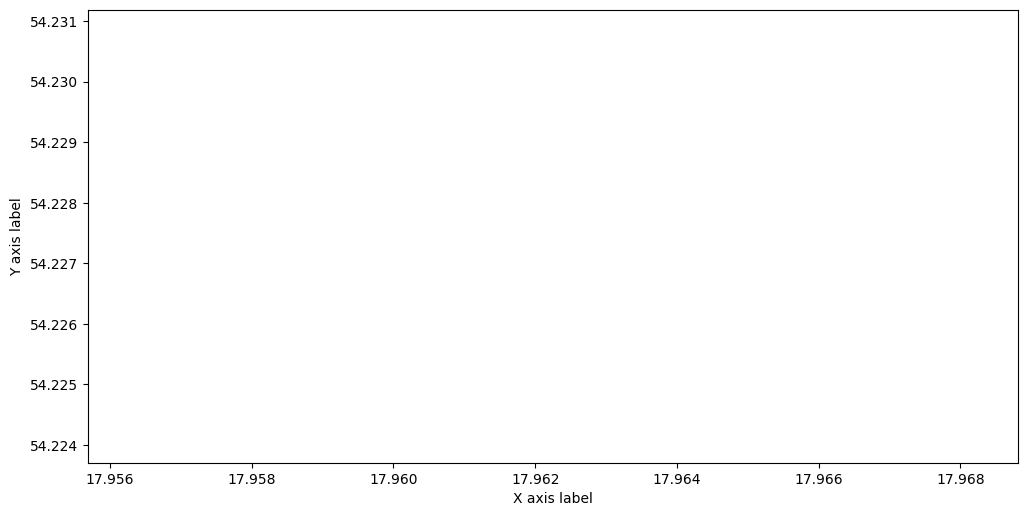

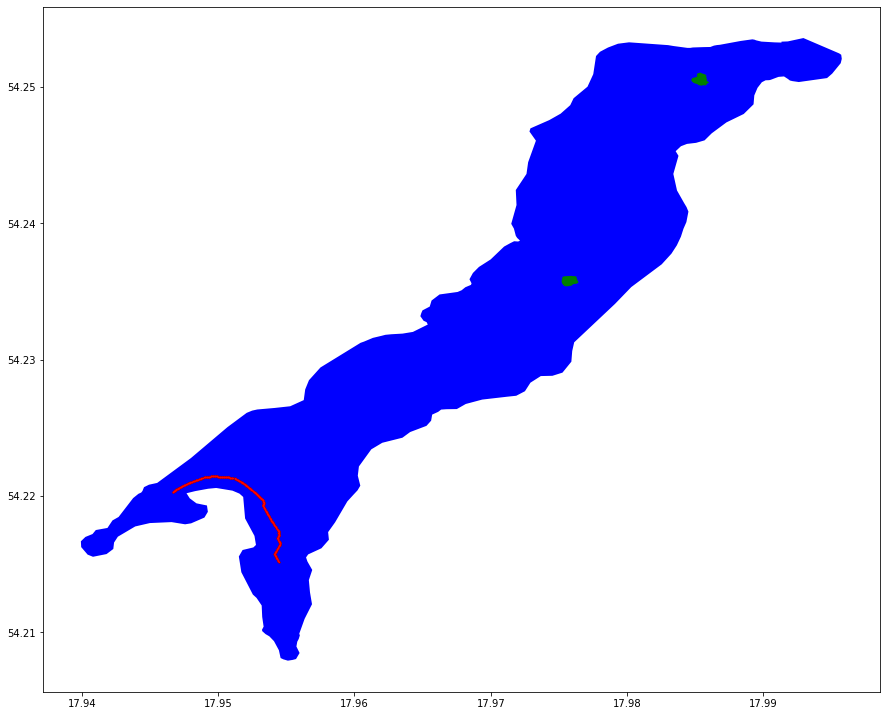

In [ ]:
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
import numpy as np
from scipy.optimize import minimize
from numpy.random import rand
from matplotlib import cm
import sys
import pandas as pd

#Odległość Euklidesowa
def dist(P, Q):
  dist = math.sqrt((Q.x-P.x)**2 + (Q.y-P.y)**2)
  return dist

def getDistanceInMeters(pointA, pointB):
  earthRadius = 6371000
  latA = pointA.y * math.pi/180
  latB = pointB.y * math.pi/180
  diffLat = (pointA.y - pointB.y) * math.pi/180
  diffLng = (pointA.x - pointB.x) * math.pi/180
  a = math.sin(diffLat / 2) * math.sin(diffLat / 2) + math.cos(latB) * math.cos(latA) * math.sin(diffLng / 2) * math.sin(diffLng / 2)
  #b = 2 * math.asin(math.sqrt(a))
  b = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) )
  distance = round((earthRadius * b), 2)
  return distance

#Potencjały
class Potentials:
  def __init__(self, Gg=3, k=100, Gup=10, Gdown=5, Gac=0.0000004):
    self.Gg = Gg
    self.k = k
    self.Gup = Gup
    self.Gdown = Gdown
    self.Gac = Gac

  #Potencjał względem celu
  def PotentialGoal(self, position, goal):
      Pg = self.Gg * dist(position, goal)
      return Pg
  
  #Potencjał względem przeszkody
  def PotentialObstacle(self, position, obstacle):
    if dist(position, obstacle) != 0:
      Po = self.k/dist(position, obstacle)
    else:
      Po = 200
    return Po

  #Potencjał pod wiatr
  def PotentialUpwind(self, boat, position, windDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    #fi = windDirection - angle
    fi = angle - windDirection

    if fi < -180:
      fi = 360 + fi
    if fi > 180:
      fi = 360 - fi

    if 0 <= abs(fi)< 30:
      Pup = self.Gup*dist(boat, position)
    else:
      Pup = 0
    return Pup

  #Potencjał z wiatrem
  def PotentialDownwind(self, boat, position, windDirection):
    angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
    #fi = windDirection - angle
    fi = angle - windDirection

    if fi < -180:
      fi = 360 + fi
    if fi > 180:
      fi = 360 - fi

    if 0<= abs(abs(fi)-180) < 30:
      Pdown = self.Gdown * dist(boat, position)
    else:
      Pdown = 0
    return Pdown    

  #Potencjał - kara za zmianę kierunku
  def PotentialAngleChange(self, boat, position, windDirection, previousDirection):
      angle = math.degrees(math.atan2(position.y - boat.y, position.x - boat.x))
      if abs(previousDirection - angle) > 180:
        Pac = self.Gac * (360-abs(previousDirection - angle))
      else:
        Pac = self.Gac * abs(previousDirection - angle)
      return Pac

  #Suma Potencjałów 
  def PotentialSum(self, boat, position, goal, obstacle, windDirection, previousDirection):
      GoalP = Potentials.PotentialGoal(position, goal)
      ObstacleP = Potentials.PotentialObstacle(position, obstacle)
      UpwindP = Potentials.PotentialUpwind(boat, position, windDirection)
      DownwindP = Potentials.PotentialDownwind(boat, position, windDirection)
      AngleChangeP = Potentials.PotentialAngleChange(boat, position, windDirection, previousDirection)
      Psum = GoalP + ObstacleP + UpwindP + DownwindP + AngleChangeP
      return Psum

DaneX=np.zeros(1800)       #tablica na kolejne położenia łodzi x
DaneY=np.zeros(1800)       #tablica na kolejne położenia łodzi y
window = np.zeros(180)    #tablica na wartość potencjału na okręgu wokół łodzi
X = np.zeros(180)         #tablica na x na okręgu wokół łodzi
Y = np.zeros(180)         #tablica na y na okręgu wokół łodzi
Potentials = Potentials() #można podać parametry w kontruktorze


#szukanie minimum w pętli
iter_zew = 0
def find_min(boat, goal, obstacle, windDirection, iter_zew):
  max_iter = 100
  iter = 0
  previousDirection = 135
  radius = 0.00005  #rozmiar okręgu na którym szukamy punktów 3,96m
  radius2 = 0.0003
  shape_number = geoTransform.geometry.size
  xD = geoTransform.geometry.boundary.buffer(radius2)


  while iter < max_iter and getDistanceInMeters(boat, goal) > 5: 
    radius = 0.00005
    for c in range(0, shape_number):
      if xD.loc[c].contains(boat):
        radius = 0.0009
    index = 0
    #print(radius)
    DaneX[iter_zew] = boat.x
    DaneY[iter_zew] = boat.y
    #liczenie potencjału na okręgu dla punktów co 2 stopnie
    for angle in range(0, 360, 2):
      x = boat.x + radius*math.cos(math.radians(angle))
      y = boat.y + radius*math.sin(math.radians(angle))
      position = Point(x, y)
      check_land = 0
      for b in range(0, shape_number):
        if xD.loc[b].contains(position):
          check_land = 1
      if geoTransform.distance(position)[0] > 0:
        check_land = 1
      if check_land == 1:
        Potential = 100000
      else:
        Potential = Potentials.PotentialSum(boat, position, goal, obstacle, windDirection, previousDirection)
      window[index] = Potential
      X[index] = x
      Y[index] = y
      index = index + 1
    minIndex = np.argmin(window) #indeks dla minimum na okręgu
    previousDirection = math.degrees(math.atan2(Y[minIndex] - boat.y, X[minIndex] - boat.x))
    boat = Point(X[minIndex], Y[minIndex])   #zmiana pozycji statku na wyznaczone minimum
    iter = iter + 1
    iter_zew = iter_zew + 1
  return boat, iter_zew

# zostawienie punktów siatki na lądzie
bounds = geoTransform.total_bounds
buffer_radius = 0.0003
buffer = geoTransform.geometry.boundary.buffer(buffer_radius)
shape_number = geoTransform.geometry.size

start = None
end = None
data = grid_points.copy()
indeks_delete = []
for k in range(0,len(data),1):
  check_land = 0
  start = (data[k][0], data[k][1])
  position = Point(start)
              # Check if the node is a wall
  for b in range(0, shape_number):
    if buffer.loc[b].contains(position):
      check_land = 1
                      
  if geoTransform.distance(position)[0] > 0:
    check_land = 1
  #print("iteracja")
  #print(k)
  #print("check_land")
  #print(check_land)
  if check_land == 1:
    indeks_delete.append(k)

indeks_delete.sort(reverse=True)
print(indeks_delete)
data_pop = data.copy()
for v in range(len(indeks_delete)):
  data_pop.pop(indeks_delete[v])

#ustawienie startu i końca na siatce
#wklęsłóść
start_n = (17.954248, 54.214303)       #start    
end_n = (17.945373, 54.219224)         #koniec
#jedna wyspa
#start_n = (17.975696, 54.231898)       #start    
#end_n = (17.975696, 54.241756)         #koniec
#dwie wyspy
#start_n = (17.974556, 54.234057)       #start    
#end_n = (17.986122, 54.251899)         #koniec
#prosta
#start_n = (17.955683, 54.223704)       #start    
#end_n = (17.968805, 54.231189)         #koniec
bliskosc_gridS = []
for u in range(len(data_pop)):
  bliskosc_gridS.append(abs(start_n[0] - data_pop[u][0])+abs(start_n[1] - data_pop[u][1]))
minimum_gridS = np.argmin(bliskosc_gridS)

bliskosc_gridE = []
for t in range(len(data_pop)):
  bliskosc_gridE.append(abs(end_n[0] - data_pop[t][0])+abs(end_n[1] - data_pop[t][1]))
minimum_gridE = np.argmin(bliskosc_gridE)

start = (data_pop[minimum_gridS][0], data_pop[minimum_gridS][1])
end = (data_pop[minimum_gridE][0], data_pop[minimum_gridE][1])

#A* wywołanie
path = astar_search(start, end, geoTransform, bounds, n_cells, buffer, shape_number)
path = path[1::4]
#goal = Point(17.949000,54.223725)           #Punkt docelowy

goal = Point(end) 
obstacle = Point(60.959218,60.220071)       #Położenie przeszkody
#boat = Point(17.951814,54.215700)           #tu failuje
boat = Point(start)           #Pozycja startowa statku
#Kierunek wiatru
windDirection = 90

#wywołanie pętli z potencjałami na punktach z A*
for w in range(len(path)-1):
  boat = Point(path[w])
  goal = Point(path[w+1]) 
  wynik, iter_zew = find_min(boat, goal, obstacle, windDirection, iter_zew)

print('Wynik:', wynik.x, wynik.y)

#plotowanie trasy na pustym wykresie
fig = plt.figure(figsize=(12,6), dpi=100)
ax = fig.add_subplot(111)
ax.azim = 270
ax.dist = 10
ax.elev = 90
plt.xlim([17.955683, 17.968805])
plt.ylim([54.223704, 54.231189])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
ax.scatter(DaneX, DaneY, s=0.5, c='red')
ax.scatter(obstacle.x, obstacle.y, c='red')
#ax.scatter(goal.x, goal.y, c='green')
circleGoal = plt.Circle((goal.x, goal.y), 0.00005, color='green', fill=False)
ax.add_patch(circleGoal)
plt.show()

#przypisanie wynikó kolejnych iteracji do formatu GeoDataFrame
kappa_licznik = 0
for x in range(0, 1800):
  if DaneX[x] != 0:
    kappa_licznik = kappa_licznik + 1
df = pd.DataFrame(
    {'Latitude': DaneY[0:kappa_licznik],
     'Longitude': DaneX[0:kappa_licznik]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
#ustawienie mapy jeziora jako tła
gdf1 = geoTransform
gdf1['color'] = ['b', 'g', 'g']
base = gdf1.plot(color=gdf1['color'], figsize=(15, 15))

#kappa
pathX = np.zeros(1800)
pathY = np.zeros(1800)
for p in range(len(path)):
  (pathX[p], pathY[p]) = path[p]

kappa_licznik = 0
for x in range(0, 1800):
  if pathX[x] != 0:
    kappa_licznik = kappa_licznik + 1
df = pd.DataFrame(
    {'Latitude': pathY[0:kappa_licznik],
     'Longitude': pathX[0:kappa_licznik]})
gdf2 = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
base2 = gdf.plot(ax=base, color='black', markersize=1)
#plotowanie wyników symulacji na jeziorze
gdf.plot(ax=base2, color='red', markersize=1)

#fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
#ax.set_aspect('equal')

#world.plot(ax=ax, color='white', edgecolor='black')


#cities.plot(ax=ax, marker='o', color='red', markersize=5)


#plt.show()



Liczenie promienia (ręczne) :)


In [ ]:
radius = 0.0003
angle = 30
SD = Point(18.767241,54.206447)  
nx = 18.767241+radius*math.cos(math.radians(angle))
ny = 54.206447+radius*math.sin(math.radians(angle))       
GZ = Point(nx, ny) 
hah = getDistanceInMeters(SD, GZ)
print("Promień: ", radius)
print("To ",hah,"m")

Promień:  0.0003
To  23.74 m


In [ ]:
# zostawienie punktów siatki na lądzie
start = None
end = None
data = grid_points.copy()
indeks_delete = []
for k in range(0,len(data),1):
  check_land = 0
  start = (data[k][0], data[k][1])
  buffer_radius = 0.0003
  shape_number = geoTransform.geometry.size
  buffer = geoTransform.geometry.boundary.buffer(buffer_radius)
  position = Point(start)
              # Check if the node is a wall
  for b in range(0, shape_number):
    if buffer.loc[b].contains(position):
      check_land = 1
                      
  if geoTransform.distance(position)[0] > 0:
    check_land = 1
  #print("iteracja")
  #print(k)
  #print("check_land")
  #print(check_land)
  if check_land == 1:
    indeks_delete.append(k)

indeks_delete.sort(reverse=True)
print(indeks_delete)
data_pop = data.copy()
for v in range(len(indeks_delete)):
  data_pop.pop(indeks_delete[v])

#ustawienie startu i końca na siatce
start_n = (17.954248, 54.214303)       #start    
end_n = (17.945373, 54.219224)         #koniec
bliskosc_gridS = []
for u in range(len(data_pop)):
  bliskosc_gridS.append(abs(start_n[0] - data_pop[u][0])+abs(start_n[1] - data_pop[u][1]))
minimum_gridS = np.argmin(bliskosc_gridS)

bliskosc_gridE = []
for t in range(len(data_pop)):
  bliskosc_gridE.append(abs(end_n[0] - data_pop[t][0])+abs(end_n[1] - data_pop[t][1]))
minimum_gridE = np.argmin(bliskosc_gridE)

start = (data_pop[minimum_gridS][0], data_pop[minimum_gridS][1])
end = (data_pop[minimum_gridE][0], data_pop[minimum_gridE][1])

In [ ]:
start_n = (17.955683, 54.223704)       #start    
end_n = (17.968805, 54.231189)         #koniec
angle = math.degrees(math.atan2(54.223704 - 54.231189, 17.955683 - 17.968805))
print(angle)

-150.29886885871292
